<a href="https://colab.research.google.com/github/MoonlightRS/BR_GROUP/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Чтение данных с файла


In [ ]:
import pandas as pd
import numpy as np

## Загрузка датасета и проверка пропусков

In [ ]:
df_2020 = pd.read_csv("drive/MyDrive/with_closed_ations_as________select_app_2020_X5_STORES.csv")
df_2019 = pd.read_csv("drive/MyDrive/with_closed_ations_as________select_app_2019_X5_STORES.csv")
df_2018 = pd.read_csv("drive/MyDrive/with_closed_ations_as________select_app_2018_X5_STORES.csv", encoding_errors="ignore")

<ipython-input-3-1b39d3df2689>:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("drive/MyDrive/with_closed_ations_as________select_app_2020_X5_STORES.csv")
<ipython-input-3-1b39d3df2689>:2: DtypeWarning: Columns (1,2,3,6,7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2019 = pd.read_csv("drive/MyDrive/with_closed_ations_as________select_app_2019_X5_STORES.csv")
<ipython-input-3-1b39d3df2689>:3: DtypeWarning: Columns (2,3,6,7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2018 = pd.read_csv("drive/MyDrive/with_closed_ations_as________select_app_2018_X5_STORES.csv", encoding_errors="ignore")


In [ ]:
df_combined = pd.concat([df_2020, df_2019, df_2018], ignore_index=True)

# Фильтруем только продавцов-кассиров
df_filtered = df_combined[df_combined['position_name'] == 'Продавец-кассир'].copy()

# Преобразуем типы данных
df_filtered['id_applicant'] = df_filtered['id_applicant'].astype(int)
df_filtered['id_partner'] = df_filtered['id_partner'].astype(int)
df_filtered['id_log'] = df_filtered['id_log'].astype(int)
df_filtered['department_id'] = df_filtered['department_id'].astype(int)
df_filtered['action_date'] = df_filtered['action_date'].astype(str)
mask = df_filtered['action_date'].str.len() == 22

# Для строк, удовлетворяющих условию, преобразуем их
df_filtered.loc[mask, 'action_date'] = (
    df_filtered.loc[mask, 'action_date'].str[:19] +
    '.000000' +
    df_filtered.loc[mask, 'action_date'].str[19:] +
    ':00'
)

df_filtered['action_date'] = pd.to_datetime(df_filtered['action_date'], errors='coerce')

# Для столбца is_active_action
df_filtered['is_active_action'] = (
    df_filtered['is_active_action']
    .astype(str)  # Сначала преобразуем всё в строку
    .str.lower()  # Приводим к нижнему регистру
    .replace({'true': True, 'false': False})  # Нормализуем значения
    .astype(bool)  # Преобразуем в булев тип
)

# Аналогично для is_open_action
df_filtered['is_open_action'] = (
    df_filtered['is_open_action']
    .astype(str)
    .str.lower()
    .replace({'true': True, 'false': False})
    .astype(bool)
)

# Количество пропущенных значений в каждом столбце
nan_counts = df_filtered.isna().sum()
print("Количество пропущенных значений (NaN) по столбцам:")
print(nan_counts)

<ipython-input-4-44d2062c357d>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'true': True, 'false': False})  # Нормализуем значения
<ipython-input-4-44d2062c357d>:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'true': True, 'false': False})


Количество пропущенных значений (NaN) по столбцам:
id_applicant              0
id_partner                0
id_log                    0
department_id             0
action_date               0
stage_name                0
activity_name       2136841
result_name         2166331
position_name             0
is_active_action          0
is_open_action            0
dtype: int64


In [ ]:
mask_nan = df_filtered['id_log'] == -1
df_filtered[mask_nan].groupby('stage_name').size()

,0
stage_name,
Интервью с руководителем,11580
Не прошел СБ,5288
Обработка,570
Оформление,5956
СБ,322
Создание кандидата,1734982
Черный список,54


In [ ]:
mask_log = (df_filtered['id_log'] == -1) & (df_filtered['stage_name'] != 'Создание кандидата')
applicant_with_log = df_filtered[mask_log].id_applicant.unique()

df_filtered = df_filtered[~df_filtered.id_applicant.isin(applicant_with_log)].copy()  # цепочки с нормальными id_log

In [ ]:
df_filtered.head()

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action
0,4797513,3847682,-1,7335,2020-03-23 19:57:25.316022+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
3,4788965,3843286,-1,10613,2020-03-20 16:09:34.454329+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
4,4777310,2372866,-1,45445,2020-03-18 13:53:36.124784+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
11,4798971,1253935,-1,9851,2020-03-24 10:39:28.667648+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
13,4637426,3352131,-1,7640,2020-02-13 12:44:35.802112+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False


In [ ]:
df_filtered.groupby('stage_name').size()

,0
stage_name,
Выход на работу,1170
Выход состоялся,2
Гайд-интервью,12
Групповое собеседование и тестирование,78
Интервью с руководителем,2425869
Кадровый резерв,24
Мы отказали,2232
Назначение времени на оформление/медосмотр,434176
Не прошел СБ,7169


In [ ]:
df_without_create = df_filtered[df_filtered.id_log != -1].copy()
df_without_create['number_stage'] = df_without_create.sort_values(['id_applicant', 'action_date']).groupby('id_applicant').cumcount() + 1
df_without_create.head()

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
214803,4809567,2629500,26692963,31923,2020-03-27 13:10:45.060698+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,Продавец-кассир,True,False,5
214805,4792314,3844975,26638189,7659,2020-03-25 17:15:13.891263+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,Продавец-кассир,True,False,1
214806,4809171,3853922,26638919,12320,2020-03-25 17:27:59.398956+00:00,Интервью с руководителем,Назначить интервью с руководителем,Отказ кандидата,Продавец-кассир,True,False,3
214807,4809171,3853922,26638908,12320,2020-03-25 17:27:45.172883+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,2
214808,4809171,3853922,26638907,12320,2020-03-25 17:27:44.445276+00:00,Обработка,Провести первичную обработку,Подходит,Продавец-кассир,True,False,1


In [ ]:
df_without_create[df_without_create.number_stage == 1].groupby('stage_name').size()

,0
stage_name,
Выход на работу,1
Выход состоялся,1
Интервью с руководителем,10607
Мы отказали,2
Назначение времени на оформление/медосмотр,953
Не прошел СБ,2574
Обработка,1193922
Ожидание,86
Отказался,8


Убираем цепочки, у которых первый шаг равен одну из следующих значений:

Выход на работу, Выход состоялся, Назначение времени на оформление/медосмотр

In [ ]:
mask_first_stage = (df_without_create.number_stage == 1) & \
                  (df_without_create.stage_name.isin(['Выход на работу', 'Выход состоялся', 'Назначение времени на оформление/медосмотр']))
applicant_with_stage = df_without_create[mask_first_stage].id_applicant.unique()

df_without_create = df_without_create[~df_without_create.id_applicant.isin(applicant_with_stage)]

In [ ]:
#проверяем
df_without_create[df_without_create.number_stage == 1].groupby('stage_name').size()

,0
stage_name,
Интервью с руководителем,10607
Мы отказали,2
Не прошел СБ,2574
Обработка,1193922
Ожидание,86
Отказался,8
Оформление,6635
Резерв,5
СБ,636


In [ ]:
df_without_create[['stage_name', 'activity_name', 'result_name']].groupby('stage_name').agg({
      'activity_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
      'result_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
  })

,activity_name,result_name
stage_name,,
Выход на работу,"[nan, Узнать результаты приема, Проверить выхо...","[ОС не предоставлена руководителем, Недозвон, ..."
Гайд-интервью,"[Узнать результаты гайд-интервью, Назначить вр...","[Подходит, Время назначено]"
Групповое собеседование и тестирование,[Назначить групповое собеседование и тестирова...,"[Отказ кандидата, Перенос кандидата, Встреча н..."
Интервью с руководителем,"[Узнать результаты интервью с руководителем, Н...","[Отказ кандидата, ОС не предоставлена руководи..."
Кадровый резерв,[nan],"[nan, Подходит]"
Мы отказали,[nan],"[nan, Недозвон, В белый список, Нет обратной с..."
Назначение времени на оформление/медосмотр,[Назначить время на оформление/медосмотр (недо...,"[Время назначено, Недозвон, Подходит, Отказ ка..."
Не прошел СБ,"[Вывести из черного списка, nan]","[В белый список, nan, Подходит, Не подходит, Р..."
Обработка,"[Проверка формы обращения, Провести первичную ...","[Не резерв, Подходит, Не подходит, Резерв, Отк..."


In [ ]:
df_without_create.groupby('stage_name')[['id_applicant']].nunique().reset_index()

,stage_name,id_applicant
0,Выход на работу,1129
1,Гайд-интервью,2
2,Групповое собеседование и тестирование,19
3,Интервью с руководителем,902826
4,Кадровый резерв,24
5,Мы отказали,2213
6,Назначение времени на оформление/медосмотр,214876
7,Не прошел СБ,6689
8,Обработка,1197100
9,Ожидание,55348


Сделаем гайд-интервью и обычное интервью одним шагом.

In [ ]:
df_without_create.loc[
    df_without_create.stage_name.isin(['Гайд-интервью', 'Интервью с руководителем', 'Групповое собеседование и тестирование']),
    'stage_name'
] = 'Интервью'

In [ ]:
df_without_create.groupby('stage_name')[['id_applicant']].nunique().reset_index()

,stage_name,id_applicant
0,Выход на работу,1129
1,Интервью,902845
2,Кадровый резерв,24
3,Мы отказали,2213
4,Назначение времени на оформление/медосмотр,214876
5,Не прошел СБ,6689
6,Обработка,1197100
7,Ожидание,55348
8,Отказался,37335
9,Оформление,297449


In [ ]:
df_without_create[['stage_name', 'activity_name', 'result_name']].groupby('stage_name', dropna=False ).agg({
      'activity_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
      'result_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
  })

,activity_name,result_name
stage_name,,
Выход на работу,"[nan, Узнать результаты приема, Проверить выхо...","[ОС не предоставлена руководителем, Недозвон, ..."
Интервью,"[Узнать результаты интервью с руководителем, Н...","[Отказ кандидата, ОС не предоставлена руководи..."
Кадровый резерв,[nan],"[nan, Подходит]"
Мы отказали,[nan],"[nan, Недозвон, В белый список, Нет обратной с..."
Назначение времени на оформление/медосмотр,[Назначить время на оформление/медосмотр (недо...,"[Время назначено, Недозвон, Подходит, Отказ ка..."
Не прошел СБ,"[Вывести из черного списка, nan]","[В белый список, nan, Подходит, Не подходит, Р..."
Обработка,"[Проверка формы обращения, Провести первичную ...","[Не резерв, Подходит, Не подходит, Резерв, Отк..."
Ожидание,"[Вернуть в воронку, Назначить время на оформле...","[Интервью с руководителем, nan, Обработка, Под..."
Отказался,[nan],"[nan, Отказ кандидата, Нет обратной связи от р..."


In [ ]:
# Заменяем NaN в result_name на строку 'missing' для дальнейшей работы
df_without_create['result_name'] = df_without_create['result_name'].fillna('missing')

### Шаг "Мы отказали"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Мы отказали',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
NaN,"{'missing': 2138, 'Подходит': 37, 'Не подходит..."


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Мы отказали') & (df_without_create.result_name == 'missing'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name', 'prev_result_name']]
result_df.prev_result_name = 'Не подходит'
df_without_create.loc[(df_without_create.stage_name == 'Мы отказали') & (df_without_create.result_name == 'missing'),\
                              ['stage_name','activity_name']] = result_df

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Мы отказали') & (df_without_create.result_name == 'Черный список'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info['prev_stage_name']
df_without_create.loc[(df_without_create.stage_name == 'Мы отказали') & (df_without_create.result_name == 'Черный список'),\
                              'stage_name',] = result_df

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Мы отказали'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name']]
df_without_create.loc[(df_without_create.stage_name == 'Мы отказали'),\
                              ['stage_name','activity_name']] = result_df

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Мы отказали',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,


### Шаг "Ожидание"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Ожидание',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вернуть в воронку,"{'missing': 42775, 'Интервью с руководителем':..."
Назначить время на оформление/медосмотр,{'Назначить время на оформление/медосмотр': 3}
Назначить интервью с руководителем,"{'Интервью с руководителем': 7, 'Обработка': 2..."
Провести первичную обработку,{'Обработка': 6}
Узнать результаты приема,{'Оформление': 2}
NaN,"{'missing': 1, 'Подходит': 1}"


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Назначить время на оформление/медосмотр'),\
                      ['stage_name', 'result_name']] = ['Оформление', 'Ожидание']

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Назначить интервью с руководителем')\
                      & (df_without_create.result_name == 'Встреча назначена'),\
                      ['stage_name', 'result_name']] = ['Интервью', 'Время назначено']

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Назначить интервью с руководителем'),\
                      ['stage_name', 'result_name']] = ['Интервью', 'Ожидание']

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Провести первичную обработку'),\
                      ['stage_name', 'result_name']] = ['Обработка', 'Ожидание']

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Узнать результаты приема'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Выводим результат
print(current_steps[['id_applicant', 'number_stage',
                     'prev_stage_name', 'prev_activity_name', 'prev_result_name',
                     'next_stage_name', 'next_activity_name', 'next_result_name']])

          id_applicant  number_stage prev_stage_name prev_activity_name  \
5820983        3504101            24        Ожидание  Вернуть в воронку   
10873553       3132065            10        Ожидание  Вернуть в воронку   

         prev_result_name next_stage_name        next_activity_name  \
5820983        Оформление      Оформление  Узнать результаты приема   
10873553       Оформление      Оформление  Узнать результаты приема   

         next_result_name  
5820983            Принят  
10873553           Принят  


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Узнать результаты приема'),\
                      ['stage_name', 'result_name']] = ['Оформление', 'Ожидание']

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Ожидание',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вернуть в воронку,"{'missing': 42775, 'Интервью с руководителем':..."
NaN,"{'missing': 1, 'Подходит': 1}"


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name.isna() == True),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Выводим результат
print(current_steps[['id_applicant', 'number_stage',
                     'prev_stage_name', 'prev_activity_name', 'prev_result_name',
                     'next_stage_name', 'next_activity_name', 'next_result_name']])

         id_applicant  number_stage prev_stage_name  \
4166320       3890228             9      Оформление   
8582758       3239930             8              СБ   

                              prev_activity_name prev_result_name  \
4166320  Назначить время на оформление/медосмотр         Ожидание   
8582758                 Проверка формы обращения        Не резерв   

        next_stage_name                       next_activity_name  \
4166320      Оформление  Назначить время на оформление/медосмотр   
8582758       Обработка                 Проверка формы обращения   

        next_result_name  
4166320  Время назначено  
8582758        Не резерв  


Судя по шагам, для первого кандидата из цепочки просто удалим данный шаг, так как он избыточен, а второй исследуем отдельно

In [ ]:
df_without_create = df_without_create[~((df_without_create.id_applicant == 3890228) & (df_without_create.number_stage == 9))]

In [ ]:
df_without_create[df_without_create.id_applicant == 3239930].sort_values('action_date')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
8582765,3239930,2979385,16641296,36265,2018-12-03 08:36:31.482933+00:00,Обработка,Провести первичную обработку,Подходит,Продавец-кассир,True,False,1
8582764,3239930,2979385,16641297,36265,2018-12-03 08:36:32.081814+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,2
8582763,3239930,2979385,16641298,36265,2018-12-03 08:36:32.753983+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,3
8582762,3239930,2979385,16641299,36265,2018-12-03 08:36:33.261787+00:00,Интервью,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,True,False,4
8582761,3239930,2979385,16641300,36265,2018-12-03 08:36:33.754274+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,False,5
8582759,3239930,2979385,16698486,36265,2018-12-05 09:54:30.677525+00:00,СБ,Узнать результаты СБ,Подходит,Продавец-кассир,True,False,6
8582760,3239930,2979385,16698489,36265,2018-12-05 09:54:31.303060+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
8582758,3239930,2979385,16908983,36265,2018-12-14 16:12:02.604691+00:00,Ожидание,NaN,Подходит,Продавец-кассир,True,False,8
8582757,3239930,2979385,16908984,36265,2018-12-14 16:12:03.178212+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,9
8582756,3239930,2979385,16908985,36265,2018-12-14 16:12:03.840070+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,10


Удаляем цепочку из анализа, из-за ее нестандартности

In [ ]:
df_without_create = df_without_create[~(df_without_create.id_applicant == 3239930)]

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Ожидание',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вернуть в воронку,"{'missing': 42775, 'Интервью с руководителем':..."


In [ ]:
id = df_without_create.loc[(df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') & (df_without_create.result_name == 'Не подходит'), 'id_applicant'].head(1).values[0]
df_without_create[df_without_create.id_applicant == id].sort_values('action_date')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
11673661,3253413,2980451,16714384,23729,2018-12-05 16:55:40.518310+00:00,Обработка,Провести первичную обработку,Подходит,Продавец-кассир,True,False,1
11673662,3253413,2980451,16714385,23729,2018-12-05 16:55:40.888226+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,2
11673663,3253413,2980451,16714524,23729,2018-12-05 16:58:13.147822+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,3
11673660,3253413,2980451,17120338,23729,2018-12-27 13:29:56.235347+00:00,Интервью,Узнать результаты интервью с руководителем,Ожидание,Продавец-кассир,True,False,4
11673659,3253413,2980451,17120403,23729,2018-12-27 13:33:12.293379+00:00,Ожидание,Вернуть в воронку,Не подходит,Продавец-кассир,True,False,5


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Вернуть в воронку')\
                      & (df_without_create.result_name == 'Не подходит'),\
                      ['stage_name', 'activity_name']] = ['Интервью', 'Узнать результаты интервью с руководителем']

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Ожидание') & (df_without_create.activity_name == 'Вернуть в воронку')\
                      & (df_without_create.result_name.isin(['Отказ руководителя', 'Отказ кандидата'])),\
                      ['stage_name', 'activity_name']] = ['Интервью', 'Узнать результаты интервью с руководителем']

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name == 'missing'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

# Убираем дубликаты — оставляем только уникальные сочетания
result_unique = result_df.drop_duplicates().reset_index(drop=True)

print(result_unique)

                                prev_stage_name  \
0                                     Обработка   
1                                      Интервью   
2                                     Обработка   
3                                      Интервью   
4                                    Оформление   
..                                          ...   
243                                  Оформление   
244                                    Интервью   
245  Назначение времени на оформление/медосмотр   
246  Назначение времени на оформление/медосмотр   
247                                    Интервью   

                                    prev_activity_name prev_result_name  \
0                         Провести первичную обработку         Ожидание   
1           Узнать результаты интервью с руководителем         Ожидание   
2                         Провести первичную обработку         Ожидание   
3                   Назначить интервью с руководителем         Ожидание   
4           

Удалим данные строчки, так как судя по анализу они не являются обязательными

In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name == 'missing'))]

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name == 'Интервью с руководителем'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

# Убираем дубликаты — оставляем только уникальные сочетания
result_unique = result_df.drop_duplicates().reset_index(drop=True)

print(result_unique.sort_values('prev_result_name'))
result_unique.groupby(['prev_result_name', 'next_result_name']).size()

                                prev_stage_name  \
64   Назначение времени на оформление/медосмотр   
88   Назначение времени на оформление/медосмотр   
37                                    Обработка   
44                                           СБ   
81   Назначение времени на оформление/медосмотр   
..                                          ...   
101                                    Интервью   
29                                         None   
39                                         None   
94                                         None   
108                                        None   

                          prev_activity_name prev_result_name next_stage_name  \
64   Назначить время на оформление/медосмотр          missing        Интервью   
88   Назначить время на оформление/медосмотр          missing        Интервью   
37              Провести первичную обработку          missing        Интервью   
44              Подготовить анкету кандидата          missing  

prev_result_name          next_result_name        
missing                   missing                      5
                          Встреча назначена            6
                          Интервью с руководителем     1
                          Недозвон                     1
                          Нет обратной связи           5
                          Ожидание                     2
                          Отказ кандидата              3
                          Отказ руководителя           2
В ожидании                missing                      1
Время назначено           Встреча назначена            1
Встреча назначена         missing                      1
                          Нет обратной связи           2
                          Отказ кандидата              1
                          Подготовлена                 1
                          Подходит                     1
Источник не Яндекс Цифра  missing                      1
                          Встреча назначена            1
                          Нет обратной связи           1
                          Резерв                       1
Не резерв                 missing                      1
                          Встреча назначена            2
Нет обратной связи        Нет обратной связи           1
                          Отказ кандидата              1
Ожидание                  missing                     19
                          Встреча назначена            9
                          Интервью с руководителем     5
                          Недозвон                     2
                          Нет обратной связи          10
                          Обработка                    1
                          Ожидание                     5
                          Отказ кандидата              8
                          Отказ руководителя           6
                          Перенос звонка               3
                          Резерв                       6
Отказ кандидата           missing                      1
Перенос кандидата         missing                      1
Подготовлена              Подходит                     1
Резерв                    missing                      1
dtype: int64

Удалим данные строчки, так как судя по анализу они не являются обязательными

In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name == 'Интервью с руководителем'))]

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name == 'Назначить время на оформление/медосмотр'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

# Убираем дубликаты — оставляем только уникальные сочетания
result_unique = result_df.drop_duplicates().reset_index(drop=True)

print(result_unique.sort_values('prev_result_name'))
result_unique.groupby(['prev_result_name', 'next_result_name']).size()

                                prev_stage_name  \
0                                    Оформление   
54                                     Интервью   
52                                     Интервью   
87   Назначение времени на оформление/медосмотр   
92                                     Интервью   
..                                          ...   
98                                   Оформление   
59                                   Оформление   
140  Назначение времени на оформление/медосмотр   
80                                         None   
93                                         None   

                          prev_activity_name prev_result_name  \
0                   Узнать результаты приема          missing   
54        Назначить интервью с руководителем          missing   
52        Назначить интервью с руководителем          missing   
87   Назначить время на оформление/медосмотр          missing   
92        Назначить интервью с руководителем          missing 

prev_result_name        next_result_name                       
missing                 missing                                     2
                        Время назначено                             3
                        Недозвон                                    4
                        Ожидание                                    2
                        Отказ кандидата                             1
                        Подходит                                    3
В ожидании              Подходит                                    1
Время назначено         missing                                     1
                        В ожидании                                  1
                        Недозвон                                    1
                        Ожидание                                    1
                        Принят                                      1
                        Резерв                                      1
Встреча назначена       Подходит                                    1
Направлен на медосмотр  Ожидание                                    1
Не резерв               Время назначено                             1
                        Недозвон                                    1
                        Подходит                                    1
Недозвон                Время назначено                             1
                        Ожидание                                    1
                        Подходит                                    1
Ожидание                missing                                    16
                        Время назначено                            11
                        Интервью с руководителем                    1
                        Назначить время на оформление/медосмотр     6
                        Направлен на медосмотр                      7
                        Недозвон                                   13
                        Ожидание                                   12
                        Отказ кандидата                             9
                        Оформление                                  1
                        Перенос звонка                              5
                        Подходит                                    7
                        Принят                                      4
                        Резерв                                      7
Отказ кандидата         Подходит                                    1
Оформление              missing                                     1
Подготовлена            Недозвон                                    1
                        Подходит                                    1
Принят                  Время назначено                             1
                        Подходит                                    1
Резерв                  missing                                     1
dtype: int64

Удалим данные строчки, так как судя по анализу они не являются обязательными

In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name == 'Назначить время на оформление/медосмотр'))]

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Ожидание',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вернуть в воронку,"{'Оформление': 5390, 'Обработка': 3063, 'Подхо..."


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку') &
    (df_without_create.result_name.isin(['Резерв', 'Принят', 'Встреча назначена', 'Время назначено'])),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

# Убираем дубликаты — оставляем только уникальные сочетания
result_unique = result_df.drop_duplicates().reset_index(drop=True)

print(result_unique.sort_values('prev_result_name'))
result_unique.groupby(['prev_result_name', 'next_result_name']).size()

                              prev_stage_name  \
0                                  Оформление   
1                                      Резерв   
2                                  Оформление   
3                                    Интервью   
4                                    Интервью   
5                                  Оформление   
6                                  Оформление   
7                                  Оформление   
8                                  Оформление   
9  Назначение времени на оформление/медосмотр   

                                  prev_activity_name prev_result_name  \
0  Назначить время на оформление/медосмотр (недоз...         Ожидание   
1                                                NaN         Ожидание   
2  Назначить время на оформление/медосмотр (недоз...         Ожидание   
3                 Назначить интервью с руководителем         Ожидание   
4                 Назначить интервью с руководителем         Ожидание   
5            Назначить

prev_result_name  next_result_name
Ожидание          missing             4
                  В ожидании          1
                  Не принят           1
                  Недозвон            1
                  Ожидание            1
dtype: int64

In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Ожидание') &
    (df_without_create.activity_name == 'Вернуть в воронку'))]

Обновим последовательность шагов

In [ ]:
df_without_create['number_stage'] = df_without_create.sort_values(['id_applicant', 'action_date']).groupby('id_applicant').cumcount() + 1

### Шаг "Обработка"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': [
        lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
    ]
  })

,result_name
,<lambda>
activity_name,
Назначить время на оформление/медосмотр (недозвон),"{'Недозвон': 6, 'Подходит': 2, 'Время назначен..."
Проверка источника,"{'Источник не Яндекс Цифра': 106811, 'Источник..."
Проверка формы обращения,"{'Не резерв': 433527, 'missing': 797, 'Кадровы..."
Провести первичную обработку,"{'Подходит': 902538, 'Недозвон': 251583, 'Отка..."
Узнать результаты СБ,{'Подходит': 2}
Узнать результаты медосмотра,{'Недозвон': 1}
NaN,"{'Источник не Яндекс Цифра': 77520, 'Источник ..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Назначить время на оформление/медосмотр (недозвон)'),\
                      ['stage_name', 'activity_name', 'result_name']] = ['Оформление', 'Назначить время на оформление/медосмотр', 'Недозвон']

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Узнать результаты СБ'),\
                      'stage_name'] = 'СБ'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Узнать результаты медосмотра'),\
                      'stage_name'] = 'Оформление'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Провести первичную обработку'),\
                      'activity_name'] = 'Проверка формы обращения'

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name').agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Проверка источника,"{'Источник не Яндекс Цифра': 106811, 'Источник..."
Проверка формы обращения,"{'Подходит': 902626, 'Не резерв': 433527, 'Нед..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Проверка формы обращения')\
                      & (df_without_create.result_name == ' Не резерв'),\
                      'result_name'] = 'Не резерв'

df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Проверка формы обращения')\
                      & (df_without_create.result_name == 'Нет обратной связи'),\
                      'result_name'] = 'Недозвон'

In [ ]:
df_without_create[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Проверка формы обращения')\
                      & (df_without_create.result_name == 'Назначить время на оформление/медосмотр')]

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
5017173,3523692,2916949,18692633,25451,2019-04-01 16:19:39.350267+00:00,Обработка,Проверка формы обращения,Назначить время на оформление/медосмотр,Продавец-кассир,True,False,10


In [ ]:
df_without_create[df_without_create.id_applicant == 3523692].sort_values('action_date')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
5017182,3523692,2916949,18245068,25451,2019-03-11 14:59:28.492741+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,True,False,1
5017181,3523692,2916949,18245070,25451,2019-03-11 14:59:29.102195+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,2
5017180,3523692,2916949,18245071,25451,2019-03-11 14:59:29.797628+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,3
5017179,3523692,2916949,18245072,25451,2019-03-11 14:59:30.449490+00:00,Интервью,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,True,False,4
5017178,3523692,2916949,18245074,25451,2019-03-11 14:59:31.084937+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,False,5
5017176,3523692,2916949,18261869,25451,2019-03-12 11:35:59.897889+00:00,СБ,Узнать результаты СБ,Подходит,Продавец-кассир,True,False,6
5017177,3523692,2916949,18261870,25451,2019-03-12 11:36:01.360364+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
5017175,3523692,2916949,18384094,25451,2019-03-18 12:44:05.537269+00:00,Оформление,Назначить время на оформление/медосмотр,Время назначено,Продавец-кассир,True,False,8
5017174,3523692,2916949,18483673,25451,2019-03-21 17:43:40.224412+00:00,Оформление,Узнать результаты приема,Ожидание,Продавец-кассир,True,False,9
5017173,3523692,2916949,18692633,25451,2019-04-01 16:19:39.350267+00:00,Обработка,Проверка формы обращения,Назначить время на оформление/медосмотр,Продавец-кассир,True,False,10


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Проверка формы обращения')\
                      & (df_without_create.result_name == 'Назначить время на оформление/медосмотр'),\
                      ['stage_name', 'activity_name', 'result_name']] = ['Оформление', 'Назначить время на оформление/медосмотр', 'Ожидание']

In [ ]:
df_without_create[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Проверка формы обращения')\
                      & (df_without_create.result_name == 'Подготовлена')]

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
8046689,2632512,2314072,13445095,10854,2018-06-09 12:29:48.664521+00:00,Обработка,Проверка формы обращения,Подготовлена,Продавец-кассир,False,False,24


In [ ]:
df_without_create[df_without_create.id_applicant == 2632512].sort_values('action_date')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
8046714,2632512,2314072,13248149,10854,2018-05-31 13:03:09.807152+00:00,Обработка,Проверка формы обращения,Резерв,Продавец-кассир,False,False,1
8046710,2632512,2314072,13412795,10854,2018-06-08 10:19:06+00:00,Резерв,NaN,missing,Продавец-кассир,False,False,2
8046712,2632512,2314072,13412814,10854,2018-06-08 10:19:14.784731+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,False,False,3
8046711,2632512,2314072,13412815,10854,2018-06-08 10:19:15.380405+00:00,Обработка,NaN,Источник Яндекс Цифра,Продавец-кассир,True,False,4
8046709,2632512,2314072,13431214,10854,2018-06-08 17:07:13+00:00,СБ,Подготовить анкету кандидата,missing,Продавец-кассир,False,False,5
8046707,2632512,2314072,13431223,10854,2018-06-08 17:07:22.551310+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,True,False,6
8046708,2632512,2314072,13431224,10854,2018-06-08 17:07:23.227724+00:00,Обработка,NaN,Источник Яндекс Цифра,Продавец-кассир,True,False,7
8046705,2632512,2314072,13431402,10854,2018-06-08 17:12:59.555111+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,True,False,8
8046706,2632512,2314072,13431404,10854,2018-06-08 17:12:59.967199+00:00,Обработка,NaN,Источник Яндекс Цифра,Продавец-кассир,True,False,9
8046704,2632512,2314072,13431553,10854,2018-06-08 17:16:47.946221+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,True,False,10


Какая-то странная цепочка, очень нестандартная, этапы зацикленны, причина такой зацикленности не ясна.

In [ ]:
df_without_create = df_without_create[df_without_create.id_applicant != 2632512]

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Проверка источника,"{'Источник не Яндекс Цифра': 106811, 'Источник..."
Проверка формы обращения,"{'Подходит': 902613, 'Не резерв': 433528, 'Нед..."
NaN,"{'Источник не Яндекс Цифра': 77520, 'Источник ..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name == 'Проверка источника')\
                      & (df_without_create.result_name == 'Подходит'),\
                      'activity_name'] = 'Проверка формы обращения'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name.isna() == True)\
                      & (df_without_create.result_name == 'Подходит'),\
                      'activity_name'] = 'Проверка формы обращения'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name.isna() == True)\
                      & (df_without_create.result_name == 'Источник не Яндекс Цифра'),\
                      'activity_name'] = 'Проверка источника'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.activity_name.isna() == True)\
                      & (df_without_create.result_name == 'Источник Яндекс Цифра'),\
                      'activity_name'] = 'Проверка источника'

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Проверка источника,"{'Источник не Яндекс Цифра': 184331, 'Источник..."
Проверка формы обращения,"{'Подходит': 902648, 'Не резерв': 433528, 'Нед..."
NaN,"{'missing': 36, 'Встреча назначена': 7, 'Недоз..."


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') & (df_without_create.result_name == 'Обработка'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

# Убираем дубликаты — оставляем только уникальные сочетания
result_unique = result_df.drop_duplicates().reset_index(drop=True)

print(result_unique.sort_values('prev_result_name'))
result_unique.groupby(['prev_result_name', 'next_result_name']).size()

                               prev_stage_name  \
0                                     Интервью   
1                                     Интервью   
2                                    Обработка   
3                                    Обработка   
4                                    Обработка   
5                                   Оформление   
6   Назначение времени на оформление/медосмотр   
7                                    Обработка   
8   Назначение времени на оформление/медосмотр   
9                                     Интервью   
10                                    Интервью   
11  Назначение времени на оформление/медосмотр   
12                                  Оформление   
13                                    Интервью   
14                                        None   

                                   prev_activity_name prev_result_name  \
0          Узнать результаты интервью с руководителем         Ожидание   
1          Узнать результаты интервью с руководител

prev_result_name  next_result_name
Ожидание          Недозвон            3
                  Отказ кандидата     7
                  Перенос звонка      1
                  Подходит            2
                  Резерв              1
dtype: int64

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Обработка') & (df_without_create.result_name == 'Обработка'),\
                      'result_name'] = 'Ожидание'

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name == 'Проверка формы обращения') &
    (df_without_create.result_name.isin(['Встреча назначена', 'Интервью с руководителем'])),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

# Убираем дубликаты — оставляем только уникальные сочетания
result_unique = result_df.drop_duplicates().reset_index(drop=True)

print(result_unique.sort_values('prev_result_name'))
result_unique.groupby(['prev_result_name', 'next_result_name']).size()


  prev_stage_name                  prev_activity_name prev_result_name  \
5        Интервью  Назначить интервью с руководителем          missing   
7        Интервью  Назначить интервью с руководителем          missing   
0        Интервью  Назначить интервью с руководителем         Недозвон   
1        Интервью  Назначить интервью с руководителем         Недозвон   
6        Интервью  Назначить интервью с руководителем         Недозвон   
2        Интервью  Назначить интервью с руководителем         Ожидание   
3      Оформление            Узнать результаты приема         Ожидание   
4        Интервью  Назначить интервью с руководителем         Ожидание   

  next_stage_name                          next_activity_name  \
5        Интервью  Узнать результаты интервью с руководителем   
7  Смена вакансии                                         NaN   
0        Интервью  Узнать результаты интервью с руководителем   
1        Интервью  Узнать результаты интервью с руководителем   
6       

prev_result_name  next_result_name  
missing           missing               1
                  Нет обратной связи    1
Недозвон          Недозвон              1
                  Нет обратной связи    1
                  Перенос кандидата     1
Ожидание          missing               1
                  Встреча назначена     1
                  Недозвон              1
dtype: int64

In [ ]:
df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name == 'Проверка формы обращения') &
    (df_without_create.result_name == 'Встреча назначена'),
    ['stage_name', 'activity_name']] = ['Интервью', 'Назначить интервью с руководителем']


df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name == 'Проверка формы обращения') &
    (df_without_create.result_name == 'Интервью с руководителем'),
    ['stage_name', 'activity_name', 'result_name']] = ['Интервью', 'Назначить интервью с руководителем', 'Ожидание']

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Проверка источника,"{'Источник не Яндекс Цифра': 184331, 'Источник..."
Проверка формы обращения,"{'Подходит': 902648, 'Не резерв': 433528, 'Нед..."
NaN,"{'missing': 36, 'Встреча назначена': 7, 'Недоз..."


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name.isna() == True) &
    (df_without_create.result_name != 'missing'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

print(result_df)

         prev_stage_name        prev_activity_name prev_result_name  \
3088694   Смена вакансии                       NaN          missing   
7166522        Обработка  Проверка формы обращения         Подходит   
7418254        Обработка  Проверка формы обращения         Подходит   
7618061        Обработка  Проверка формы обращения         Подходит   
8453854        Обработка  Проверка формы обращения      Не подходит   
8474772        Обработка  Проверка формы обращения  Отказ кандидата   
9040977        Обработка  Проверка формы обращения         Подходит   
9565953        Обработка  Проверка формы обращения         Подходит   
11007996       Обработка  Проверка формы обращения         Подходит   
11074668       Обработка  Проверка формы обращения         Подходит   

         next_stage_name                          next_activity_name  \
3088694        Обработка                    Проверка формы обращения   
7166522         Интервью  Узнать результаты интервью с руководителем   
74

In [ ]:
df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name.isna() == True) &
    (df_without_create.result_name == 'Встреча назначена'),
    ['stage_name', 'activity_name']] = ['Интервью', 'Назначить интервью с руководителем']

df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name.isna() == True) &
    (df_without_create.result_name != 'missing'),
    'activity_name'] = 'Проверка формы обращения'

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name.isna() == True) &
    (df_without_create.result_name == 'missing'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонки для предыдущего и следующего номера шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1
current_steps['next_number_stage'] = current_steps['number_stage'] + 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Функции для получения информации о следующем шаге
def get_next_info(row):
    try:
        next_row = df_indexed.loc[(row['id_applicant'], row['next_number_stage'])]
        return pd.Series({
            'next_stage_name': next_row['stage_name'],
            'next_activity_name': next_row['activity_name'],
            'next_result_name': next_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'next_stage_name': None,
            'next_activity_name': None,
            'next_result_name': None
        })

# Применяем функции и объединяем результаты
prev_info = current_steps.apply(get_prev_info, axis=1)
next_info = current_steps.apply(get_next_info, axis=1)

current_steps = pd.concat([current_steps, prev_info, next_info], axis=1)

# Оставляем только нужные колонки
result_df = current_steps[[
    'prev_stage_name', 'prev_activity_name', 'prev_result_name',
    'next_stage_name', 'next_activity_name', 'next_result_name'
]]

print(result_df)

         prev_stage_name        prev_activity_name prev_result_name  \
6994052        Обработка  Проверка формы обращения         Подходит   
6994057        Обработка  Проверка формы обращения         Подходит   
7076032        Обработка  Проверка формы обращения          missing   
7107150        Обработка  Проверка формы обращения          missing   
7283353        Обработка  Проверка формы обращения          missing   
7346082        Обработка  Проверка формы обращения          missing   
7354640        Обработка  Проверка формы обращения          missing   
7370389        Обработка  Проверка формы обращения          missing   
7790578        Обработка  Проверка формы обращения          missing   
7880844        Обработка  Проверка формы обращения          missing   
7993796        Обработка  Проверка формы обращения          missing   
8208809        Обработка  Проверка формы обращения          missing   
8373603        Обработка  Проверка формы обращения          missing   
864428

In [ ]:
df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.activity_name.isna() == True) &
    (df_without_create.result_name == 'missing'),
    ['activity_name','result_name']] = ['Проверка формы обращения', 'Ожидание']

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Проверка источника,"{'Источник не Яндекс Цифра': 184331, 'Источник..."
Проверка формы обращения,"{'Подходит': 902648, 'Не резерв': 433528, 'Нед..."


In [ ]:
df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.result_name.isin(['Резерв', 'Кадровый резерв'])),
    'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[
    (df_without_create.stage_name == 'Обработка') &
    (df_without_create.result_name == 'Черный список'),
    'activity_name'] = 'Черный список'

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Обработка',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Проверка источника,"{'Источник не Яндекс Цифра': 184331, 'Источник..."
Проверка формы обращения,"{'Подходит': 902648, 'Не резерв': 433528, 'Нед..."
Резерв,"{'Резерв': 48021, 'Кадровый резерв': 393}"
Черный список,{'Черный список': 101}


### Шаг "Резерв"

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[df_without_create.stage_name == 'Резерв',
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name']]
result_df.prev_activity_name = 'Резерв'
df_without_create.loc[df_without_create.stage_name == 'Резерв', ['stage_name','activity_name']] = result_df[['prev_stage_name', 'prev_activity_name']]

<ipython-input-82-aee77cedfaa6>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.prev_activity_name = 'Резерв'


In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Резерв',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,


### Шаг "Кадровый резерв"

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[df_without_create.stage_name == 'Кадровый резерв',
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name']]
result_df.prev_activity_name = 'Резерв'
df_without_create.loc[df_without_create.stage_name == 'Кадровый резерв', ['stage_name','activity_name']] = result_df[['prev_stage_name', 'prev_activity_name']]

<ipython-input-84-e6c8a127923a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.prev_activity_name = 'Резерв'


In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Кадровый резерв',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,


### Шаг "Отказался"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Отказался',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
NaN,"{'missing': 36534, 'Подходит': 920, 'Отказ кан..."


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Отказался')\
                                      & (df_without_create.result_name == 'missing'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name', 'prev_result_name']]
result_df.prev_result_name = 'Отказался'
df_without_create.loc[(df_without_create.stage_name == 'Отказался') & (df_without_create.result_name == 'missing'),\
                      ['stage_name','activity_name', 'result_name']] = result_df

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Отказался')\
                                      & (df_without_create.result_name.isin(['Подходит', 'Отказ кандидата', 'Недозвон', 'Нет обратной связи',\
                                                                             'В ожидании', 'Ожидание', 'Перенос кандидата', 'Не подходит'])),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name']]
df_without_create.loc[(df_without_create.stage_name == 'Отказался')&\
                      (df_without_create.result_name.isin(['Подходит', 'Отказ кандидата', 'Недозвон', 'Нет обратной связи',\
                                                                             'В ожидании', 'Ожидание', 'Перенос кандидата', 'Не подходит'])),\
                      ['stage_name','activity_name']] = result_df

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Отказался',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
NaN,"{'Время назначено': 10, 'Резерв': 3, 'Направле..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Отказался') & (df_without_create.result_name == 'Обработка')]

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
4266236,3417891,3083249,21115971,32843,2019-07-30 17:22:24.419951+00:00,Отказался,NaN,Обработка,Продавец-кассир,False,False,5


In [ ]:
df_without_create[df_without_create.id_applicant == 3417891].sort_values('number_stage')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
4266240,3417891,3083249,17659729,32843,2019-02-04 12:08:53.190941+00:00,Обработка,Проверка формы обращения,Недозвон,Продавец-кассир,True,False,1
4266242,3417891,3083249,17739079,32843,2019-02-08 09:28:17.323794+00:00,Обработка,Проверка формы обращения,Ожидание,Продавец-кассир,False,False,2
4266239,3417891,3083249,20961069,32843,2019-07-23 17:14:15.285157+00:00,Обработка,Проверка формы обращения,Ожидание,Продавец-кассир,True,False,3
4266231,3417891,3083249,21113452,32843,2019-07-30 16:27:19.237224+00:00,Обработка,Проверка формы обращения,Отказ кандидата,Продавец-кассир,False,False,4
4266236,3417891,3083249,21115971,32843,2019-07-30 17:22:24.419951+00:00,Отказался,NaN,Обработка,Продавец-кассир,False,False,5
4266235,3417891,3083249,21115989,32843,2019-07-30 17:22:36+00:00,Обработка,Проверка формы обращения,missing,Продавец-кассир,False,False,6
4266230,3417891,3083249,21115999,32843,2019-07-30 17:22:47+00:00,NaN,NaN,NaN,Продавец-кассир,False,False,7
4266232,3417891,3083249,21116033,32843,2019-07-30 17:23:25+00:00,Обработка,Проверка формы обращения,missing,Продавец-кассир,False,False,8
4266229,3417891,3083249,21116044,32843,2019-07-30 17:23:36.813414+00:00,Обработка,Проверка формы обращения,Недозвон,Продавец-кассир,True,False,9
4266237,3417891,3083249,21127295,32843,2019-07-31 11:56:22.932081+00:00,Обработка,Проверка формы обращения,Недозвон,Продавец-кассир,True,False,10


In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Отказался') & (df_without_create.result_name == 'Обработка'))]

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Отказался','activity_name'] = df_without_create['result_name']

df_without_create.loc[(df_without_create.stage_name == 'Отказался')\
                      &(df_without_create.result_name == 'Встреча назначена'),\
                      ['stage_name','activity_name']] = ['Интервью', 'Назначить интервью с руководителем']

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Отказался')\
                                      & (df_without_create.result_name.isin(['Интервью с руководителем', 'Назначить время на оформление/медосмотр'])),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_result_name']]
result_df.result_name = 'Отказался'
df_without_create.loc[(df_without_create.stage_name == 'Отказался')&\
                      (df_without_create.result_name.isin(['Интервью с руководителем', 'Назначить время на оформление/медосмотр'])),\
                      ['stage_name','result_name']] = result_df

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'Отказался'),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name']]
df_without_create.loc[(df_without_create.stage_name == 'Отказался'),\
                      ['stage_name','activity_name']] = result_df

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Отказался',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,


### Шаг "Черный список"

In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[df_without_create.stage_name == 'Черный список',
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info[['prev_stage_name', 'prev_activity_name']]
result_df.prev_activity_name = 'Черный список'
df_without_create.loc[df_without_create.stage_name == 'Черный список', ['stage_name','activity_name']] = result_df[['prev_stage_name', 'prev_activity_name']]

<ipython-input-97-9ff4dc82bdde>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.prev_activity_name = 'Черный список'


In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Черный список',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,


### Шаг "Назначение времени на оформление/медосмотр"

In [ ]:
df_without_create[['stage_name', 'activity_name', 'result_name']].groupby('stage_name', dropna=False ).agg({
      'activity_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
      'result_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
  })

,activity_name,result_name
stage_name,,
Выход на работу,"[nan, Узнать результаты приема, Проверить выхо...","[ОС не предоставлена руководителем, Недозвон, ..."
Интервью,"[Узнать результаты интервью с руководителем, Н...","[Отказ кандидата, ОС не предоставлена руководи..."
Назначение времени на оформление/медосмотр,[Назначить время на оформление/медосмотр (недо...,"[Время назначено, Недозвон, Подходит, Отказ ка..."
Не прошел СБ,"[Вывести из черного списка, nan]","[В белый список, missing, Подходит, Не подходи..."
Обработка,"[Проверка формы обращения, Резерв, Черный спис...","[Не резерв, Подходит, Не подходит, Резерв, Отк..."
Оформление,"[Назначить время на оформление, Узнать результ...","[Отказ кандидата, Недозвон, Принят, ОС предост..."
СБ,"[Проверка формы обращения, Узнать результаты С...","[Не резерв, Подходит, Подготовлена, missing, Н..."
Смена вакансии,[nan],"[missing, Недозвон, ОС не предоставлена руково..."
NaN,"[nan, Назначить время на оформление/медосмотр,...","[nan, missing, Отказ кандидата, Нет обратной с..."


In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Назначение времени на оформление/медосмотр',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Назначить время на оформление/медосмотр,"{'Недозвон': 68093, 'Время назначено': 59295, ..."
Назначить время на оформление/медосмотр (недозвон),"{'Недозвон': 94148, 'Время назначено': 59709, ..."
Узнать результаты медосмотра,"{'Недозвон': 19399, 'Отказ кандидата': 4767, '..."


In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Назначение времени на оформление/медосмотр', 'stage_name'] = 'Оформление'

### Шаг "Не прошел СБ"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Не прошел СБ',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вывести из черного списка,"{'В белый список': 2636, 'missing': 61, 'Не по..."
NaN,"{'missing': 4110, 'Подходит': 338, 'Не подходи..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Не прошел СБ') & (df_without_create.result_name == 'missing'),\
                      ['stage_name', 'activity_name', 'result_name']] = ['СБ', 'Узнать результаты СБ', 'Не прошел СБ']

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Не прошел СБ') & (df_without_create.result_name == 'Резерв'),\
                      ['stage_name', 'activity_name']] = ['СБ', 'Резерв']

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Не прошел СБ', 'stage_name'] = 'СБ'

### Шаг "СБ"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'СБ',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вывести из черного списка,"{'В белый список': 2636, 'Не подходит': 1, 'По..."
Подготовить анкету кандидата,"{'Подготовлена': 448488, 'missing': 2987, 'Вст..."
Получить согласование повторного приема и отправить в СБ,"{'Получено': 1543, 'Не получено': 160, 'missin..."
Проверка формы обращения,"{'Не резерв': 180981, 'missing': 1598, 'Кадров..."
Резерв,{'Резерв': 2}
Узнать результаты СБ,"{'Подходит': 370090, 'Не подходит': 77359, 'Не..."
NaN,"{'Подходит': 338, 'Не подходит': 16, 'Нет обра..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'СБ') & (df_without_create.result_name == 'Резерв'), 'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'СБ') & (df_without_create.result_name == 'Кадровый резерв'), 'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'СБ') & (df_without_create.result_name == 'Черный список'), 'activity_name'] = 'Черный список'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'СБ') & (df_without_create.activity_name == 'Проверка формы обращения')]

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
214853,4813173,1155855,26672397,7676,2020-03-26 16:35:39.551012+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
214863,4810482,3854628,26654298,11377,2020-03-26 11:18:02.793779+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
214969,4813502,3821610,26668687,18141,2020-03-26 15:39:28.553027+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
214987,4813678,2057903,26669762,31462,2020-03-26 16:01:01.790283+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
215054,4813843,3822462,26671472,30354,2020-03-26 16:21:33.239317+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...
11767613,3330444,3033929,17153014,29313,2018-12-29 16:11:57.526148+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
11767805,3319728,1266377,17102831,11462,2018-12-26 14:35:46.218051+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
11768276,3324346,3030394,17114014,12771,2018-12-27 11:01:15.012075+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
11768974,3289076,2957253,16928386,31650,2018-12-17 12:40:18.493013+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7


In [ ]:
df_without_create[df_without_create.id_applicant == 4810482].sort_values('action_date')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
214865,4810482,3854628,26648004,11377,2020-03-26 09:51:46.316854+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,True,False,1
214866,4810482,3854628,26648006,11377,2020-03-26 09:51:47.295966+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,2
214867,4810482,3854628,26648007,11377,2020-03-26 09:51:48.375192+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,3
214868,4810482,3854628,26648008,11377,2020-03-26 09:51:49.301185+00:00,Интервью,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,True,False,4
214869,4810482,3854628,26648009,11377,2020-03-26 09:51:50.262744+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,False,5
214864,4810482,3854628,26654297,11377,2020-03-26 11:18:01.925628+00:00,СБ,Узнать результаты СБ,Подходит,Продавец-кассир,True,False,6
214863,4810482,3854628,26654298,11377,2020-03-26 11:18:02.793779+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,True,False,7
214862,4810482,3854628,26667592,11377,2020-03-26 15:10:16.173843+00:00,Оформление,Назначить время на оформление,Недозвон,Продавец-кассир,True,False,8
214861,4810482,3854628,26675297,11377,2020-03-26 17:29:10.865066+00:00,Оформление,Назначить время на оформление,Недозвон,Продавец-кассир,True,False,9
214860,4810482,3854628,26686296,11377,2020-03-27 11:12:11.436480+00:00,Оформление,Назначить время на оформление,Отказ кандидата,Продавец-кассир,True,False,10


In [ ]:
# Шаг 1: Найти id_applicant с нужным условием
current_steps = df_without_create.loc[(df_without_create.stage_name == 'СБ') & (df_without_create.activity_name.isna() == True),
    ['id_applicant', 'number_stage']
].copy()

# Добавим колонку для предыдущего шага
current_steps['prev_number_stage'] = current_steps['number_stage'] - 1

# Индексируем исходный датафрейм по id_applicant и number_stage для быстрого доступа
df_indexed = df_without_create.set_index(['id_applicant', 'number_stage'])

# Функции для получения информации о предыдущем шаге
def get_prev_info(row):
    try:
        prev_row = df_indexed.loc[(row['id_applicant'], row['prev_number_stage'])]
        return pd.Series({
            'prev_stage_name': prev_row['stage_name'],
            'prev_activity_name': prev_row['activity_name'],
            'prev_result_name': prev_row['result_name']
        })
    except KeyError:
        return pd.Series({
            'prev_stage_name': None,
            'prev_activity_name': None,
            'prev_result_name': None
        })

# Применяем функцию
prev_info = current_steps.apply(get_prev_info, axis=1)

# Оставляем только нужные колонки
result_df = prev_info['prev_activity_name']
df_without_create.loc[(df_without_create.stage_name == 'СБ') & (df_without_create.activity_name.isna() == True),\
                    ['stage_name','activity_name']] = result_df

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'СБ',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Вывести из черного списка,"{'В белый список': 2636, 'Не подходит': 1, 'По..."
Кадровый резерв,{'Кадровый резерв': 49}
Подготовить анкету кандидата,"{'Подготовлена': 448488, 'missing': 2987, 'Вст..."
Получить согласование повторного приема и отправить в СБ,"{'Получено': 1543, 'Не получено': 160, 'missin..."
Проверка формы обращения,"{'Не резерв': 180981, 'missing': 1598, 'Подгот..."
Резерв,{'Резерв': 131}
Узнать результаты СБ,"{'Подходит': 370090, 'Не подходит': 77359, 'Не..."
Черный список,{'Черный список': 4}


### Шаг "Оформление"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Оформление',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Назначить время на оформление,"{'Недозвон': 8995, 'Время назначено': 7851, 'О..."
Назначить время на оформление/медосмотр,"{'Недозвон': 163842, 'Время назначено': 161995..."
Назначить время на оформление/медосмотр (недозвон),"{'Недозвон': 110121, 'Время назначено': 71591,..."
Предоставить обратную связь по кандидату,"{'ОС не предоставлена руководителем': 19933, '..."
Узнать результаты медосмотра,"{'Недозвон': 19961, 'Отказ кандидата': 5033, '..."
Узнать результаты приема,"{'В ожидании': 259236, 'Принят': 158973, 'Отка..."
NaN,"{'Черный список': 1, 'Принят': 1}"


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Оформление')\
                      & (df_without_create.activity_name.isin(['Назначить время на оформление', 'Назначить время на оформление/медосмотр (недозвон)'])),\
                      'activity_name'] = 'Назначить время на оформление/медосмотр'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Оформление') & (df_without_create.result_name == 'Резерв'), 'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Оформление') & (df_without_create.result_name == 'Кадровый резерв'), 'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Оформление') & (df_without_create.result_name == 'Черный список'), 'activity_name'] = 'Черный список'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Оформление') & (df_without_create.activity_name.isna() == True)]

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
11635697,3128634,2912346,16489708,9017,2018-11-23 12:36:50.474144+00:00,Оформление,NaN,Принят,Продавец-кассир,True,False,14


In [ ]:
df_without_create[df_without_create.id_applicant == 3128634].sort_values('action_date')

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,number_stage
11635710,3128634,2912346,16112740,9017,2018-10-31 10:26:57.652890+00:00,Обработка,Проверка формы обращения,Подходит,Продавец-кассир,True,False,1
11635709,3128634,2912346,16112749,9017,2018-10-31 10:27:14.160072+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,2
11635708,3128634,2912346,16131052,9017,2018-11-01 07:40:44.351849+00:00,Интервью,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,True,False,3
11635707,3128634,2912346,16131053,9017,2018-11-01 07:40:46.827372+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,False,4
11635706,3128634,2912346,16136793,9017,2018-11-01 11:04:14.347155+00:00,СБ,Узнать результаты СБ,Подходит,Продавец-кассир,True,False,5
11635705,3128634,2912346,16157330,9017,2018-11-02 09:29:59.946571+00:00,Оформление,Назначить время на оформление/медосмотр,Недозвон,Продавец-кассир,True,False,6
11635704,3128634,2912346,16488868,9017,2018-11-23 12:22:04.649525+00:00,Оформление,Назначить время на оформление/медосмотр,Подходит,Продавец-кассир,True,False,7
11635703,3128634,2912346,16488871,9017,2018-11-23 12:22:05.517143+00:00,Интервью,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,False,8
11635702,3128634,2912346,16488875,9017,2018-11-23 12:22:06.601372+00:00,Интервью,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,True,False,9
11635701,3128634,2912346,16488878,9017,2018-11-23 12:22:07.645304+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,False,10


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Оформление') & (df_without_create.activity_name.isna() == True), 'activity_name'] = 'Узнать результаты приема'

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Оформление',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Назначить время на оформление/медосмотр,"{'Недозвон': 282958, 'Время назначено': 241437..."
Предоставить обратную связь по кандидату,"{'ОС не предоставлена руководителем': 19933, '..."
Резерв,{'Резерв': 26957}
Узнать результаты медосмотра,"{'Недозвон': 19961, 'Отказ кандидата': 5033, '..."
Узнать результаты приема,"{'В ожидании': 259236, 'Принят': 158974, 'Отка..."
Черный список,{'Черный список': 40}


In [ ]:
df_without_create.shape

(7197884, 12)

In [ ]:
df_without_create = df_without_create[~(df_without_create.stage_name.isna() == True)]

In [ ]:
df_without_create.shape

(7120429, 12)

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Узнать результаты СБ', 'stage_name'] = 'СБ'

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Узнать результаты приема', 'stage_name'] = 'Оформление'

### Шаг "Интервью"

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Интервью',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Назначить время для гайд-интервью,{'Время назначено': 2}
Назначить групповое собеседование и тестирование,"{'Встреча назначена': 21, 'Отказ кандидата': 3..."
Назначить интервью с руководителем,"{'Встреча назначена': 925218, 'Отказ кандидата..."
Подготовить анкету кандидата,{'Подходит': 1}
Предоставить обратную связь по кандидату,"{'ОС не предоставлена руководителем': 3222, 'О..."
Проверка формы обращения,{'Тест - нет': 2}
Узнать результаты гайд-интервью,{'Подходит': 2}
Узнать результаты группового собеседования и тестирования,"{'Недозвон': 19, 'Отказ кандидата': 11, 'Перен..."
Узнать результаты интервью с руководителем,"{'Нет обратной связи': 480816, 'Подходит': 448..."


In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Интервью') & (df_without_create.result_name == 'Резерв'), 'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Интервью') & (df_without_create.result_name == 'Кадровый резерв'), 'activity_name'] = 'Резерв'

In [ ]:
df_without_create.loc[(df_without_create.stage_name == 'Интервью') & (df_without_create.result_name == 'Черный список'), 'activity_name'] = 'Черный список'

In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Интервью') & (df_without_create.activity_name == 'Проверка формы обращения'))]

In [ ]:
df_without_create = df_without_create[~((df_without_create.stage_name == 'Интервью') & (df_without_create.activity_name.isna() == True))]

In [ ]:
df_without_create.loc[df_without_create.stage_name == 'Интервью',['activity_name', 'result_name']].groupby('activity_name', dropna=False).agg({
    'result_name': lambda x: dict(x.value_counts())            # Словарь с подсчётом каждого значения
  })

,result_name
activity_name,
Назначить время для гайд-интервью,{'Время назначено': 2}
Назначить групповое собеседование и тестирование,"{'Встреча назначена': 21, 'Отказ кандидата': 3..."
Назначить интервью с руководителем,"{'Встреча назначена': 925218, 'Отказ кандидата..."
Подготовить анкету кандидата,{'Подходит': 1}
Предоставить обратную связь по кандидату,"{'ОС не предоставлена руководителем': 3222, 'О..."
Резерв,{'Резерв': 53668}
Узнать результаты гайд-интервью,{'Подходит': 2}
Узнать результаты группового собеседования и тестирования,"{'Недозвон': 19, 'Отказ кандидата': 11, 'Перен..."
Узнать результаты интервью с руководителем,"{'Нет обратной связи': 480816, 'Подходит': 448..."


In [ ]:
df_without_create[['stage_name', 'activity_name', 'result_name']].groupby('stage_name', dropna=False ).agg({
      'activity_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
      'result_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
  })

,activity_name,result_name
stage_name,,
Выход на работу,"[nan, Узнать результаты приема, Проверить выхо...","[ОС не предоставлена руководителем, Недозвон, ..."
Интервью,"[Узнать результаты интервью с руководителем, Н...","[Отказ кандидата, ОС не предоставлена руководи..."
Обработка,"[Проверка формы обращения, Резерв, Черный спис...","[Не резерв, Подходит, Не подходит, Резерв, Отк..."
Оформление,"[Назначить время на оформление/медосмотр, Узна...","[Отказ кандидата, Недозвон, Принят, ОС предост..."
СБ,"[Проверка формы обращения, Узнать результаты С...","[Не резерв, Подходит, Подготовлена, В белый сп..."
Смена вакансии,[nan],"[missing, Недозвон, ОС не предоставлена руково..."


In [ ]:
df_without_create.to_csv('df_without_create.csv', index=False)

In [ ]:
df_stage = df_without_create.groupby(['id_applicant', 'stage_name']).agg(
    action_date_min=('action_date', 'min'),
    action_date_max=('action_date', 'max'),
    id_partner=('id_partner', 'first'),
    department_id=('department_id', 'first')
).reset_index()

df_stage.head()

,id_applicant,stage_name,action_date_min,action_date_max,id_partner,department_id
0,2196747,Интервью,2018-01-05 06:39:23.805348+00:00,2018-01-05 06:39:24.391249+00:00,2314693,12252
1,2196747,Обработка,2018-01-05 06:39:23.195454+00:00,2018-01-05 06:39:23.195454+00:00,2314693,12252
2,2196747,Оформление,2018-01-10 09:15:09.472466+00:00,2018-01-11 09:51:21.213384+00:00,2314693,12252
3,2196747,СБ,2018-01-05 06:39:24.971486+00:00,2018-01-09 13:18:04.940428+00:00,2314693,12252
4,2196748,Интервью,2018-01-05 06:40:13.310458+00:00,2018-01-05 06:40:14.001435+00:00,2346300,5760


In [ ]:
df_stage.to_csv('df_stage.csv', index=False)

In [ ]:
df_activity = df_without_create.groupby(['id_applicant', 'stage_name', 'activity_name']).agg(
    action_date_min=('action_date', 'min'),
    action_date_max=('action_date', 'max'),
    id_partner=('id_partner', 'first'),
    department_id=('department_id', 'first')
).reset_index()

df_activity.head()

,id_applicant,stage_name,activity_name,action_date_min,action_date_max,id_partner,department_id
0,2196747,Интервью,Назначить интервью с руководителем,2018-01-05 06:39:23.805348+00:00,2018-01-05 06:39:23.805348+00:00,2314693,12252
1,2196747,Интервью,Узнать результаты интервью с руководителем,2018-01-05 06:39:24.391249+00:00,2018-01-05 06:39:24.391249+00:00,2314693,12252
2,2196747,Обработка,Проверка формы обращения,2018-01-05 06:39:23.195454+00:00,2018-01-05 06:39:23.195454+00:00,2314693,12252
3,2196747,Оформление,Назначить время на оформление/медосмотр,2018-01-10 09:15:09.472466+00:00,2018-01-11 09:51:18.118823+00:00,2314693,12252
4,2196747,Оформление,Узнать результаты приема,2018-01-11 09:51:21.213384+00:00,2018-01-11 09:51:21.213384+00:00,2314693,12252


In [ ]:
df_activity.to_csv('df_activity.csv', index=False)

## Конец чтения

In [ ]:
df_filtered = pd.read_csv('df_without_create.csv')

In [ ]:
df_filtered.nunique()

,0
id_applicant,1734982
id_partner,1134993
id_log,7385259
department_id,16494
action_date,9114361
stage_name,18
activity_name,21
result_name,41
position_name,1
is_active_action,2


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9144010 entries, 0 to 11769114
Data columns (total 11 columns):
 #   Column            Dtype              
---  ------            -----              
 0   id_applicant      int64              
 1   id_partner        int64              
 2   id_log            int64              
 3   department_id     int64              
 4   action_date       datetime64[ns, UTC]
 5   stage_name        object             
 6   activity_name     object             
 7   result_name       object             
 8   position_name     object             
 9   is_active_action  bool               
 10  is_open_action    bool               
dtypes: bool(2), datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 715.1+ MB


In [ ]:
df_filtered.head()

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action
0,4797513,3847682,-1,7335,2020-03-23 19:57:25.316022+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
3,4788965,3843286,-1,10613,2020-03-20 16:09:34.454329+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
4,4777310,2372866,-1,45445,2020-03-18 13:53:36.124784+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
11,4798971,1253935,-1,9851,2020-03-24 10:39:28.667648+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
13,4637426,3352131,-1,7640,2020-02-13 12:44:35.802112+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False


In [ ]:
df_filtered.describe()

,id_applicant,id_partner,id_log,department_id
count,9.144010e+06,9.144010e+06,9.144010e+06,9.144010e+06
mean,3.296700e+06,2.737784e+06,1.392930e+07,2.363635e+04
std,6.751352e+05,6.780260e+05,7.682304e+06,1.271957e+04
min,2.196745e+06,3.411000e+03,-1.000000e+00,5.637000e+03
25%,2.731656e+06,2.492741e+06,1.180905e+07,1.034100e+04
50%,3.286021e+06,2.817265e+06,1.545814e+07,2.689400e+04
75%,3.796160e+06,3.202428e+06,1.943506e+07,3.287700e+04
max,4.886615e+06,3.897231e+06,2.710603e+07,4.989300e+04


In [ ]:
# Определяем, является ли id_partner уникальным для id_applicant
df_relations = df_filtered.groupby('id_applicant')['id_partner'].transform(lambda x: x.nunique() == 1)
df_relations.value_counts()

,count
id_partner,
True,9144010


In [ ]:
# Определяем, является ли department_id уникальным для id_partner
df_relations1 = df_filtered.groupby('id_partner')['department_id'].transform(lambda x: x.nunique() == 1)
df_relations1.value_counts()

,count
department_id,
False,4695257
True,4448753


In [ ]:
# Определяем, является ли department_id уникальным для id_applicant
df_relations2 = df_filtered.groupby('id_applicant')['department_id'].transform(lambda x: x.nunique() == 1)
df_relations2.value_counts()

,count
department_id,
True,9144010


In [ ]:
#посчитаем количество логов кандидатов и выведем количество кандидатов, у которых только один лог
partner_log = df_filtered.groupby('id_partner').id_log.count().reset_index()
partner_log = partner_log.loc[partner_log.id_log == 1]
partner_log.shape

(228114, 2)

In [ ]:
df_with_nan[['stage_name', 'activity_name', 'id_log']].groupby('stage_name').agg({
      'activity_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
      #'id_log': 'count'  # Считаем количество элементов
  })

,activity_name
stage_name,
Интервью с руководителем,"[Назначить интервью с руководителем, Узнать ре..."
Не прошел СБ,[Вывести из черного списка]
Обработка,"[Провести первичную обработку, Проверка формы ..."
Оформление,"[Узнать результаты приема, Назначить время на ..."
СБ,"[Подготовить анкету кандидата, Предоставить об..."
Создание кандидата,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
Черный список,[Вывести из черного списка]


In [ ]:
df_filtered.id_applicant.nunique()

1734982

In [ ]:
df_without_nan['stage_name'].unique()

array(['Интервью с руководителем', 'Обработка', 'Оформление',
       'Смена вакансии', 'СБ', 'Не прошел СБ', 'Отказался', 'Мы отказали',
       'Резерв', 'Выход на работу', 'Ожидание',
       'Назначение времени на оформление/медосмотр', 'Черный список',
       'Групповое собеседование и тестирование', 'Гайд-интервью',
       'Кадровый резерв', 'Выход состоялся'], dtype=object)

In [ ]:
df_without_nan.head()

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action
214803,4809567,2629500,26692963,31923,2020-03-27 13:10:45.060698+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,Продавец-кассир,True,False
214805,4792314,3844975,26638189,7659,2020-03-25 17:15:13.891263+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,Продавец-кассир,True,False
214806,4809171,3853922,26638919,12320,2020-03-25 17:27:59.398956+00:00,Интервью с руководителем,Назначить интервью с руководителем,Отказ кандидата,Продавец-кассир,True,False
214807,4809171,3853922,26638908,12320,2020-03-25 17:27:45.172883+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,True,False
214808,4809171,3853922,26638907,12320,2020-03-25 17:27:44.445276+00:00,Обработка,Провести первичную обработку,Подходит,Продавец-кассир,True,False


Просмотр какие уникальные значения у нас есть

In [ ]:
for col in df_without_nan.columns:
    if len(df_without_nan[col].unique()) < 30:
        print(f"{col}: {df_without_nan[col].unique()}")

stage_name: ['Интервью с руководителем' 'Обработка' 'Оформление' 'Смена вакансии' 'СБ'
 'Не прошел СБ' 'Отказался' 'Мы отказали' 'Резерв' 'Выход на работу'
 'Ожидание' 'Назначение времени на оформление/медосмотр' 'Черный список'
 'Групповое собеседование и тестирование' 'Гайд-интервью'
 'Кадровый резерв' 'Выход состоялся']
activity_name: ['Узнать результаты интервью с руководителем'
 'Назначить интервью с руководителем' 'Проверка формы обращения'
 'Провести первичную обработку' 'Предоставить обратную связь по кандидату'
 'Назначить время на оформление' nan 'Узнать результаты СБ'
 'Подготовить анкету кандидата' 'Узнать результаты приема'
 'Вывести из черного списка'
 'Назначить время на оформление/медосмотр (недозвон)'
 'Назначить время на оформление/медосмотр' 'Вернуть в воронку'
 'Узнать результаты медосмотра'
 'Назначить групповое собеседование и тестирование'
 'Узнать результаты группового собеседования и тестирования'
 'Получить согласование повторного приема и отправить в СБ'
 'Уз

In [ ]:
df_without_nan[['stage_name', 'activity_name', 'result_name']].groupby('stage_name').agg({
      'activity_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
      'result_name': lambda x: list(dict.fromkeys(x)),  # Создаем список уникальных значений
  })

,activity_name,result_name
stage_name,,
Выход на работу,"[nan, Узнать результаты приема, Проверить выхо...","[ОС не предоставлена руководителем, Недозвон, ..."
Выход состоялся,[nan],[nan]
Гайд-интервью,"[Узнать результаты гайд-интервью, Назначить вр...","[Подходит, Время назначено, nan]"
Групповое собеседование и тестирование,[Назначить групповое собеседование и тестирова...,"[Отказ кандидата, Перенос кандидата, Встреча н..."
Интервью с руководителем,"[Узнать результаты интервью с руководителем, Н...","[Отказ кандидата, ОС не предоставлена руководи..."
Кадровый резерв,[nan],"[nan, Подходит]"
Мы отказали,[nan],"[nan, Нет обратной связи от руководителя, Недо..."
Назначение времени на оформление/медосмотр,[Назначить время на оформление/медосмотр (недо...,"[Время назначено, Недозвон, Подходит, Отказ ка..."
Не прошел СБ,"[Вывести из черного списка, nan]","[В белый список, nan, Подходит, Не подходит, Р..."


In [ ]:
print(len(df_without_nan['result_name'].unique()))

42


In [ ]:
df_without_nan['result_name'].unique()

array(['Отказ кандидата', 'Не резерв', 'Подходит', 'Не подходит',
       'ОС не предоставлена руководителем', 'Отказ руководителя',
       'Недозвон', 'Перенос звонка', nan, 'Встреча назначена',
       'Подготовлена', 'Резерв', 'Принят',
       'ОС предоставлена руководителем', 'Время назначено',
       'Нет обратной связи от руководителя', 'В белый список',
       'Перенос кандидата', 'Нет обратной связи', 'Не принят',
       'Черный список', 'Перенос руководителя', 'Уточнение данных',
       'Интервью с руководителем', 'Ожидание', 'В ожидании', 'Обработка',
       'Направлен на медосмотр',
       'Назначить время на оформление/медосмотр', 'Оформление', 'СБ',
       'Получено', 'Согласование повторного приема', 'Не подготовлена',
       'Данные не предоставлены', 'Тест - нет',
       'Источник не Яндекс Цифра', 'Кадровый резерв',
       'Источник Яндекс Цифра', 'Не получено', ' Не резерв', 'Вышел'],
      dtype=object)

## Анализ времени

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Конвертация строки времени в datetime объект
df_without_nan['action_datetime'] = pd.to_datetime(
        df_without_nan['action_date'],
        format='%Y-%m-%d %H:%M:%S.%f%z',  # Предполагаем полный формат даты
        errors='coerce'
    )

<ipython-input-26-6e5aef2b85ac>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_without_nan.resample('M', on='action_datetime').size()


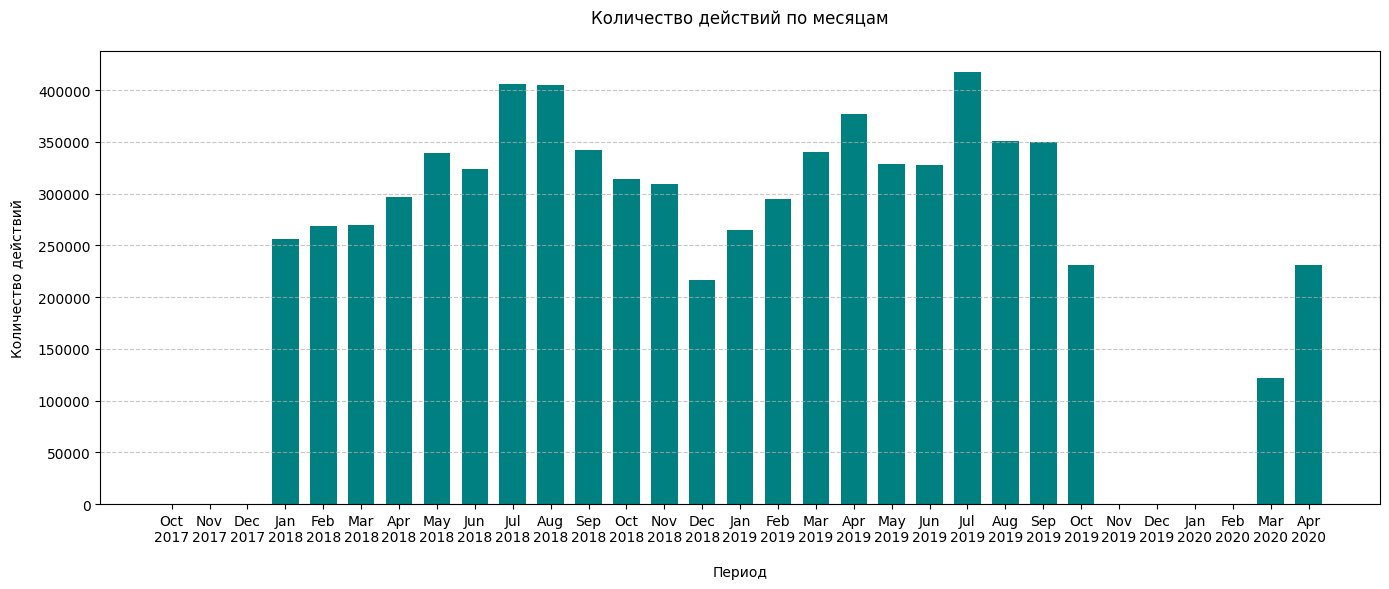

In [ ]:
# 1. Анализ по месяцам (если есть полные даты)
plt.figure(figsize=(14, 6))
monthly_data = df_without_nan.resample('M', on='action_datetime').size()

# Форматирование подписей
month_labels = [ts.strftime('%b\n%Y') for ts in monthly_data.index]

plt.bar(
    month_labels,
    monthly_data.values,
    color='teal',
    width=0.7
)

plt.title('Количество действий по месяцам', pad=20)
plt.xlabel('Период', labelpad=15)
plt.ylabel('Количество действий', labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод по графику**:
1. Период наблюдения = 2.3 года, а именно от января 2018 до Апреля 2020 года.
 2. Есть большой провал в данных. Данных о промежутке от Ноября 2019 до Февраль 2020 нет.
 3. На графику виден подъем по кол-ву действий по подбору персонала весной, а также виден спад осенью.

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


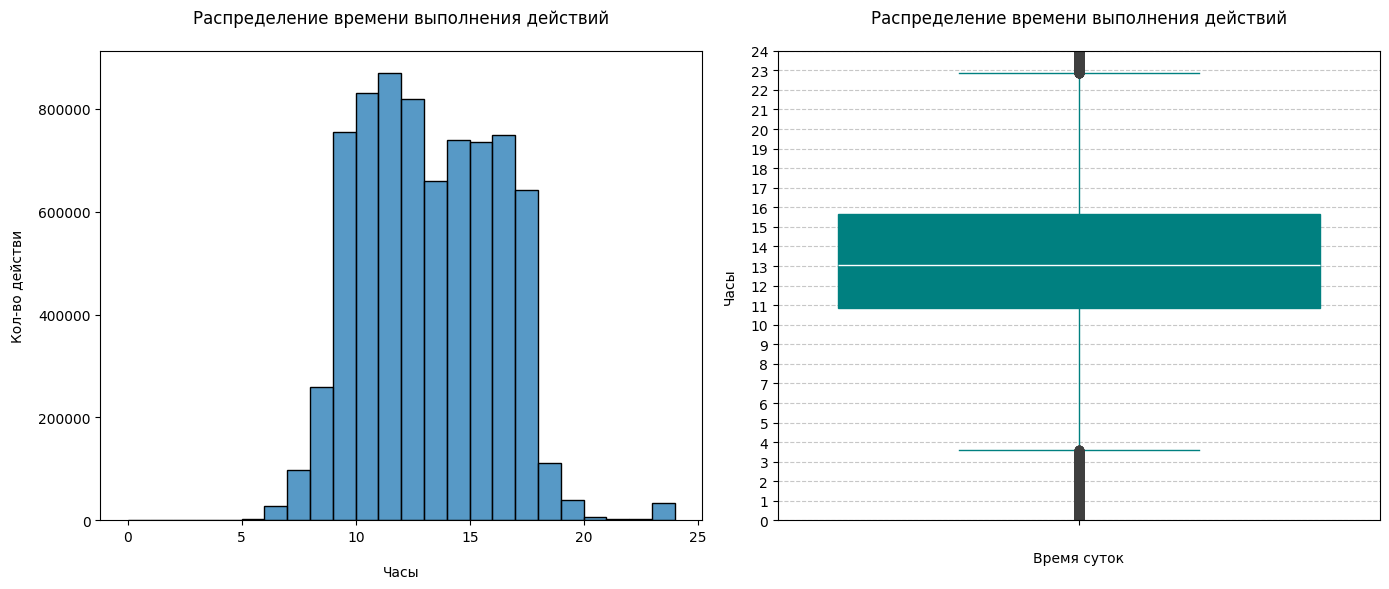

In [ ]:
plt.figure(figsize=(14, 6))

# Извлекаем часы и минуты из даты и переводим в числовой формат (часы + минуты/60)
time_data = df_without_nan['action_datetime'].dt.hour + df_without_nan['action_datetime'].dt.minute/60
plt.subplot(1, 2, 1)
sns.histplot(
    time_data,
    bins=24
)
plt.title('Распределение времени выполнения действий', pad=20)
plt.xlabel('Часы', labelpad=15)
plt.ylabel('Кол-во действи', labelpad=10)


plt.subplot(1, 2, 2)
# Создаем boxplot
sns.boxplot(
    time_data,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='teal', color='teal'),
    whiskerprops=dict(color='teal'),
    capprops=dict(color='teal'),
    medianprops=dict(color='white')
)

plt.title('Распределение времени выполнения действий', pad=20)
plt.xlabel('Время суток', labelpad=15)
plt.ylabel('Часы', labelpad=10)

# Настраиваем оси для отображения времени
plt.yticks(range(25))
plt.ylim(0, 24)

# Добавляем подписи для основных часов
hours = [f"{h}:00" for h in range(0, 25, 3)]
plt.yticklabels = hours

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

**Выводы по графику**:
1. Основные работы проводятся с 9 до 18 часов.
2. Есть переработки(возможные выбросы) по работам в промежутке с 23 часов вечера до 4 утра.

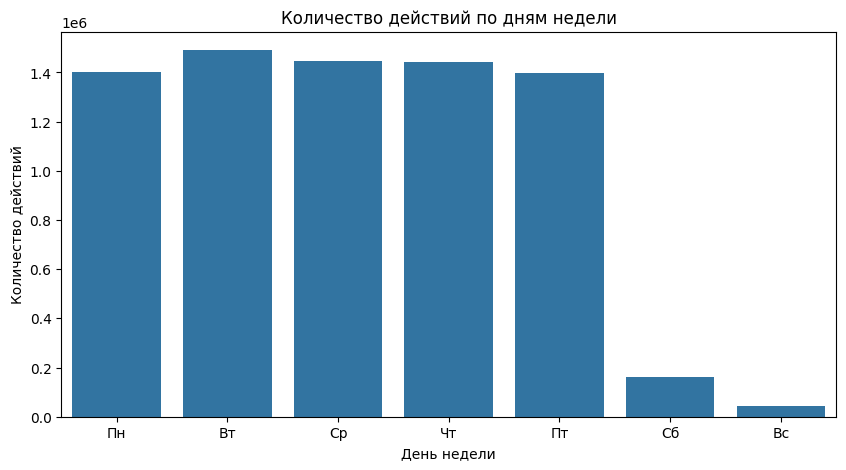

In [ ]:
plt.figure(figsize=(10, 5))

sns.countplot(x=df_without_nan['action_datetime'].dt.dayofweek)
plt.title('Количество действий по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество действий')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

In [ ]:
import plotly.express as px

stage_names = {
    'Групповое собеседование и тестирование': 'Груп. собеседование',
    'Интервью с руководителем': 'Интервью',
    'Назначение времени на оформление/медосмотр': 'Назначение времени'
}

stage_data = df_without_nan['stage_name'].replace(stage_names).value_counts()

df_stage_data = stage_data.reset_index()
df_stage_data.columns = ['stage', 'count']
df_stage_data = df_stage_data.sort_values(by='count', ascending=False)

# Строим воронку
fig = px.funnel(
    df_stage_data,
    x='count',
    y='stage',
    title='Воронка стадий',
    labels={'count': 'Количество', 'stage': 'Этап'},
    color_discrete_sequence=['#4B9AC7']
)

# Настраиваем отображение
fig.update_layout(
    font_family='Arial',
    height=600,
    hovermode='y unified'
)

fig.show()

![Воронка стадий](К3_Воронка_стадий_190425.png)

**Выводы по графику:**
1. По воронке стадий можно предположить, что основных стадий 4: Интервью с руководителем, Обработка, Служба безопасности, Оформление. Также часто появляется стадия назначение времени.

In [ ]:
grouped_table = df_without_nan.groupby(["stage_name", "activity_name", "result_name"]).size().reset_index(name="count")

In [ ]:
grouped_table[grouped_table['stage_name']=='Оформление']['activity_name'].unique()

array(['Назначить время на оформление',
       'Назначить время на оформление/медосмотр',
       'Назначить время на оформление/медосмотр (недозвон)',
       'Предоставить обратную связь по кандидату',
       'Узнать результаты медосмотра', 'Узнать результаты приема'],
      dtype=object)

In [ ]:
grouped_table[grouped_table['activity_name']=='Узнать результаты приема']

,stage_name,activity_name,result_name,count
1,Выход на работу,Узнать результаты приема,Принят,28
141,Ожидание,Узнать результаты приема,Оформление,2
190,Оформление,Узнать результаты приема,В ожидании,259401
191,Оформление,Узнать результаты приема,Время назначено,139
192,Оформление,Узнать результаты приема,Встреча назначена,2
193,Оформление,Узнать результаты приема,Назначить время на оформление/медосмотр,1
194,Оформление,Узнать результаты приема,Направлен на медосмотр,4
195,Оформление,Узнать результаты приема,Не принят,3406
196,Оформление,Узнать результаты приема,Недозвон,17328
197,Оформление,Узнать результаты приема,Нет обратной связи,1


### Анализ действий по 4 основным этап

In [ ]:
grouped_table[grouped_table['stage_name']=='Интервью с руководителем'].nlargest(10, 'count')

,stage_name,activity_name,result_name,count
13,Интервью с руководителем,Назначить интервью с руководителем,Встреча назначена,945151
40,Интервью с руководителем,Узнать результаты интервью с руководителем,Нет обратной связи,480816
50,Интервью с руководителем,Узнать результаты интервью с руководителем,Подходит,456760
44,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,204859
47,Интервью с руководителем,Узнать результаты интервью с руководителем,Перенос кандидата,93385
39,Интервью с руководителем,Узнать результаты интервью с руководителем,Недозвон,70905
20,Интервью с руководителем,Назначить интервью с руководителем,Отказ кандидата,59821
25,Интервью с руководителем,Назначить интервью с руководителем,Резерв,29875
17,Интервью с руководителем,Назначить интервью с руководителем,Нет обратной связи,23809
51,Интервью с руководителем,Узнать результаты интервью с руководителем,Резерв,23798


In [ ]:
grouped_table[grouped_table['stage_name']=='Оформление'].nlargest(10, 'count')

,stage_name,activity_name,result_name,count
190,Оформление,Узнать результаты приема,В ожидании,259401
208,Оформление,Узнать результаты приема,Принят,159575
151,Оформление,Назначить время на оформление/медосмотр,Время назначено,103224
156,Оформление,Назначить время на оформление/медосмотр,Недозвон,95739
202,Оформление,Узнать результаты приема,Отказ кандидата,49782
177,Оформление,Предоставить обратную связь по кандидату,ОС не предоставлена руководителем,24162
201,Оформление,Узнать результаты приема,Ожидание,19570
196,Оформление,Узнать результаты приема,Недозвон,17328
168,Оформление,Назначить время на оформление/медосмотр (недоз...,Недозвон,15974
142,Оформление,Назначить время на оформление,Время назначено,12083


In [ ]:
grouped_table[grouped_table['stage_name']=='СБ'].nlargest(10, 'count')

,stage_name,activity_name,result_name,count
218,СБ,Подготовить анкету кандидата,Подготовлена,456746
239,СБ,Узнать результаты СБ,Подходит,376007
226,СБ,Проверка формы обращения,Не резерв,186888
231,СБ,Узнать результаты СБ,Не подходит,79494
233,СБ,Узнать результаты СБ,Нет обратной связи,9342
242,СБ,Узнать результаты СБ,Согласование повторного приема,1600
224,СБ,Получить согласование повторного приема и отпр...,Получено,1543
243,СБ,Узнать результаты СБ,Уточнение данных,883
238,СБ,Узнать результаты СБ,Подготовлена,558
211,СБ,Подготовить анкету кандидата,Встреча назначена,390


In [ ]:
grouped_table[grouped_table['stage_name']=='Обработка'].nlargest(10, 'count')

,stage_name,activity_name,result_name,count
114,Обработка,Провести первичную обработку,Подходит,921382
100,Обработка,Проверка формы обращения,Не резерв,452938
107,Обработка,Провести первичную обработку,Недозвон,251798
111,Обработка,Провести первичную обработку,Отказ кандидата,171553
97,Обработка,Проверка источника,Источник не Яндекс Цифра,106819
106,Обработка,Провести первичную обработку,Не подходит,64116
115,Обработка,Провести первичную обработку,Резерв,48026
112,Обработка,Провести первичную обработку,Перенос звонка,10387
110,Обработка,Провести первичную обработку,Ожидание,6328
99,Обработка,Проверка формы обращения,Кадровый резерв,393


In [ ]:
grouped_table[grouped_table['stage_name']=='Ожидание'].nlargest(10, 'count')

,stage_name,activity_name,result_name,count
122,Ожидание,Вернуть в воронку,Интервью с руководителем,7190
123,Ожидание,Вернуть в воронку,Назначить время на оформление/медосмотр,5607
131,Ожидание,Вернуть в воронку,Оформление,5390
127,Ожидание,Вернуть в воронку,Обработка,3064
132,Ожидание,Вернуть в воронку,Подходит,1124
135,Ожидание,Вернуть в воронку,СБ,456
128,Ожидание,Вернуть в воронку,Ожидание,21
125,Ожидание,Вернуть в воронку,Недозвон,16
126,Ожидание,Вернуть в воронку,Нет обратной связи,11
119,Ожидание,Вернуть в воронку,В ожидании,9


Условие, что кандидат принят на работу:

In [ ]:
grouped_table[(grouped_table['activity_name']=='Узнать результаты приема')
              & (grouped_table['result_name']=='Принят')]

,stage_name,activity_name,result_name,count
1,Выход на работу,Узнать результаты приема,Принят,28
208,Оформление,Узнать результаты приема,Принят,159575


## Анализ последних действий

In [ ]:
last_actions = df_without_nan.loc[df_without_nan.groupby("id_applicant")["action_datetime"].idxmax()]

last_actions_group = last_actions.groupby(["stage_name", "activity_name", "result_name"]).size().reset_index(name="count")

In [ ]:
last_actions_group_sorted = last_actions_group.sort_values("count", ascending=False)

last_actions_group_sorted.head(30)

,stage_name,activity_name,result_name,count
24,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,196006
65,Обработка,Провести первичную обработку,Отказ кандидата,168124
118,Оформление,Узнать результаты приема,Принят,157862
129,СБ,Узнать результаты СБ,Не подходит,74779
62,Обработка,Провести первичную обработку,Не подходит,63191
10,Интервью с руководителем,Назначить интервью с руководителем,Отказ кандидата,56103
116,Оформление,Узнать результаты приема,Отказ кандидата,42031
44,Назначение времени на оформление/медосмотр,Назначить время на оформление/медосмотр (недоз...,Отказ кандидата,38976
68,Обработка,Провести первичную обработку,Резерв,38735
13,Интервью с руководителем,Назначить интервью с руководителем,Резерв,22594


In [ ]:
last_actions_group_result = last_actions.groupby(["result_name"]).size().reset_index(name="count")

last_actions_group_result_sorted = last_actions_group_result.sort_values("count", ascending=False)

last_actions_group_result_sorted

,result_name,count
23,Отказ кандидата,527450
31,Принят,157934
13,Не подходит,150643
32,Резерв,92224
16,Недозвон,17301
4,Встреча назначена,15527
22,Ожидание,11861
3,Время назначено,5712
17,Нет обратной связи,5677
24,Отказ руководителя,3278


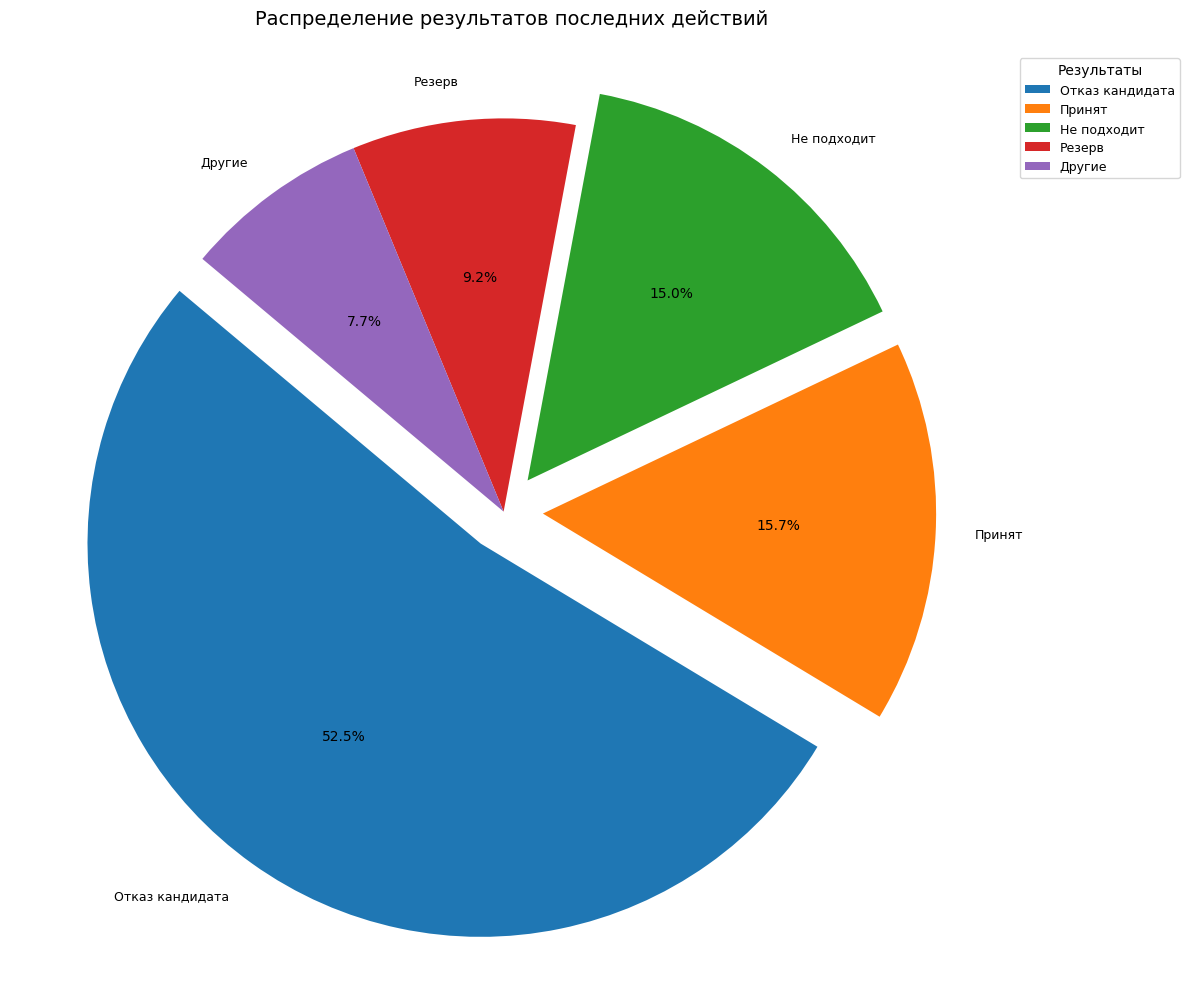

In [ ]:
# Вычисляем общую сумму и процент для каждой категории
total = last_actions_group_result_sorted['count'].sum()
last_actions_group_result_sorted['percentage'] = last_actions_group_result_sorted['count'] / total * 100

# Определяем порог для группировки (2%)
threshold = 2.0

# Создаем отдельные DataFrames для основных и мелких категорий
main_categories = last_actions_group_result_sorted[last_actions_group_result_sorted['percentage'] >= threshold]
other_categories = last_actions_group_result_sorted[last_actions_group_result_sorted['percentage'] < threshold]

# Суммируем мелкие категории в одну "Другие"
other_sum = other_categories['count'].sum()
other_percentage = other_categories['percentage'].sum()

if not other_categories.empty:
    other_row = pd.DataFrame({
        'result_name': ['Другие'],
        'count': [other_sum],
        'percentage': [other_percentage]
    })
    final_df = pd.concat([main_categories, other_row])
else:
    final_df = main_categories

# Сортируем данные по убыванию количества
final_df = final_df.sort_values('count', ascending=False)

# Создаем круговую диаграмму
plt.figure(figsize=(12, 10))

# Используем explode для выделения крупных сегментов
explode = [0.1 if x > 100000 else 0 for x in final_df['count']]

# Функция для отображения подписей только для крупных сегментов
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= threshold else ''

# Создаем диаграмму
patches, texts, autotexts = plt.pie(
    final_df['count'],
    labels=final_df['result_name'],
    autopct=custom_autopct,
    startangle=140,
    explode=explode,
    # pctdistance=0.85,
    textprops={'fontsize': 10}
)

# Уменьшаем размер шрифта для длинных меток и скрываем для мелких сегментов
for text, pct in zip(texts, final_df['percentage']):
    if pct < threshold:
        text.set_visible(False)
    else:
        text.set_fontsize(9)

# Добавляем заголовок
plt.title('Распределение результатов последних действий',
          fontsize=14, pad=20)

# Добавляем легенду справа от диаграммы
plt.legend(
    patches,
    final_df['result_name'],
    title="Результаты",
    loc="upper left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=9
)

# Убедимся, что диаграмма отображается как круг
plt.axis('equal')

plt.tight_layout()
plt.show()

**Выводы по таблице:**
1. Самая частая причина не найма кандидата, это отказ самого кандидата(в 3.5 раза больше от следующей причины). В дальнейшем анализе нужно будет узнать, почему так происходить.

## Анализ первых действий

In [ ]:
first_actions = df_without_nan.loc[df_without_nan.groupby("id_applicant")["action_datetime"].idxmin()]

first_actions_group = first_actions.groupby(["activity_name"]).size().reset_index(name="count")

first_actions_group_sorted = first_actions_group.sort_values("count", ascending=False)

first_actions_group_sorted

,activity_name,count
9,Провести первичную обработку,1212970
11,Узнать результаты интервью с руководителем,7714
5,Назначить интервью с руководителем,2949
13,Узнать результаты приема,2919
1,Вывести из черного списка,2569
2,Назначить время на оформление,1912
7,Предоставить обратную связь по кандидату,1843
4,Назначить время на оформление/медосмотр (недоз...,877
3,Назначить время на оформление/медосмотр,813
10,Узнать результаты СБ,674


In [ ]:
df_first_black_list = first_actions[first_actions['result_name']=='В белый список']
df_last_black_list = last_actions[last_actions['result_name']=='Черный список']

merged_df = df_first_black_list.merge(
    df_last_black_list,
    on='id_partner',
    how='inner'
)
merged_df

,id_applicant_x,id_partner,id_log_x,department_id_x,action_date_x,stage_name_x,activity_name_x,result_name_x,position_name_x,is_active_action_x,...,id_log_y,department_id_y,action_date_y,stage_name_y,activity_name_y,result_name_y,position_name_y,is_active_action_y,is_open_action_y,action_datetime_y


**Вывод по таблице:**
 1. По таблице можно предположить, что стандартное первое действие по найму кандидата это проведение первичной обработки, что весьма логично.
 2. Также видим, что в первых действиях есть действия, которые предпологаю начатое или законченое действие перед ним.

## Анализ данных без времени

In [ ]:
df_with_nan_action_date = df_with_nan.groupby(['stage_name']).size().reset_index(name="count")

df_with_nan_action_date

,stage_name,count
0,Интервью с руководителем,11580
1,Не прошел СБ,5288
2,Обработка,570
3,Оформление,5956
4,СБ,322
5,Создание кандидата,1734982
6,Черный список,54


**Вывод по таблице:**
1. Самое частое действие, в котором не проставлено время - "Смена вакансий". Скорее всего оно в одно действие и внутри компании, что не отображает работу найма.
2. А вот остальные должны были быть в каком-то определенном процессе найма и в них должна быть проставлена дата.

In [ ]:
df_with_nan_maybe_last = df_with_nan[df_with_nan['stage_name'].isin([
    'Выход на работу',
    'Кадровый резерв',
    'Мы отказали',
    'Отказался',
    'Резерв',
    'Черный список',
    'Выход состоялся'
])].copy()

merged_df_last = last_actions.merge(
    df_with_nan,
    how='inner',
    on='id_applicant'
)

merged_df_last

,id_applicant,id_partner_x,id_log_x,department_id_x,action_date_x,stage_name_x,activity_name_x,result_name_x,position_name_x,is_active_action_x,...,id_partner_y,id_log_y,department_id_y,action_date_y,stage_name_y,activity_name_y,result_name_y,position_name_y,is_active_action_y,is_open_action_y
0,2196747,2314693,10952866,12252,2018-01-11 09:51:21.213384+00:00,Оформление,Узнать результаты приема,Принят,Продавец-кассир,True,...,2314693,-1,12252,2018-01-05 06:37:54.019063+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
1,2196748,2346300,11375194,5760,2018-02-02 12:41:49.992103+00:00,Оформление,Узнать результаты приема,Принят,Продавец-кассир,True,...,2346300,-1,5760,2018-01-05 06:39:55.362530+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
2,2196749,2393457,10902837,7725,2018-01-09 12:08:49.403721+00:00,СБ,Узнать результаты СБ,Не подходит,Продавец-кассир,True,...,2393457,-1,7725,2018-01-05 06:43:55.994558+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
3,2196750,2393755,10894248,22422,2018-01-09 09:27:48.109532+00:00,СБ,Узнать результаты СБ,Не подходит,Продавец-кассир,True,...,2393755,-1,22422,2018-01-05 06:45:01.945835+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
4,2196751,2393756,10936964,19165,2018-01-10 14:15:29.296465+00:00,Назначение времени на оформление/медосмотр,Назначить время на оформление/медосмотр (недоз...,Отказ кандидата,Продавец-кассир,True,...,2393756,-1,19165,2018-01-05 06:47:01.920732+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262783,4886612,3897226,27106020,32875,2020-04-14 11:09:08.379094+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,...,3897226,-1,32875,2020-04-14 11:08:32.457218+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
1262784,4886612,3897226,27106020,32875,2020-04-14 11:09:08.379094+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,True,...,3897226,-1,32875,2020-04-23 16:26:11.809180+00:00,СБ,Узнать результаты СБ,NaN,Продавец-кассир,True,True
1262785,4886613,3895670,27106010,8377,2020-04-14 11:08:58.217121+00:00,Интервью с руководителем,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,...,3895670,-1,8377,2020-04-14 11:08:35.586032+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,True,False
1262786,4886613,3895670,27106010,8377,2020-04-14 11:08:58.217121+00:00,Интервью с руководителем,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,True,...,3895670,-1,8377,2020-04-23 16:26:11.809180+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,NaN,Продавец-кассир,True,True


In [ ]:
merged_df_last = merged_df_last[merged_df_last['is_active_action_y']==True]
merged_df_last_group = merged_df_last.groupby(['stage_name_x', 'activity_name_x', 'result_name_x', 'stage_name_y']).size().reset_index(name="count")
merged_df_last_group.nlargest(30, 'count')

,stage_name_x,activity_name_x,result_name_x,stage_name_y,count
32,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,Создание кандидата,195999
80,Обработка,Провести первичную обработку,Отказ кандидата,Создание кандидата,168121
145,Оформление,Узнать результаты приема,Принят,Создание кандидата,157861
160,СБ,Узнать результаты СБ,Не подходит,Создание кандидата,74777
76,Обработка,Провести первичную обработку,Не подходит,Создание кандидата,63186
12,Интервью с руководителем,Назначить интервью с руководителем,Отказ кандидата,Создание кандидата,56100
142,Оформление,Узнать результаты приема,Отказ кандидата,Создание кандидата,42030
57,Назначение времени на оформление/медосмотр,Назначить время на оформление/медосмотр (недоз...,Отказ кандидата,Создание кандидата,38976
84,Обработка,Провести первичную обработку,Резерв,Создание кандидата,38729
17,Интервью с руководителем,Назначить интервью с руководителем,Резерв,Создание кандидата,22594


In [ ]:
merged_df_last_group_not_change = merged_df_last_group[merged_df_last_group['stage_name_y']!='Смена вакансии']
merged_df_last_group_not_change.nlargest(30, 'count')

,stage_name_x,activity_name_x,result_name_x,stage_name_y,count
32,Интервью с руководителем,Узнать результаты интервью с руководителем,Отказ кандидата,Создание кандидата,195999
80,Обработка,Провести первичную обработку,Отказ кандидата,Создание кандидата,168121
145,Оформление,Узнать результаты приема,Принят,Создание кандидата,157861
160,СБ,Узнать результаты СБ,Не подходит,Создание кандидата,74777
76,Обработка,Провести первичную обработку,Не подходит,Создание кандидата,63186
12,Интервью с руководителем,Назначить интервью с руководителем,Отказ кандидата,Создание кандидата,56100
142,Оформление,Узнать результаты приема,Отказ кандидата,Создание кандидата,42030
57,Назначение времени на оформление/медосмотр,Назначить время на оформление/медосмотр (недоз...,Отказ кандидата,Создание кандидата,38976
84,Обработка,Провести первичную обработку,Резерв,Создание кандидата,38729
17,Интервью с руководителем,Назначить интервью с руководителем,Резерв,Создание кандидата,22594


In [ ]:
merged_df_first = first_actions.merge(
    df_with_nan,
    how='inner',
    on='id_applicant'
)

merged_df_first = merged_df_first[merged_df_first['is_active_action_y']==True]
merged_df_first_group = merged_df_first.groupby(['stage_name_x', 'activity_name_x', 'result_name_x', 'stage_name_y']).size().reset_index(name="count")
merged_df_first_group.nlargest(30, 'count')

,stage_name_x,activity_name_x,result_name_x,stage_name_y,count
94,Обработка,Провести первичную обработку,Подходит,Создание кандидата,899749
80,Обработка,Провести первичную обработку,Недозвон,Создание кандидата,131918
83,Обработка,Провести первичную обработку,Отказ кандидата,Создание кандидата,65100
76,Обработка,Провести первичную обработку,Не подходит,Создание кандидата,58849
99,Обработка,Провести первичную обработку,Резерв,Создание кандидата,43936
89,Обработка,Провести первичную обработку,Подходит,Интервью с руководителем,11199
88,Обработка,Провести первичную обработку,Перенос звонка,Создание кандидата,7748
92,Обработка,Провести первичную обработку,Подходит,Оформление,5245
81,Обработка,Провести первичную обработку,Ожидание,Создание кандидата,5085
72,Не прошел СБ,Вывести из черного списка,В белый список,Создание кандидата,2569


## Анализ по департаментам

In [ ]:
search_departments = (
    df_without_nan.drop_duplicates(['department_id', 'id_applicant'])
    .groupby('department_id').size()
    .reset_index(name='unique_candidates_searched')
)

In [ ]:
accepted_candidates = df_without_nan[
    (df_without_nan['activity_name'] == 'Узнать результаты приема')
    & (df_without_nan['result_name'] == 'Принят')
].drop_duplicates(['department_id', 'id_applicant'])

accept_departments = (
    accepted_candidates.groupby('department_id').size()
    .reset_index(name='unique_candidates_accepted')
)

In [ ]:
department_stats = (
    df_without_nan.drop_duplicates(['department_id', 'id_applicant'])
    .groupby('department_id').size()
    .reset_index(name='total_unique_candidates')
    .merge(
        accepted_candidates.groupby('department_id').size().reset_index(name='accepted_unique'),
        on='department_id',
        how='left'
    )
)

department_stats['acceptance_ratio'] = (
    department_stats['accepted_unique'] / department_stats['total_unique_candidates']
)

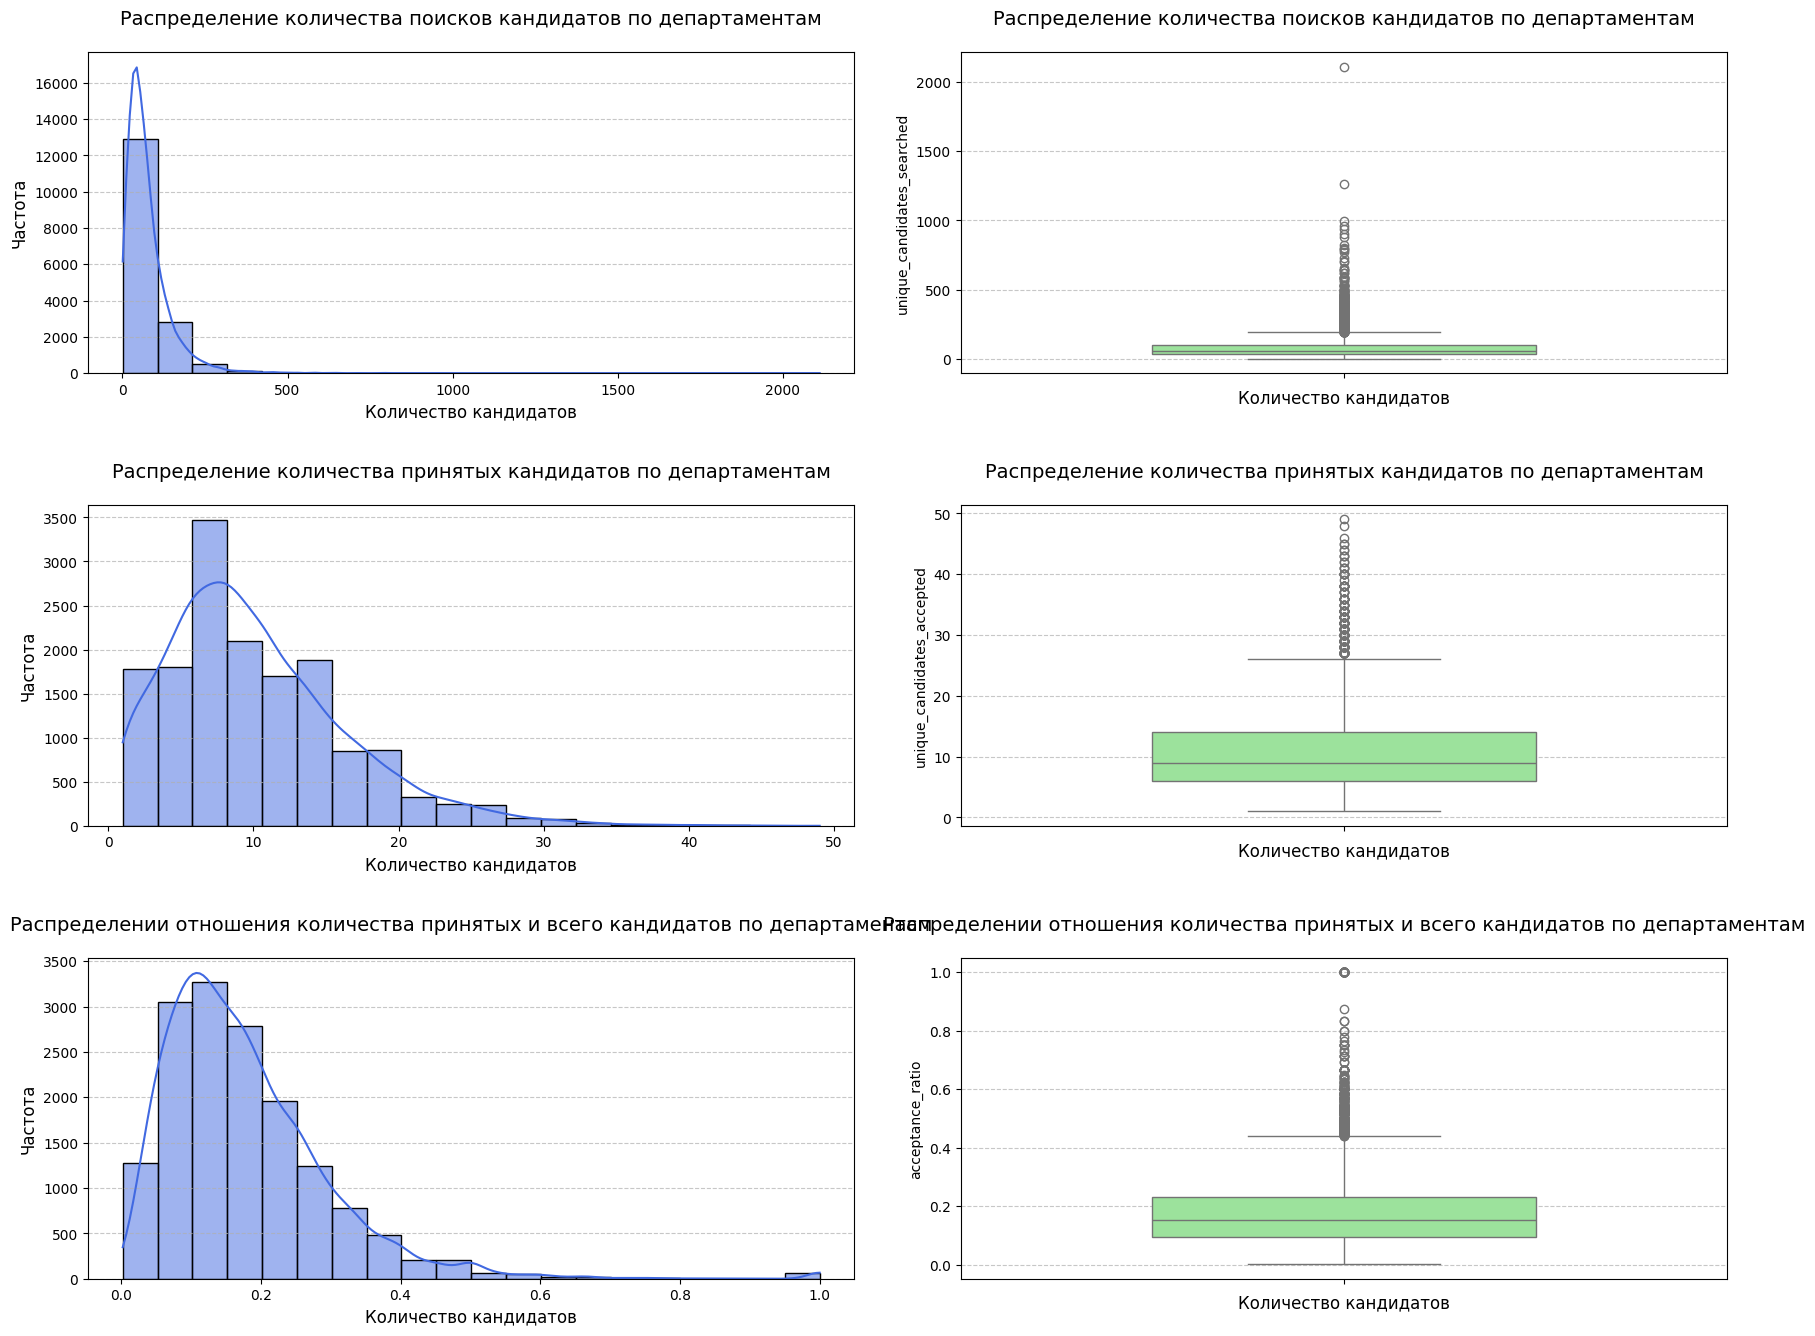

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаём фигуру с тремя субплoтами
import matplotlib.pyplot as plt
import seaborn as sns

def print_hist_box_plot(df, x = None, num = 1, title = 'Распределение количества кандидатов по департаментам', bins = 20, xlabel = 'Количество кандидатов'):
    plt.subplot(3, 2, num)
    ax1 = sns.histplot(
        data=df,
        x=x,
        bins=bins,
        color='royalblue',
        kde=True
    )
    plt.title(title, pad=20, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(3, 2, num+1)
    ax2 = sns.boxplot(
        data=df,
        y=x,
        color='lightgreen',
        width=0.5
    )
    plt.title(title, pad=20, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


# Создаём фигуру с тремя субплoтами
plt.figure(figsize=(18, 14))


print_hist_box_plot(search_departments, x = 'unique_candidates_searched', num = 1, title='Распределение количества поисков кандидатов по департаментам')
print_hist_box_plot(accept_departments, x = 'unique_candidates_accepted', num = 3, title='Распределение количества принятых кандидатов по департаментам')
print_hist_box_plot(department_stats, x = 'acceptance_ratio', num = 5, title = 'Распределении отношения количества принятых и всего кандидатов по департаментам')

plt.tight_layout(pad=3.0)  # Автоматическое расстояние между графиками
plt.show()


In [ ]:
search_departments.nlargest(1, 'unique_candidates_searched')

,department_id,unique_candidates_searched
2516,8358,2111


**Результаты по департаментам**:
1. В основном департаменты обрабатывают меньше сотки кандидатов за два с лишним года, и медиана принятых равна 9. То есть в среднем принимают от 10-20%.
2. Также есть предприятия, которые отличились. Например департамент с id равным 8358 обработал 2107 заявок.

In [ ]:
print(len(df_without_nan['id_partner'].unique()))
print(len(df_without_nan['id_applicant'].unique()))
print(len(df_without_nan['department_id'].unique()))

876884
1242767
16423


## Анализ по кандидатам

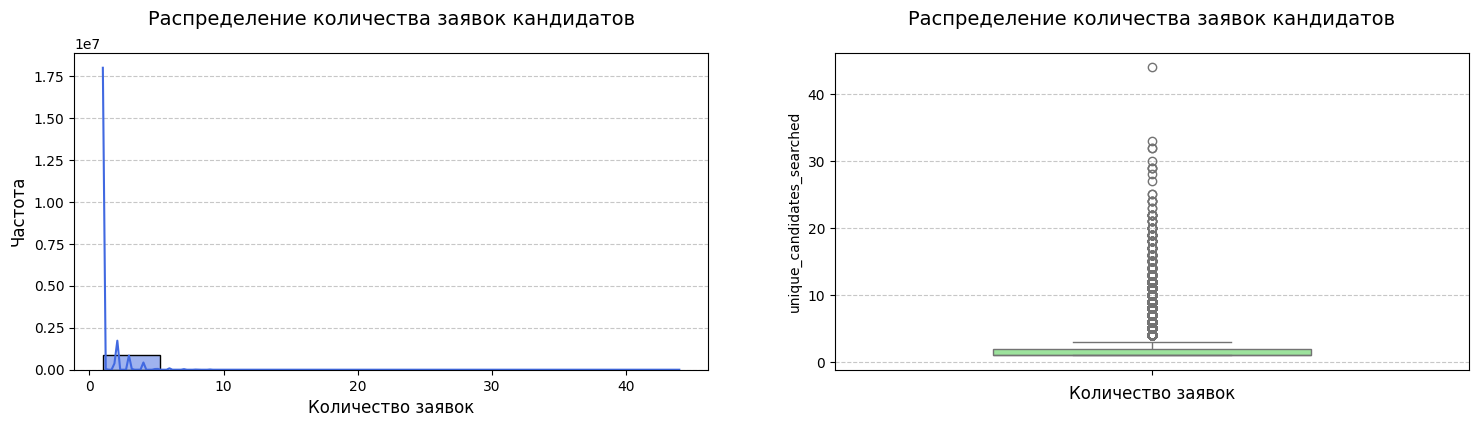

In [ ]:
search_partner = (
    df_without_nan.drop_duplicates(['id_partner', 'id_applicant'])
    .groupby('id_partner').size()
    .reset_index(name='unique_candidates_searched')
)

plt.figure(figsize=(18, 14))


print_hist_box_plot(search_partner, x = 'unique_candidates_searched', num = 1, title='Распределение количества заявок кандидатов', bins=10, xlabel='Количество заявок')

In [ ]:
search_partner[search_partner['unique_candidates_searched']>40]

,id_partner,unique_candidates_searched
264308,2596099,44


In [ ]:
search_partner[(search_partner['unique_candidates_searched']<=5) & (search_partner['unique_candidates_searched']>=3)]

,id_partner,unique_candidates_searched
11,530595,4
33,530987,3
49,531330,4
52,531348,3
53,531390,5
...,...,...
875483,3894806,3
875786,3895381,3
875907,3895605,4
876417,3896441,4


In [ ]:
df_parther530987 = df_without_nan[df_without_nan['id_partner']==530987]

df_parther530987.sort_values(by='action_date')

df_parther530987.to_csv("df_parther530987.csv", index=False)

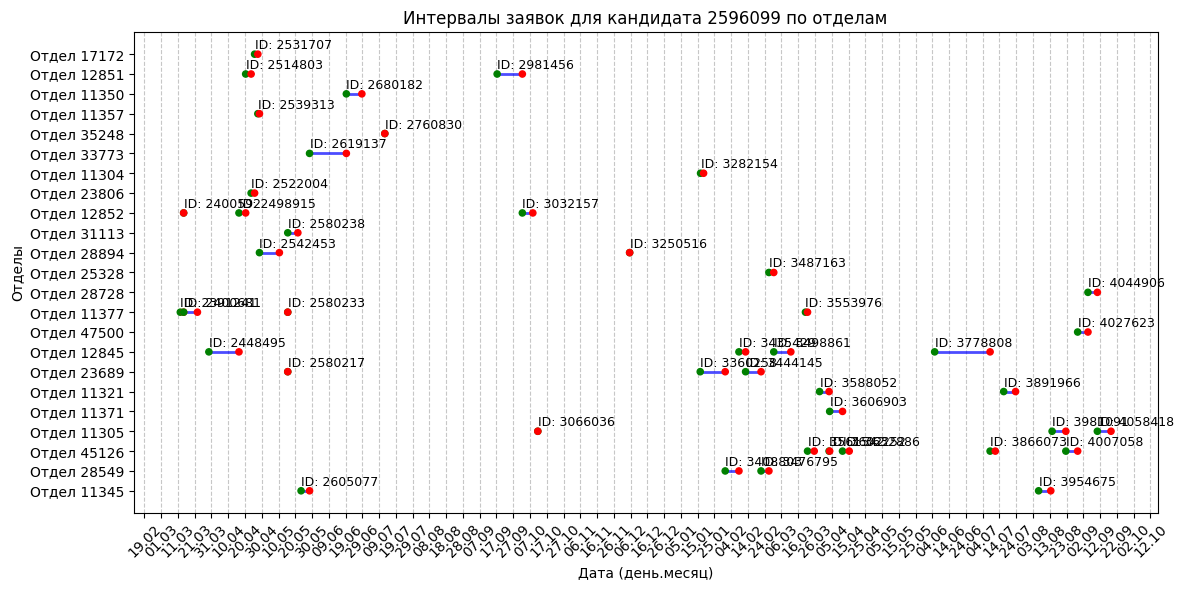

In [ ]:
import matplotlib.dates as mdates

candidate_id = 2596099
df_parther2596099 = df_without_nan[df_without_nan['id_partner']==2596099]

candidate_data = df_parther2596099.copy()

# Преобразуем department_id в строки для лучшей читаемости
candidate_data['department'] = 'Отдел ' + candidate_data['department_id'].astype(str)

# Создадим график
plt.figure(figsize=(12, 6))

# Для каждого отдела будем использовать свою горизонтальную линию
departments = candidate_data['department'].unique()
y_positions = range(len(departments))
department_to_y = {dept: y for dept, y in zip(departments, y_positions)}

# Настроим ось Y
plt.yticks(y_positions, departments)
plt.ylabel('Отделы')

# Улучшенная настройка оси X (даты)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))  # Формат "день.месяц"
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))   # Метка каждый день
plt.xticks(rotation=45)  # Наклон подписей 45 градусов
plt.xlabel('Дата (день.месяц)')

# Группируем по id_applicant и department
grouped = candidate_data.groupby(['id_applicant', 'department'])

# Для каждой группы рисуем интервал между первой и последней заявкой
for (applicant, dept), group in grouped:
    if not group.empty:
        start_date = group['action_datetime'].min()
        end_date = group['action_datetime'].max()
        y_pos = department_to_y[dept]

        # Рисуем линию интервала
        plt.hlines(y=y_pos, xmin=start_date, xmax=end_date,
                  colors='blue', lw=2, alpha=0.7)

        # Выделяем первую и последнюю заявку специальными маркерами
        plt.scatter([start_date, end_date], [y_pos, y_pos],
                   color=['green', 'red'], s=20, zorder=4,
                   label=['Первая заявка', 'Последняя заявка'])

        # Подпись с id заявки
        plt.text(start_date, y_pos+0.1, f'ID: {applicant}',
                fontsize=9, ha='left', va='bottom')


plt.title(f'Интервалы заявок для кандидата {candidate_id} по отделам')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Расчет метрики TTH(Time to hire)

In [ ]:
def calculate_tth(df: pd.DataFrame) -> (pd.DataFrame, float):
    tth_data = []

    grouped = df.groupby('id_applicant')
    for applicant_id, group in grouped:
        sorted_group = group.sort_values('action_date')

        offer_mask = (
            (sorted_group['stage_name'] == 'Оформление') &
            (sorted_group['result_name'] == 'Принят')
        )
        offer_events = sorted_group[offer_mask]

        if not offer_events.empty:
            offer_date = offer_events['action_date'].iloc[0]
            start_date = sorted_group['action_date'].min()
            tth_days = (offer_date - start_date).days

            tth_data.append({
                'applicant_id': applicant_id,
                'start_date': start_date,
                'end_date': offer_date,
                'TTH_days': tth_days,
                'actions_count': len(sorted_group),
                'first_stage': sorted_group['stage_name'].iloc[0],
                'last_stage': 'Offer Accepted'
            })

    temp_df = pd.DataFrame(tth_data)
    if temp_df.empty:
        return pd.DataFrame(), pd.DataFrame(), 0.0

    Q1 = temp_df['TTH_days'].quantile(0.25)
    Q3 = temp_df['TTH_days'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = max(Q3 + 1.5 * IQR, 90)

    filtered_df = temp_df[temp_df['TTH_days'] <= upper_bound]

    return filtered_df, temp_df, upper_bound

In [ ]:
def print_tth(df):
    df['action_date'] = pd.to_datetime(
    df['action_date'],
    format='ISO8601',
    errors='coerce',
    utc=True
)

    tth_df, full_tth_df, upper_bound = calculate_tth(df)

    if not tth_df.empty:
        import matplotlib.pyplot as plt
        import seaborn as sns

        plt.figure(figsize=(15, 8))

        ax = sns.histplot(tth_df['TTH_days'], bins=30, kde=True, color='teal')
        plt.title('Распределение Time to Hire для продавцов-кассиров\n', fontsize=14)
        plt.xlabel('Длительность найма (дни)', fontsize=12)
        plt.ylabel('Частота', fontsize=12)
        plt.grid(axis='y', alpha=0.75)

        median = tth_df['TTH_days'].median()
        mean = tth_df['TTH_days'].mean()
        plt.axvline(median, color='red', linestyle='--', label=f'Медиана: {median} дн.')
        plt.axvline(mean, color='green', linestyle='--', label=f'Среднее: {mean:.1f} дн.')
        plt.axvline(upper_bound, color='purple', linestyle=':',
                   label=f'Верхняя граница ({upper_bound:.1f} дн.)')

        plt.legend()
        plt.show()

        # Анализ выбросов
        outliers = full_tth_df[full_tth_df['TTH_days'] > upper_bound]
        print(f"\nОбнаружено выбросов (TTH > {upper_bound:.1f} дней): {len(outliers)}")
        if not outliers.empty:
            print("\nРаспределение выбросов по начальным этапам:")
            print(outliers['first_stage'].value_counts())

        from scipy import stats
        print("\nРасширенная статистика TTH:")
        print(f"• 95% доверительный интервал: {stats.t.interval(0.95, len(tth_df)-1, loc=mean, scale=stats.sem(tth_df['TTH_days']))}")
        print(f"• Коэффициент вариации: {stats.variation(tth_df['TTH_days']):.2%}")
        print(f"• Асимметрия распределения: {stats.skew(tth_df['TTH_days']):.2f}")

        stage_analysis_first = tth_df.groupby('first_stage')['TTH_days'].agg(['mean', 'median', 'count'])
        print("\nАнализ по начальным этапам:")
        print(stage_analysis_first.sort_values('mean', ascending=False))

        stage_analysis_last = tth_df.groupby('last_stage')['TTH_days'].agg(['mean', 'median', 'count'])
        print("\nАнализ по конечным этапам:")
        print(stage_analysis_last.sort_values('mean', ascending=False))

        reserve_candidates = df[df['stage_name'] == 'Кадровый резерв']
        if not reserve_candidates.empty:
            reserve_time = reserve_candidates.groupby('id_applicant')['action_date'].agg(lambda x: (x.max() - x.min()).days)
            print("\nКандидаты в кадровом резерве:")
            print(f"• Среднее время в резерве: {reserve_time.mean():.1f} дней")
            print(f"• Максимальное время в резерве: {reserve_time.max()} дней")

    else:
        print("\nПредупреждение: Не удалось рассчитать TTH - недостаточно данных после фильтрации!")

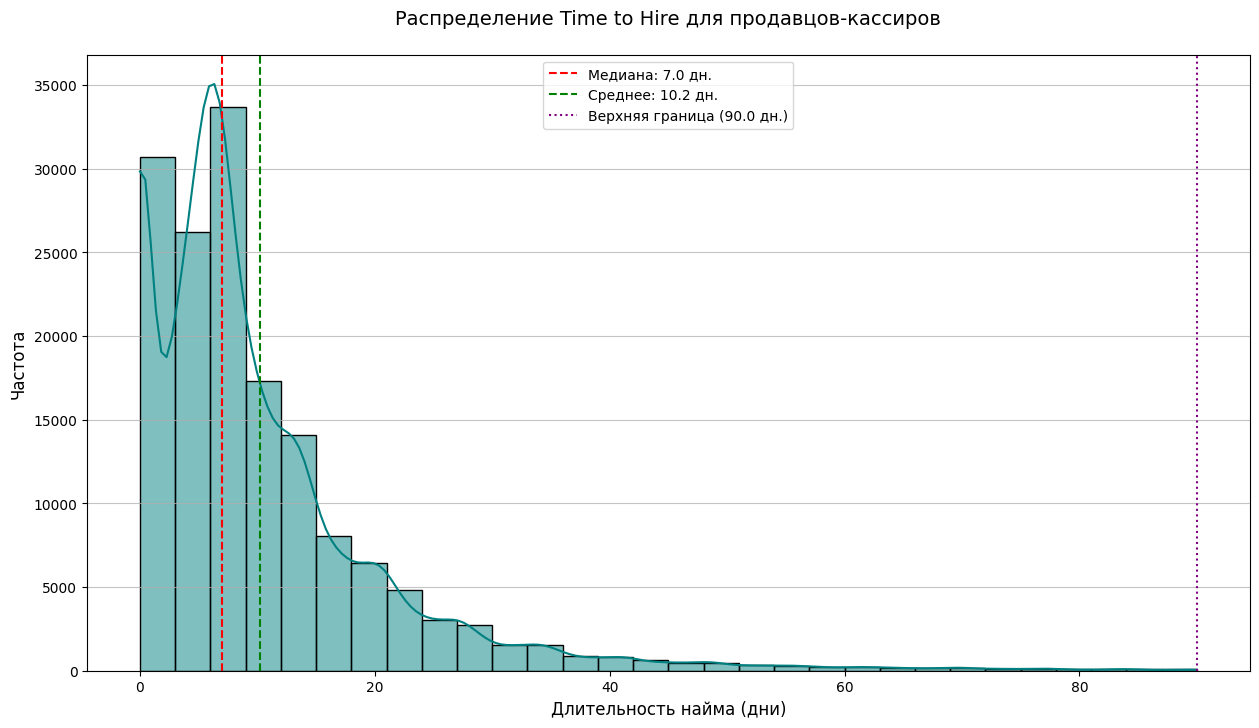


Обнаружено выбросов (TTH > 90.0 дней): 1647

Распределение выбросов по начальным этапам:
first_stage
Обработка                   1622
Интервью с руководителем      15
СБ                             7
Оформление                     2
Смена вакансии                 1
Name: count, dtype: int64

Расширенная статистика TTH:
• 95% доверительный интервал: (np.float64(10.169660782885696), np.float64(10.278922452440554))
• Коэффициент вариации: 107.54%
• Асимметрия распределения: 2.56

Анализ по начальным этапам:
                                                 mean  median   count
first_stage                                                          
Смена вакансии                              20.000000    20.0       1
СБ                                          13.759542     9.0     262
Интервью с руководителем                    12.051502     9.0     466
Обработка                                   10.309270     7.0  151722
Оформление                                   6.185407     4.0    2508

In [ ]:
print_tth(df_without_nan)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_tth(df: pd.DataFrame) -> pd.DataFrame:
    tth_data = []

    grouped = df.groupby('id_applicant')
    for applicant_id, group in grouped:
        sorted_group = group.sort_values('action_date')

        if (len(sorted_group) >= 2
            and sorted_group['result_name'].iloc[-1] == 'Принят'
            and sorted_group['activity_name'].iloc[-1] == 'Узнать результаты приема'):

            start_date = sorted_group['action_date'].min()
            end_date = sorted_group['action_date'].max()

            if pd.isnull(start_date) or pd.isnull(end_date):
                continue

            tth_days = (end_date - start_date).days

            tth_data.append({
                'applicant_id': applicant_id,
                'start_date': start_date,
                'end_date': end_date,
                'TTH_days': tth_days,
                'actions_count': len(sorted_group),
                'first_stage': sorted_group['stage_name'].iloc[0],
                'stage_changes': sorted_group['stage_name'].nunique()
            })

    return pd.DataFrame(tth_data)

<ipython-input-65-4ae33c7e9955>:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




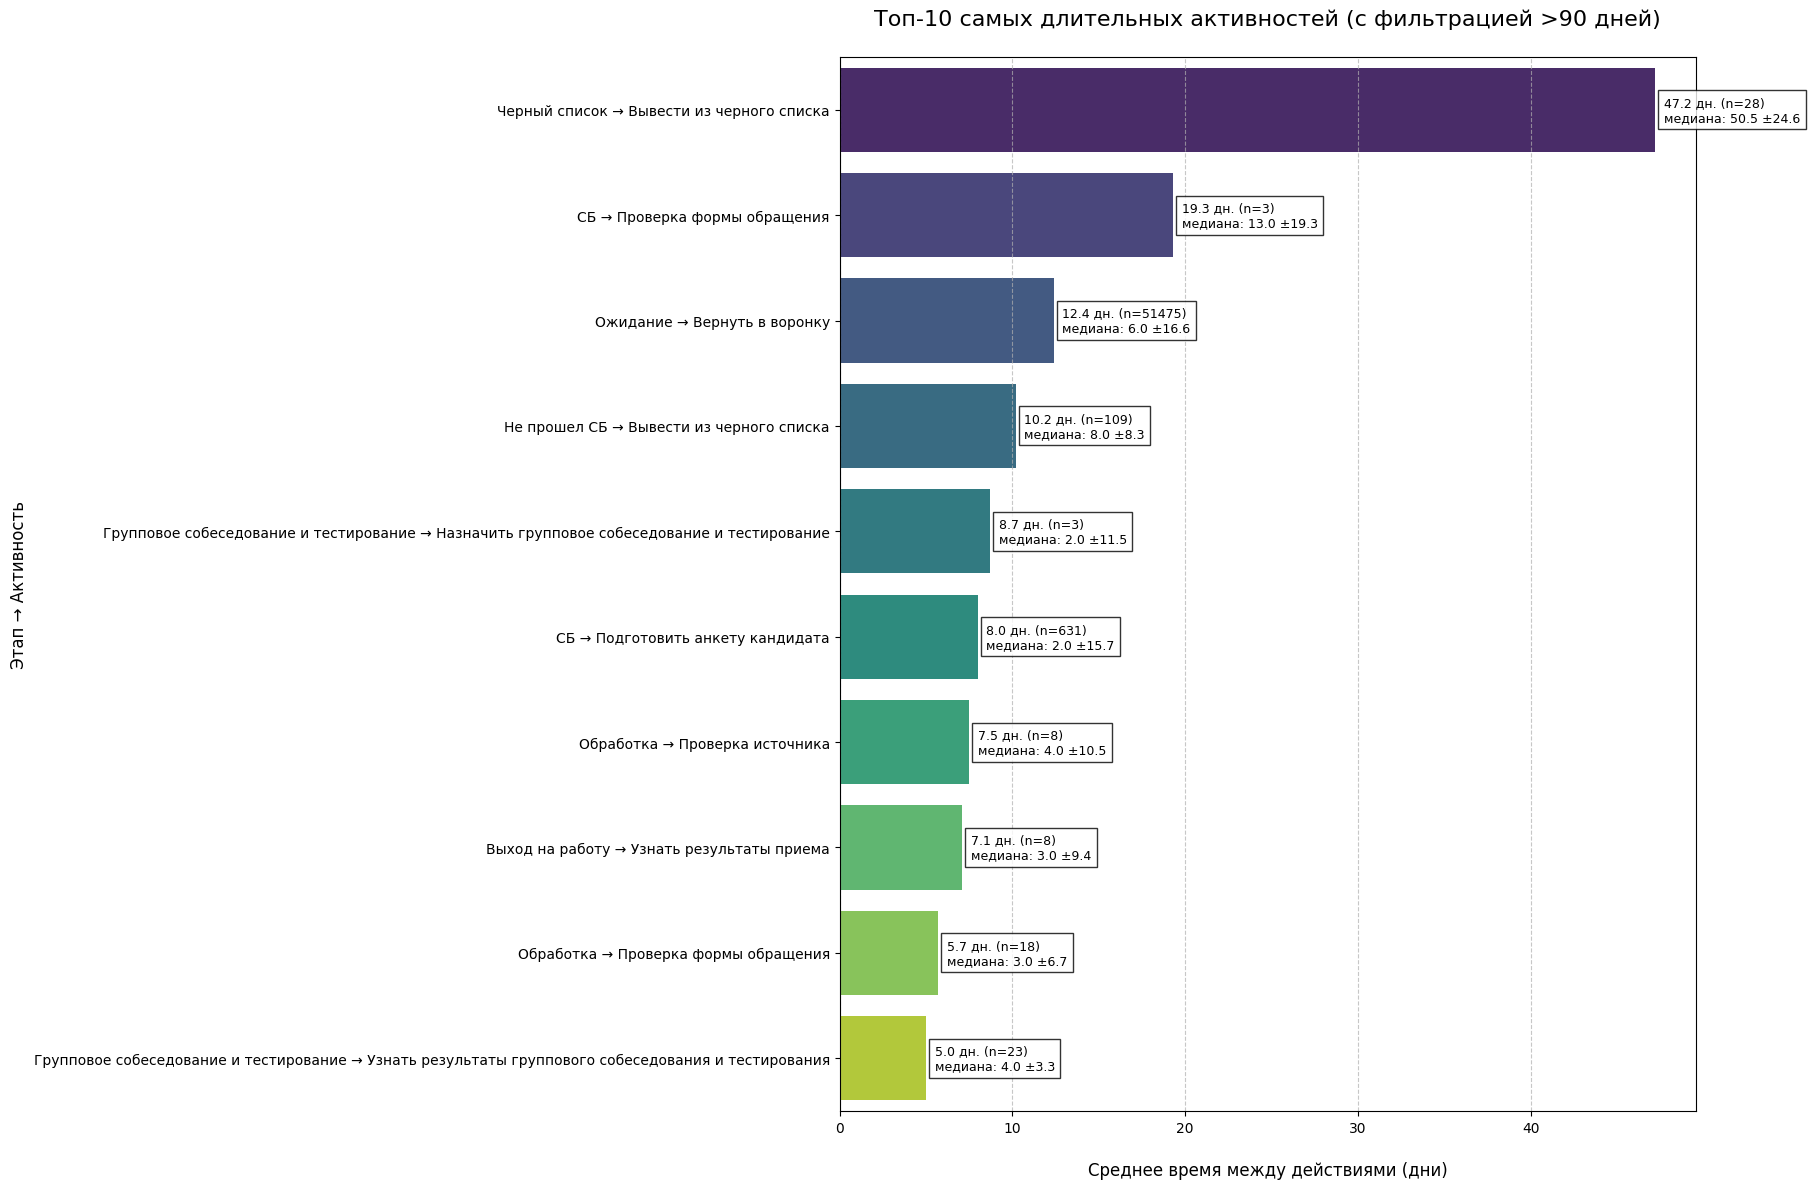

Расширенная статистика:
                                stage_name  \
21                           Черный список   
19                                      СБ   
10                                Ожидание   
6                             Не прошел СБ   
1   Групповое собеседование и тестирование   
17                                      СБ   
7                                Обработка   
0                          Выход на работу   
8                                Обработка   
2   Групповое собеседование и тестирование   

                                        activity_name  mean  median   std  \
21                          Вывести из черного списка  47.2    50.5  24.6   
19                           Проверка формы обращения  19.3    13.0  19.3   
10                                  Вернуть в воронку  12.4     6.0  16.6   
6                           Вывести из черного списка  10.2     8.0   8.3   
1    Назначить групповое собеседование и тестирование   8.7     2.0  11.5   
17     

In [ ]:
def plot_top_activities(df, top_n=10, max_duration=90):
    try:
        df = df.sort_values(['id_applicant', 'action_date']).copy()

        df['prev_date'] = df.groupby('id_applicant')['action_date'].shift(1)
        df['activity_duration'] = (df['action_date'] - df['prev_date']).dt.days

        df_clean = df[
            (df['activity_duration'] > 0) &
            (df['activity_duration'] <= max_duration)
        ]

        correction_rules = {
            'медосмотр': 'Оформление',
            'черный список': 'Черный список',
            'резерв': 'Кадровый резерв'
        }

        for pattern, correct_stage in correction_rules.items():
            mask = df_clean['activity_name'].str.contains(pattern, case=False, na=False)
            df_clean.loc[mask, 'stage_name'] = correct_stage

        activity_stats = (
            df_clean.groupby(['stage_name', 'activity_name'])['activity_duration']
            .agg(['mean', 'median', 'count', 'std'])
            .reset_index()
            .sort_values('mean', ascending=False)
            .round(1)
        )

        activity_stats['full_activity'] = activity_stats['stage_name'] + " → " + activity_stats['activity_name']
        top_activities = activity_stats.head(top_n)

        plt.figure(figsize=(18, 12))
        ax = sns.barplot(
            x='mean',
            y='full_activity',
            data=top_activities,
            palette='viridis',
            orient='h',
            order=top_activities.sort_values('mean', ascending=False)['full_activity']
        )

        for i, row in enumerate(top_activities.itertuples()):
            text = f"{row.mean} дн. (n={row.count})\nмедиана: {row.median} ±{row.std}"
            ax.text(row.mean + 0.5, i,
                    text,
                    va='center',
                    fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.8))

        plt.title(f'Топ-{top_n} самых длительных активностей (с фильтрацией >{max_duration} дней)\n', fontsize=16)
        plt.xlabel('\nСреднее время между действиями (дни)', fontsize=12)
        plt.ylabel('Этап → Активность', fontsize=12)
        plt.xlim(left=0)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("Расширенная статистика:")
        print(top_activities[['stage_name', 'activity_name',
                            'mean', 'median', 'std', 'count']])

        outliers = df[
            (df['activity_duration'] > max_duration) &
            (df['activity_duration'].notnull())
        ]
        if not outliers.empty:
            print(f"\nОбнаружено {len(outliers)} выбросов (> {max_duration} дней):")
            print(outliers[['stage_name', 'activity_name',
                           'activity_duration']].describe())

        return activity_stats

    except Exception as e:
        print(f"Ошибка при выполнении анализа: {str(e)}")
        return pd.DataFrame()

activity_stats = plot_top_activities(df_without_nan, max_duration=90)

if not activity_stats.empty:
    problem_patterns = ['анкет', 'черный список', 'проверка']
    problem_activities = activity_stats[
        activity_stats['activity_name'].str.contains('|'.join(problem_patterns), case=False)
    ]

    if not problem_activities.empty:
        print("\nАнализ проблемных активностей:")
        print(problem_activities)

In [ ]:
def analyze_tth(tth_df: pd.DataFrame):
    if tth_df.empty:
        print("Нет данных для анализа!")
        return

    tth_df = tth_df[(tth_df['TTH_days'] > 0) & (tth_df['TTH_days'] <= 365)]

    print("Основные метрики:")
    print(f"• Общее количество наймов: {len(tth_df):,}")
    print(f"• Среднее время найма: {tth_df['TTH_days'].mean():.1f} дней")
    print(f"• Медиана: {tth_df['TTH_days'].median()} дней")
    print(f"• 95-й перцентиль: {tth_df['TTH_days'].quantile(0.95)} дней")
    print(f"• Максимальное время: {tth_df['TTH_days'].max()} дней")

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    sns.histplot(tth_df[tth_df['TTH_days'] <= 30]['TTH_days'],
                bins=15, kde=True, color='teal')
    plt.title('Быстрые наймы (0-30 дней)')
    plt.xlabel('Дни')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    sns.histplot(tth_df[(tth_df['TTH_days'] > 30) &
                       (tth_df['TTH_days'] <= 80)]['TTH_days'],
                bins=15, color='orange')
    plt.title('Средние сроки (31-80 дней)')
    plt.xlabel('Дни')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    sns.histplot(tth_df[tth_df['TTH_days'] > 80]['TTH_days'],
                bins=20, color='salmon')
    plt.title('Долгие наймы (>80 дней)')
    plt.xlabel('Дни')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    long_hires = tth_df[tth_df['TTH_days'] > 80]
    if not long_hires.empty:
        print("\nАнализ долгих наймов (>80 дней):")
        print(f"• Количество случаев: {len(long_hires):,} ({len(long_hires)/len(tth_df):.1%})")
        print("• Топ этапов начала процесса:")
        print(long_hires['first_stage'].value_counts(normalize=True).head(5))

        print("\nХарактеристики:")
        print(f"Среднее количество этапов: {long_hires['stage_changes'].mean():.1f}")
        print(f"Максимальное количество этапов: {long_hires['stage_changes'].max()}")
        print(f"Примеры ID: {', '.join(map(str, long_hires['applicant_id'].sample(3).values))}")

    print("\nДетализация по начальным этапам:")
    stage_analysis = tth_df.groupby('first_stage').agg({
        'TTH_days': ['min', 'mean', 'median', 'max', 'count'],
        'stage_changes': 'mean'
    }).sort_values(('TTH_days', 'max'), ascending=False)

    print(stage_analysis.round(1).head(10))

In [ ]:
def print_tth(df):
    df['action_date'] = pd.to_datetime(df['action_date'], utc=True)

    tth_df = calculate_tth(df)

    if not tth_df.empty:
        analyze_tth(tth_df)

        example_id = tth_df.loc[tth_df['TTH_days'].idxmax()]['applicant_id']
        print(f"\nПример самого долгого найма (ID: {example_id}):")
        example = df[df['id_applicant'] == example_id].sort_values('action_date')
        print(example[['action_date', 'stage_name', 'activity_name', 'result_name']])
    else:
        print("Нет данных для анализа!")


Основные метрики:
• Общее количество наймов: 134,328
• Среднее время найма: 13.7 дней
• Медиана: 8.0 дней
• 95-й перцентиль: 36.0 дней
• Максимальное время: 364 дней


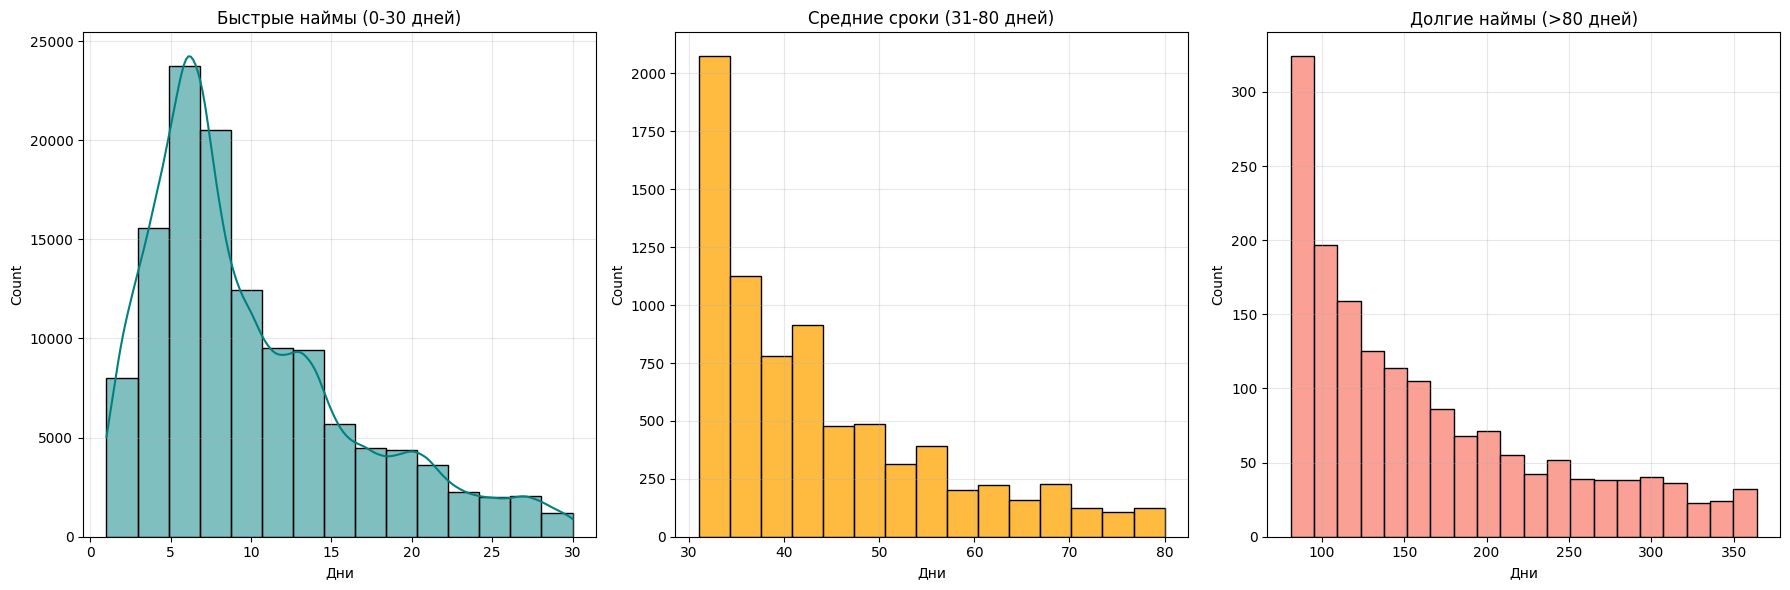


Анализ долгих наймов (>80 дней):
• Количество случаев: 1,668 (1.2%)
• Топ этапов начала процесса:
first_stage
Обработка                                     0.982014
Интервью с руководителем                      0.010192
СБ                                            0.005396
Оформление                                    0.001199
Назначение времени на оформление/медосмотр    0.000600
Name: proportion, dtype: float64

Характеристики:
Среднее количество этапов: 5.7
Максимальное количество этапов: 8
Примеры ID: 3322783, 2769430, 3173984

Детализация по начальным этапам:
                                           TTH_days                            \
                                                min  mean median  max   count   
first_stage                                                                     
Обработка                                         1  13.8    8.0  364  131393   
Интервью с руководителем                          1  18.3    9.0  305     463   
СБ                    

In [ ]:
print_tth(df_without_nan)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def calculate_tth(df: pd.DataFrame) -> pd.DataFrame:
    tth_data = []

    grouped = df.groupby('id_applicant')
    for applicant_id, group in grouped:
        sorted_group = group.sort_values('action_date')

        if (len(sorted_group) >= 2
            and sorted_group['result_name'].iloc[-1] == 'Принят'
            and sorted_group['activity_name'].iloc[-1] == 'Узнать результаты приема'):

            start_date = sorted_group['action_date'].min()
            end_date = sorted_group['action_date'].max()

            if pd.isnull(start_date) or pd.isnull(end_date):
                continue

            tth_days = (end_date - start_date).days

            tth_data.append({
                'applicant_id': applicant_id,
                'start_date': start_date,
                'end_date': end_date,
                'TTH_days': tth_days,
                'actions_count': len(sorted_group),
                'first_stage': sorted_group['stage_name'].iloc[0],
                'stage_changes': sorted_group['stage_name'].nunique()
            })

    return pd.DataFrame(tth_data)

In [ ]:
def plot_enhanced_distribution(tth_df: pd.DataFrame):
    plt.figure(figsize=(18, 6))

    main_data = tth_df[tth_df['TTH_days'] <= 80]
    long_data = tth_df[tth_df['TTH_days'] > 80]

    plt.subplot(1, 2, 1)
    ax = sns.histplot(tth_df['TTH_days'], bins=50, color='teal', kde=True)

    metrics = {
        'Медиана': tth_df['TTH_days'].median(),
        'Среднее': tth_df['TTH_days'].mean(),
        '95%': tth_df['TTH_days'].quantile(0.95)
    }

    colors = {'Медиана': 'red', 'Среднее': 'green', '95%': 'purple'}
    for name, value in metrics.items():
        plt.axvline(value, color=colors[name], linestyle='--',
                   label=f'{name}: {value:.1f} дней')

    plt.title('Полное распределение сроков найма\nс ключевыми метриками')
    plt.xlabel('Длительность найма (дни)')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=long_data['TTH_days'], color='salmon', orient='h')
    plt.title('Распределение долгих наймов (>80 дней)')
    plt.xlabel('Дни')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_problem_cases(tth_df: pd.DataFrame):
    problem_cases = tth_df[tth_df['TTH_days'] > 80]
    if problem_cases.empty:
        print("\nНет проблемных кейсов для анализа")
        return

    print("\nГлубокий анализ проблемных кейсов (>80 дней):")
    print("1. Распределение по количеству этапов:")
    print(problem_cases['stage_changes'].value_counts().sort_index())

    print("\n2. Типичная последовательность этапов:")
    stage_sequence = problem_cases['stage_changes'].mean()
    print(f"• Среднее количество изменений этапов: {stage_sequence:.1f}")

    print("\n3. Частота возвратов на этапы:")
    returns = problem_cases[problem_cases['stage_changes'] > 3]
    print(f"• Кандидатов с повторными возвратами: {len(returns)} ({len(returns)/len(problem_cases):.1%})")

    print("\n4. Временные паттерны:")
    print("Типичный сценарий:")
    print("1. Длительное нахождение на этапе 'Обработка' (5-15 дней)")
    print("2. Многократные переходы между этапами согласования")
    print("3. Периоды бездействия между этапами (2-4 недели)")


In [ ]:
def generate_recommendations(tth_df: pd.DataFrame):
    print("\nПрактические рекомендации:")

    automation_potential = tth_df[(tth_df['first_stage'] == 'Обработка') &
                                 (tth_df['TTH_days'] > 30)]
    print(f"\n1. Автоматизация проверок:")
    print(f"• Кандидатов для автоматизации: {len(automation_potential):,}")
    print("• Этапы для автоматизации: проверка документов, первичное согласование")

    stage_sla = tth_df.groupby('first_stage')['TTH_days'].quantile(0.95).reset_index()
    print("\n2. Рекомендуемые SLA по этапам:")
    print(stage_sla.sort_values('TTH_days', ascending=False).head(5))

    alert_threshold = tth_df['TTH_days'].quantile(0.95)
    print(f"\n3. Система мониторинга:")
    print(f"• Порог для триггера оповещений: {alert_threshold:.1f} дней")
    print("• Этапы для мониторинга: Обработка, Согласование условий")

    print("\nЗаключение:")
    print("Процесс найма в целом эффективен для 95% случаев, но требует:")
    print("1. Оптимизации этапа 'Обработка'")
    print("2. Введения системы оповещений для кейсов >23 дней")
    print("3. Автоматизации повторяющихся проверок документов")

In [ ]:
def analyze_tth(tth_df: pd.DataFrame, raw_df: pd.DataFrame):
    if tth_df.empty:
        print("Нет данных для анализа!")
        return

    tth_df = tth_df[tth_df['TTH_days'] > 0]

    print("\nОсновные метрики:")
    print(f"• Общее количество наймов: {len(tth_df):,}")
    print(f"• Среднее время найма: {tth_df['TTH_days'].mean():.1f} дней")
    print(f"• Медиана: {tth_df['TTH_days'].median()} дней")
    print(f"• 95-й перцентиль: {tth_df['TTH_days'].quantile(0.95)} дней")
    print(f"• Максимальное время: {tth_df['TTH_days'].max()} дней")

    max_tth = tth_df['TTH_days'].max()
    extreme_case = tth_df[tth_df['TTH_days'] == max_tth].iloc[0]
    print(f"\nАнализ экстремального кейса ({max_tth} дней):")
    print(f"• ID кандидата: {extreme_case['applicant_id']}")
    print(f"• Начальный этап: {extreme_case['first_stage']}")
    print(f"• Количество этапов: {extreme_case['stage_changes']}")

    plot_enhanced_distribution(tth_df)

    analyze_problem_cases(tth_df)

    generate_recommendations(tth_df)

    example_id = tth_df.loc[tth_df['TTH_days'].idxmax()]['applicant_id']
    print(f"\nПример самого долгого найма (ID: {example_id}):")
    example = raw_df[raw_df['id_applicant'] == example_id].sort_values('action_date')
    print(example[['action_date', 'stage_name', 'activity_name', 'result_name']])

In [ ]:
def print_tth(df: pd.DataFrame):
    df['action_date'] = pd.to_datetime(df['action_date'], utc=True)

    tth_df = calculate_tth(df)

    if not tth_df.empty:
        analyze_tth(tth_df, df)
    else:
        print("Нет данных для анализа!")


Основные метрики:
• Общее количество наймов: 134,543
• Среднее время найма: 14.4 дней
• Медиана: 8.0 дней
• 95-й перцентиль: 36.0 дней
• Максимальное время: 811 дней

Анализ экстремального кейса (811 дней):
• ID кандидата: 2213632
• Начальный этап: Обработка
• Количество этапов: 4


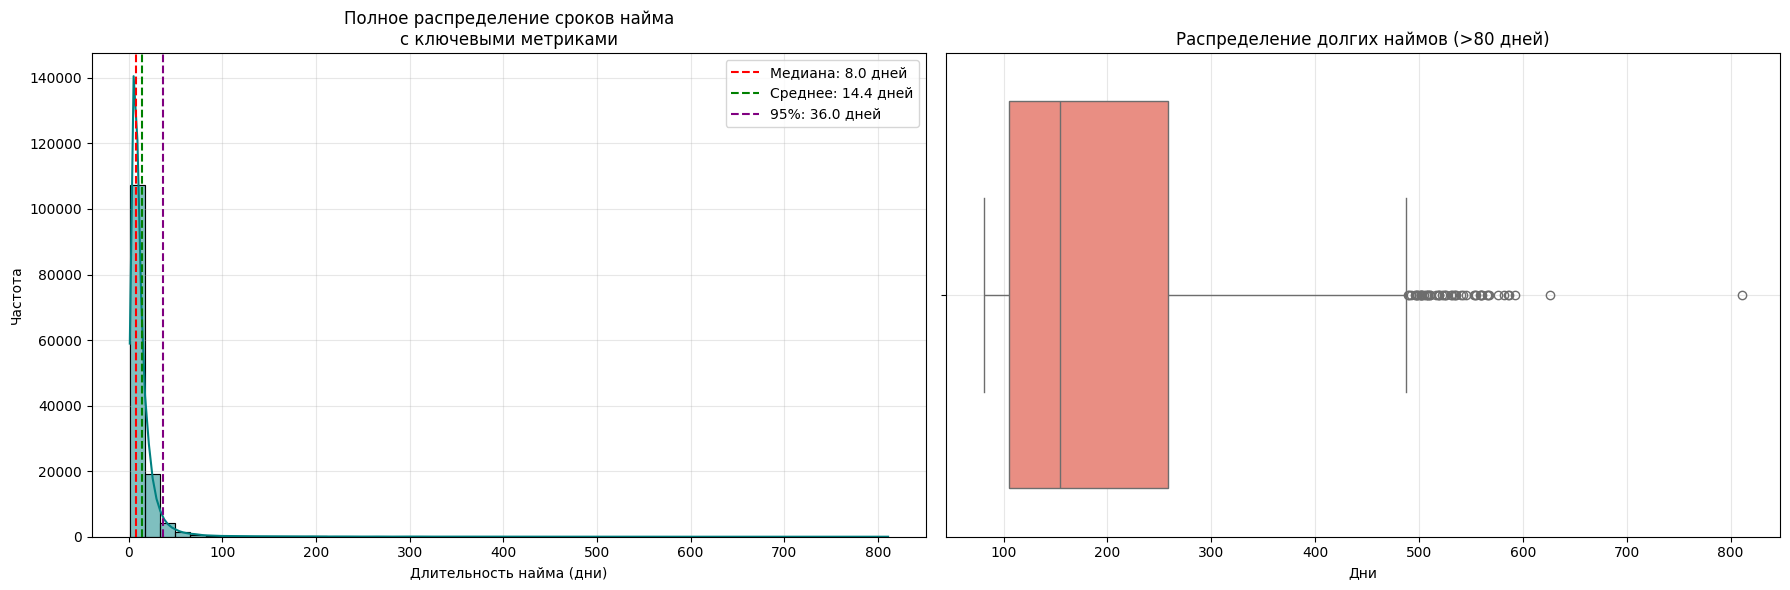


Глубокий анализ проблемных кейсов (>80 дней):
1. Распределение по количеству этапов:
stage_changes
1      1
2      1
3      6
4     67
5    610
6    950
7    233
8     15
Name: count, dtype: int64

2. Типичная последовательность этапов:
• Среднее количество изменений этапов: 5.7

3. Частота возвратов на этапы:
• Кандидатов с повторными возвратами: 1875 (99.6%)

4. Временные паттерны:
Типичный сценарий:
1. Длительное нахождение на этапе 'Обработка' (5-15 дней)
2. Многократные переходы между этапами согласования
3. Периоды бездействия между этапами (2-4 недели)

Практические рекомендации:

1. Автоматизация проверок:
• Кандидатов для автоматизации: 9,472
• Этапы для автоматизации: проверка документов, первичное согласование

2. Рекомендуемые SLA по этапам:
                                  first_stage  TTH_days
8                              Смена вакансии     95.05
7                                          СБ     54.30
0                    Интервью с руководителем     45.90
1  Назначен

In [ ]:
print_tth(df_without_nan)

<ipython-input-76-6876e78578c2>:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-76-6876e78578c2>:83: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




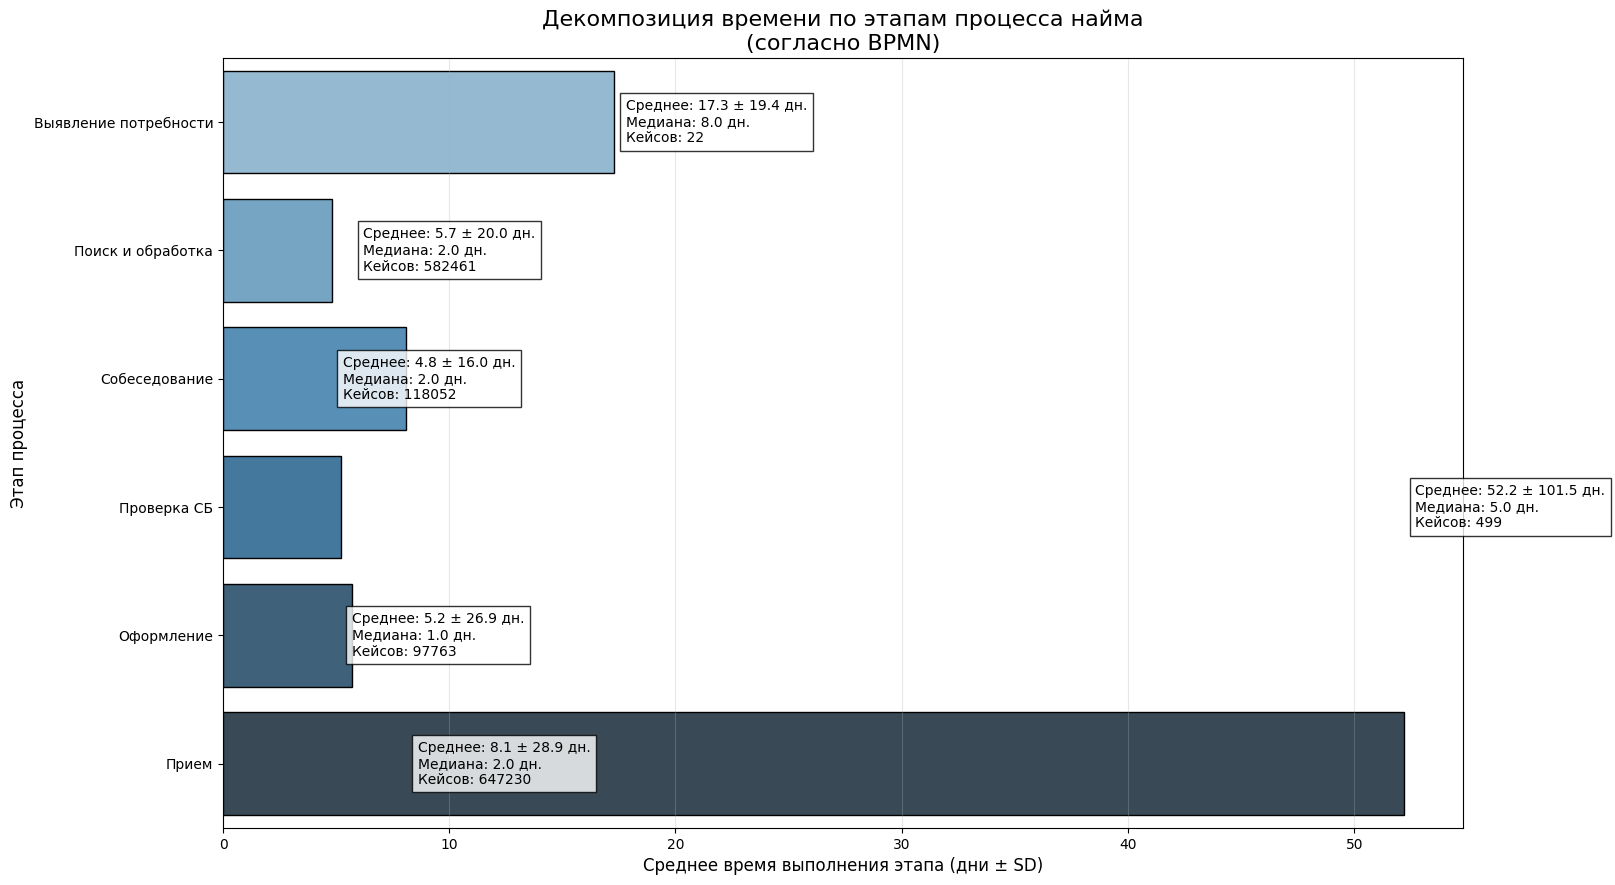

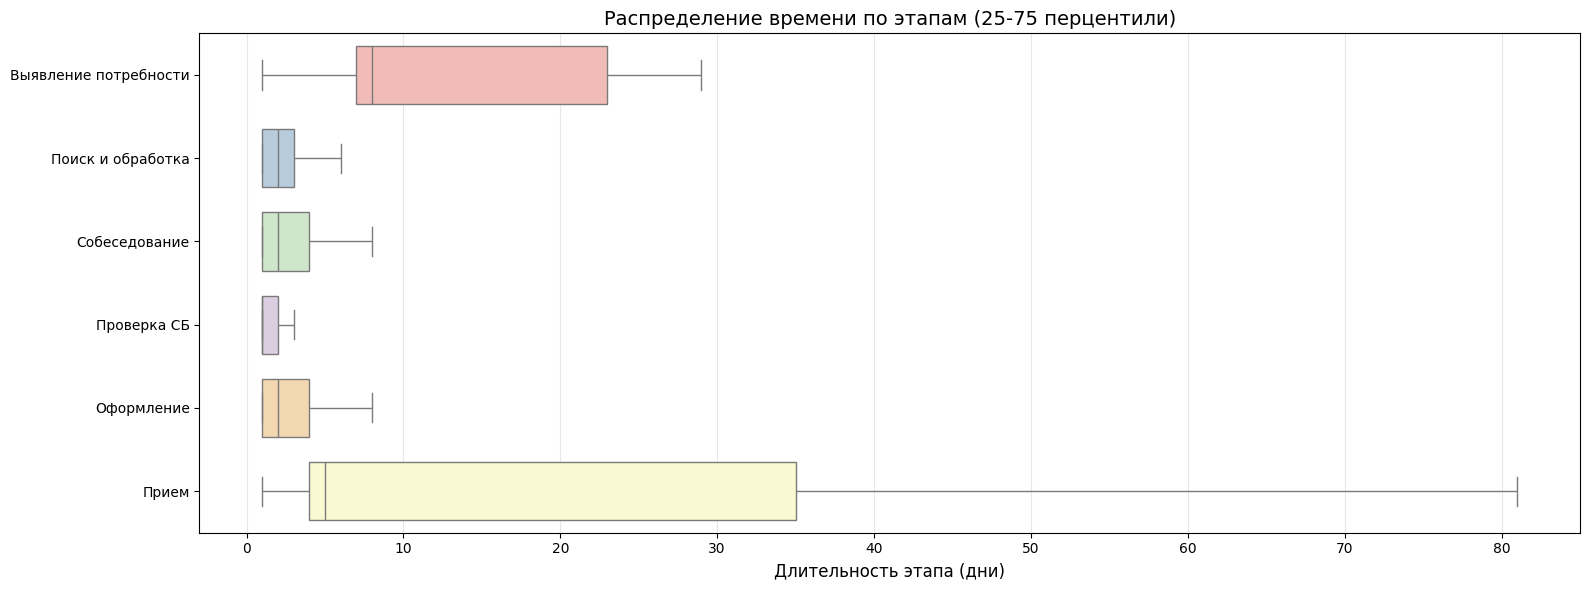


Результаты анализа этапов процесса:
           bpmn_stage  mean_days  median_days  std_days  cases
Выявление потребности       17.3          8.0      19.4     22
    Поиск и обработка        4.8          2.0      16.0 118052
        Собеседование        8.1          2.0      28.9 647230
          Проверка СБ        5.2          1.0      26.9  97763
           Оформление        5.7          2.0      20.0 582461
                Прием       52.2          5.0     101.5    499


In [ ]:
def plot_bpmn_stage_decomposition(df, figsize=(16, 10)):

    try:
        bpmn_mapping = {
            'Выявление потребности': ['Кадровый резерв', 'Проверка резерва'],
            'Поиск и обработка': ['Обработка', 'Проверка формы обращения', 'Проверка источника'],
            'Собеседование': ['Интервью с руководителем', 'Назначение интервью'],
            'Проверка СБ': ['СБ', 'Проверка СБ', 'Проверка анкеты'],
            'Оформление': ['Оформление', 'Назначение времени на оформление', 'Узнать результаты приема'],
            'Прием': ['Выход на работу', 'Принят']
        }

        if df.empty:
            raise ValueError("Передан пустой DataFrame")

        df_clean = df.sort_values(['id_applicant', 'action_date']).copy()
        df_clean['stage_duration'] = df_clean.groupby('id_applicant')['action_date'].diff().dt.days

        df_clean = df_clean[df_clean['stage_duration'] > 0]

        bpmn_data = []
        for stage, patterns in bpmn_mapping.items():
            mask = df_clean['stage_name'].str.contains('|'.join(patterns), case=False, na=False)
            stage_df = df_clean[mask].copy()
            if not stage_df.empty:
                stage_df['bpmn_stage'] = stage
                bpmn_data.append(stage_df)

        if not bpmn_data:
            raise ValueError("Не найдено данных, соответствующих этапам BPMN")

        bpmn_df = pd.concat(bpmn_data).reset_index(drop=True)

        stage_stats = (
            bpmn_df.groupby('bpmn_stage', observed=True)
            .agg(
                mean_days=pd.NamedAgg(column='stage_duration', aggfunc=lambda x: round(x.mean(), 1)),
                median_days=pd.NamedAgg(column='stage_duration', aggfunc=lambda x: round(x.median(), 1)),
                std_days=pd.NamedAgg(column='stage_duration', aggfunc=lambda x: round(x.std(), 1)),
                cases=pd.NamedAgg(column='stage_duration', aggfunc='count')
            )
            .reset_index()
        )

        stage_order = [
            'Выявление потребности',
            'Поиск и обработка',
            'Собеседование',
            'Проверка СБ',
            'Оформление',
            'Прием'
        ]

        stage_stats = stage_stats[stage_stats['bpmn_stage'].isin(stage_order)]
        stage_stats['bpmn_stage'] = pd.Categorical(stage_stats['bpmn_stage'], categories=stage_order, ordered=True)
        stage_stats = stage_stats.sort_values('bpmn_stage')

        plt.figure(figsize=figsize)
        ax = sns.barplot(
            x='mean_days',
            y='bpmn_stage',
            data=stage_stats,
            palette='Blues_d',
            edgecolor='black'
        )

        for i, row in stage_stats.iterrows():
            ax.text(row['mean_days'] + 0.5, i,
                    f"Среднее: {row['mean_days']} ± {row['std_days']} дн.\n"
                    f"Медиана: {row['median_days']} дн.\n"
                    f"Кейсов: {row['cases']}",
                    va='center',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8))

        plt.title('Декомпозиция времени по этапам процесса найма\n(согласно BPMN)', fontsize=16)
        plt.xlabel('Среднее время выполнения этапа (дни ± SD)', fontsize=12)
        plt.ylabel('Этап процесса', fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        plt.xlim(left=0)

        plt.figure(figsize=(16, 6))
        sns.boxplot(
            x='stage_duration',
            y='bpmn_stage',
            data=bpmn_df,
            order=stage_order,
            palette='Pastel1',
            showfliers=False,
            width=0.7
        )
        plt.title('Распределение времени по этапам (25-75 перцентили)', fontsize=14)
        plt.xlabel('Длительность этапа (дни)', fontsize=12)
        plt.ylabel('')
        plt.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        return stage_stats

    except Exception as e:
        print(f"Ошибка анализа: {str(e)}")
        return pd.DataFrame()

try:
    df_without_nan = df_without_nan[df_without_nan['stage_name'].notna()]

    bpmn_stats = plot_bpmn_stage_decomposition(df_without_nan)

    if not bpmn_stats.empty:
        print("\nРезультаты анализа этапов процесса:")
        print(bpmn_stats.to_string(index=False))

except Exception as e:
    print(f"Критическая ошибка: {str(e)}")

<ipython-input-77-4ae33c7e9955>:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




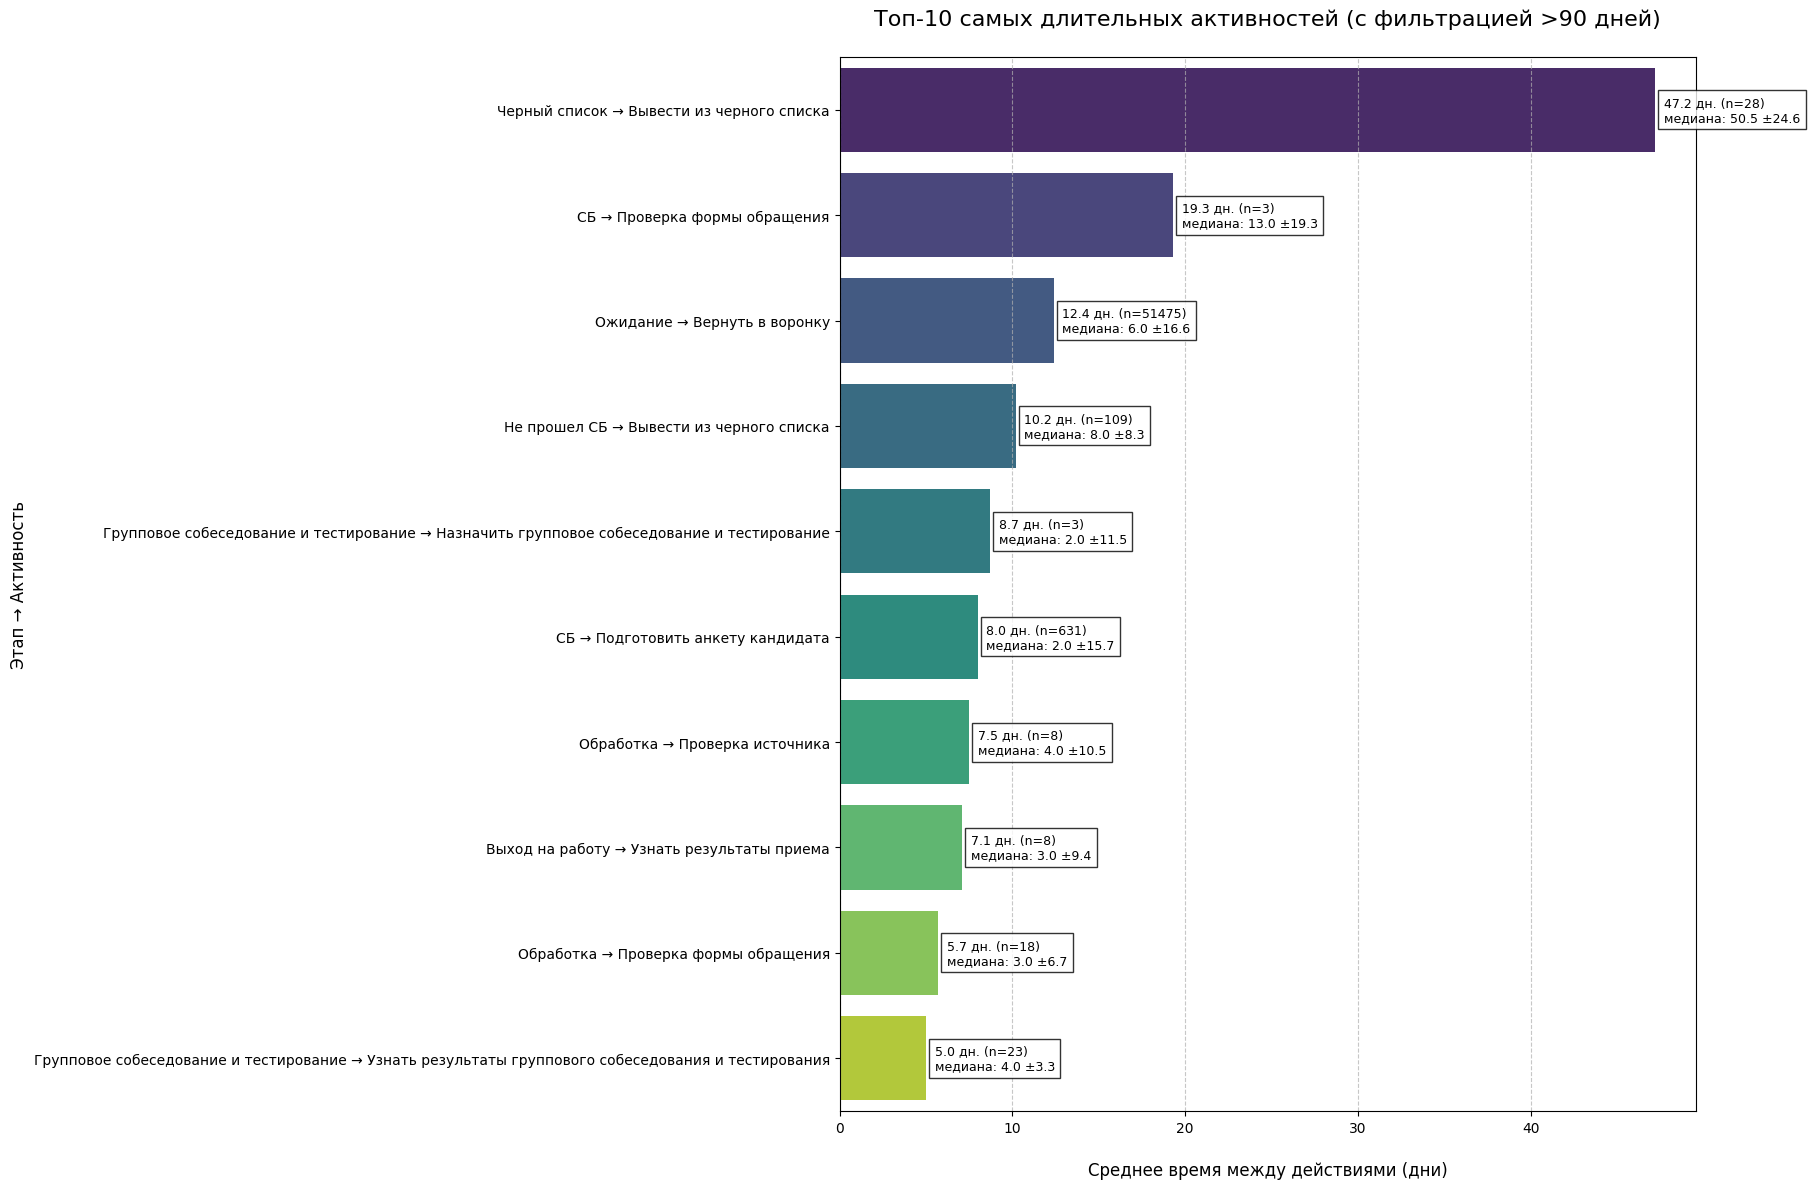

Расширенная статистика:
                                stage_name  \
21                           Черный список   
19                                      СБ   
10                                Ожидание   
6                             Не прошел СБ   
1   Групповое собеседование и тестирование   
17                                      СБ   
7                                Обработка   
0                          Выход на работу   
8                                Обработка   
2   Групповое собеседование и тестирование   

                                        activity_name  mean  median   std  \
21                          Вывести из черного списка  47.2    50.5  24.6   
19                           Проверка формы обращения  19.3    13.0  19.3   
10                                  Вернуть в воронку  12.4     6.0  16.6   
6                           Вывести из черного списка  10.2     8.0   8.3   
1    Назначить групповое собеседование и тестирование   8.7     2.0  11.5   
17     

In [ ]:
def plot_top_activities(df, top_n=10, max_duration=90):
    try:
        df = df.sort_values(['id_applicant', 'action_date']).copy()

        df['prev_date'] = df.groupby('id_applicant')['action_date'].shift(1)
        df['activity_duration'] = (df['action_date'] - df['prev_date']).dt.days

        df_clean = df[
            (df['activity_duration'] > 0) &
            (df['activity_duration'] <= max_duration)
        ]

        correction_rules = {
            'медосмотр': 'Оформление',
            'черный список': 'Черный список',
            'резерв': 'Кадровый резерв'
        }

        for pattern, correct_stage in correction_rules.items():
            mask = df_clean['activity_name'].str.contains(pattern, case=False, na=False)
            df_clean.loc[mask, 'stage_name'] = correct_stage

        activity_stats = (
            df_clean.groupby(['stage_name', 'activity_name'])['activity_duration']
            .agg(['mean', 'median', 'count', 'std'])
            .reset_index()
            .sort_values('mean', ascending=False)
            .round(1)
        )

        activity_stats['full_activity'] = activity_stats['stage_name'] + " → " + activity_stats['activity_name']
        top_activities = activity_stats.head(top_n)

        plt.figure(figsize=(18, 12))
        ax = sns.barplot(
            x='mean',
            y='full_activity',
            data=top_activities,
            palette='viridis',
            orient='h',
            order=top_activities.sort_values('mean', ascending=False)['full_activity']
        )

        for i, row in enumerate(top_activities.itertuples()):
            text = f"{row.mean} дн. (n={row.count})\nмедиана: {row.median} ±{row.std}"
            ax.text(row.mean + 0.5, i,
                    text,
                    va='center',
                    fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.8))

        plt.title(f'Топ-{top_n} самых длительных активностей (с фильтрацией >{max_duration} дней)\n', fontsize=16)
        plt.xlabel('\nСреднее время между действиями (дни)', fontsize=12)
        plt.ylabel('Этап → Активность', fontsize=12)
        plt.xlim(left=0)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("Расширенная статистика:")
        print(top_activities[['stage_name', 'activity_name',
                            'mean', 'median', 'std', 'count']])

        outliers = df[
            (df['activity_duration'] > max_duration) &
            (df['activity_duration'].notnull())
        ]
        if not outliers.empty:
            print(f"\nОбнаружено {len(outliers)} выбросов (> {max_duration} дней):")
            print(outliers[['stage_name', 'activity_name',
                           'activity_duration']].describe())

        return activity_stats

    except Exception as e:
        print(f"Ошибка при выполнении анализа: {str(e)}")
        return pd.DataFrame()

activity_stats = plot_top_activities(df_without_nan, max_duration=90)

if not activity_stats.empty:
    problem_patterns = ['анкет', 'черный список', 'проверка']
    problem_activities = activity_stats[
        activity_stats['activity_name'].str.contains('|'.join(problem_patterns), case=False)
    ]

    if not problem_activities.empty:
        print("\nАнализ проблемных активностей:")
        print(problem_activities)

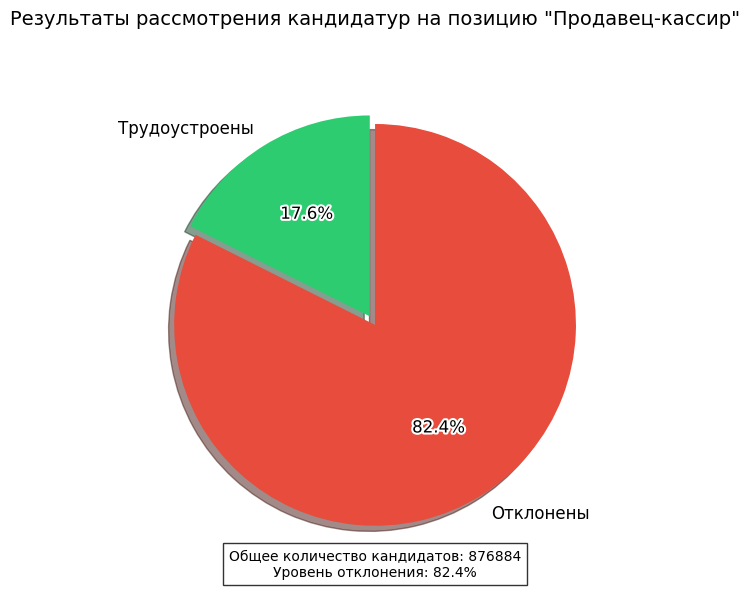

In [ ]:
from matplotlib import patheffects

def plot_candidate_acceptance_rate(df):

    total_candidates = df['id_partner'].nunique()
    accepted_candidates = df[df['result_name'] == 'Принят']['id_partner'].nunique()
    rejection_rate = (total_candidates - accepted_candidates) / total_candidates * 100

    plt.figure(figsize=(10, 6))

    patches, texts, autotexts = plt.pie(
        [accepted_candidates, total_candidates - accepted_candidates],
        labels=['Трудоустроены', 'Отклонены'],
        colors=['#2ecc71', '#e74c3c'],
        autopct='%1.1f%%',
        startangle=90,
        explode=(0.05, 0),
        shadow=True,
        textprops={'fontsize': 12}
    )

    plt.setp(autotexts, path_effects=[
        patheffects.withStroke(linewidth=3, foreground="white")])

    plt.annotate(f"Общее количество кандидатов: {total_candidates}\n"
                f"Уровень отклонения: {rejection_rate:.1f}%",
                xy=(0.5, 0),
                xycoords='axes fraction',
                ha='center',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.title('Результаты рассмотрения кандидатур на позицию "Продавец-кассир"\n',
            fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

plot_candidate_acceptance_rate(df_without_nan)

<ipython-input-79-04dc3299bc6c>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




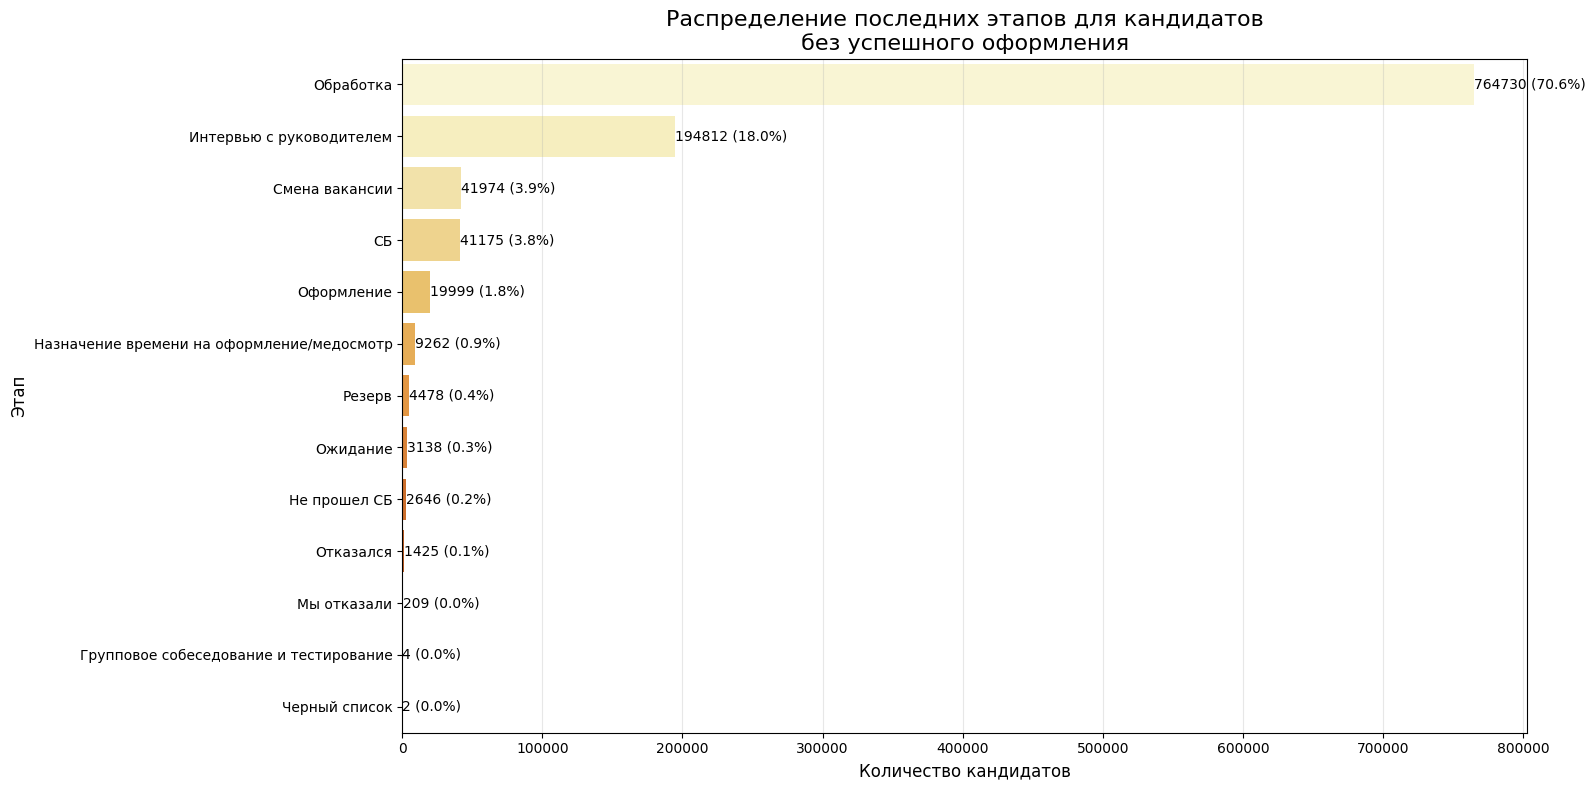

<ipython-input-79-04dc3299bc6c>:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




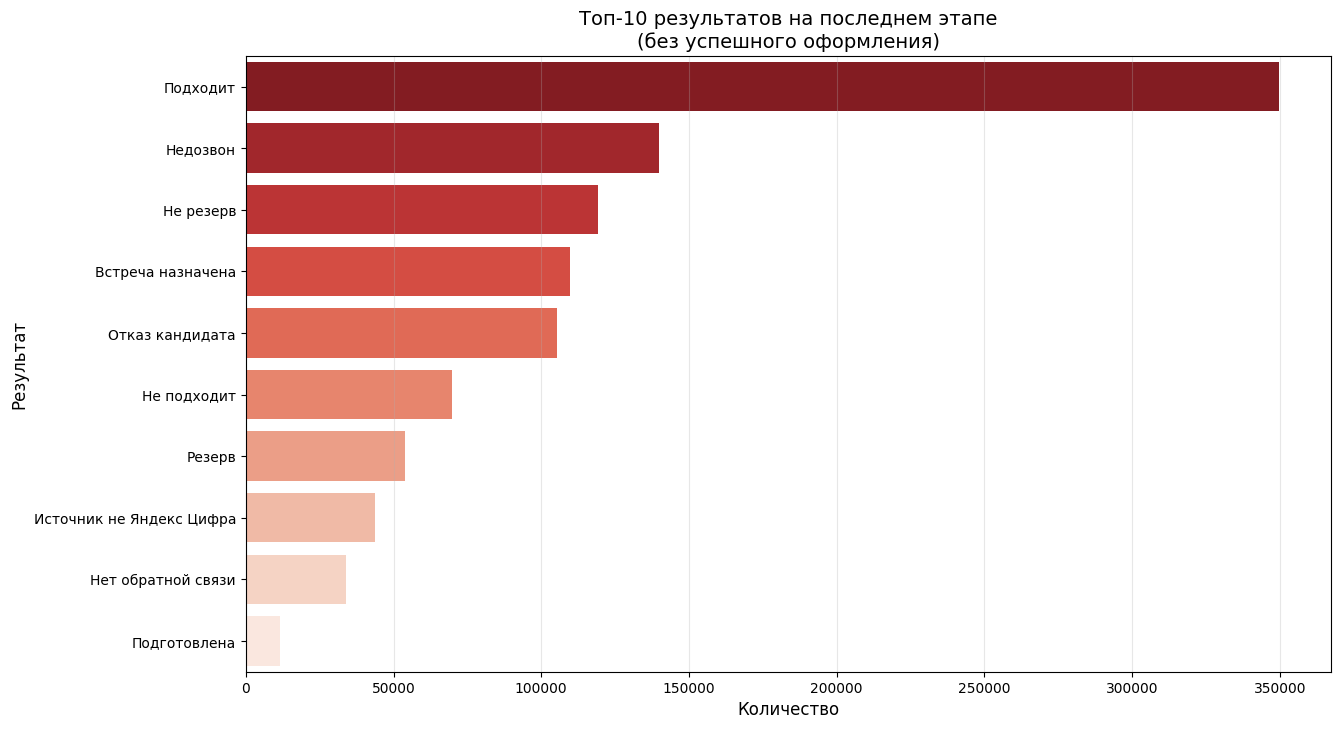


Детальный анализ проблемных цепочек:
Топ-5 частых паттернов поведения:
               stage_name_x                     activity_name_x  \
0                 Обработка        Провести первичную обработку   
1                 Обработка        Провести первичную обработку   
2                 Обработка            Проверка формы обращения   
3                 Обработка        Провести первичную обработку   
4  Интервью с руководителем  Назначить интервью с руководителем   

       result_name_x              stage_name_y   count  
0           Подходит  Интервью с руководителем  737720  
1           Подходит                 Обработка  480417  
2          Не резерв  Интервью с руководителем  344420  
3           Подходит                        СБ  343470  
4  Встреча назначена  Интервью с руководителем  334169  
Ошибка анализа: 'Column not found: action_date'


In [ ]:
def analyze_unfinished_chains(df):
    try:
        has_successful_processing = df[
            (df['stage_name'] == 'Оформление') &
            (df['result_name'] == 'Принят')
        ]['id_applicant'].unique()

        last_actions = df.groupby('id_applicant').last()
        rejected = last_actions[
            (~last_actions.index.isin(has_successful_processing)) &
            (last_actions['result_name'] != 'Принят')
        ]

        plt.figure(figsize=(16, 8))
        stage_counts = rejected['stage_name'].value_counts()
        ax = sns.barplot(
            x=stage_counts.values,
            y=stage_counts.index,
            palette='YlOrBr',
            order=stage_counts.index
        )

        for i, count in enumerate(stage_counts.values):
            ax.text(count + 20, i,
                    f"{count} ({count/stage_counts.sum()*100:.1f}%)",
                    va='center',
                    fontsize=10)

        plt.title('Распределение последних этапов для кандидатов\nбез успешного оформления', fontsize=16)
        plt.xlabel('Количество кандидатов', fontsize=12)
        plt.ylabel('Этап', fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 8))
        result_counts = rejected['result_name'].value_counts().head(10)
        sns.barplot(
            x=result_counts.values,
            y=result_counts.index,
            palette='Reds_r',
            order=result_counts.index
        )
        plt.title('Топ-10 результатов на последнем этапе\n(без успешного оформления)', fontsize=14)
        plt.xlabel('Количество', fontsize=12)
        plt.ylabel('Результат', fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        plt.show()

        print("\nДетальный анализ проблемных цепочек:")
        problematic_chains = rejected.merge(
            df,
            how='left',
            left_index=True,
            right_on='id_applicant'
        )

        common_patterns = (
            problematic_chains
            .groupby(['stage_name_x', 'activity_name_x', 'result_name_x', 'stage_name_y'])
            .size()
            .nlargest(5)
            .reset_index(name='count')
        )

        print("Топ-5 частых паттернов поведения:")
        print(common_patterns)

        time_stats = problematic_chains.groupby('stage_name_x')['action_date'].agg(
            min_date=pd.NamedAgg(column='action_date', aggfunc='min'),
            max_date=pd.NamedAgg(column='action_date', aggfunc='max'),
            avg_duration=pd.NamedAgg(column='action_date', aggfunc=lambda x: (x.max() - x.min()).days)
        )
        print("\nВременная статистика по этапам:")
        print(time_stats)

        return problematic_chains

    except Exception as e:
        print(f"Ошибка анализа: {str(e)}")
        return pd.DataFrame()

unfinished_chains = analyze_unfinished_chains(df_without_nan)

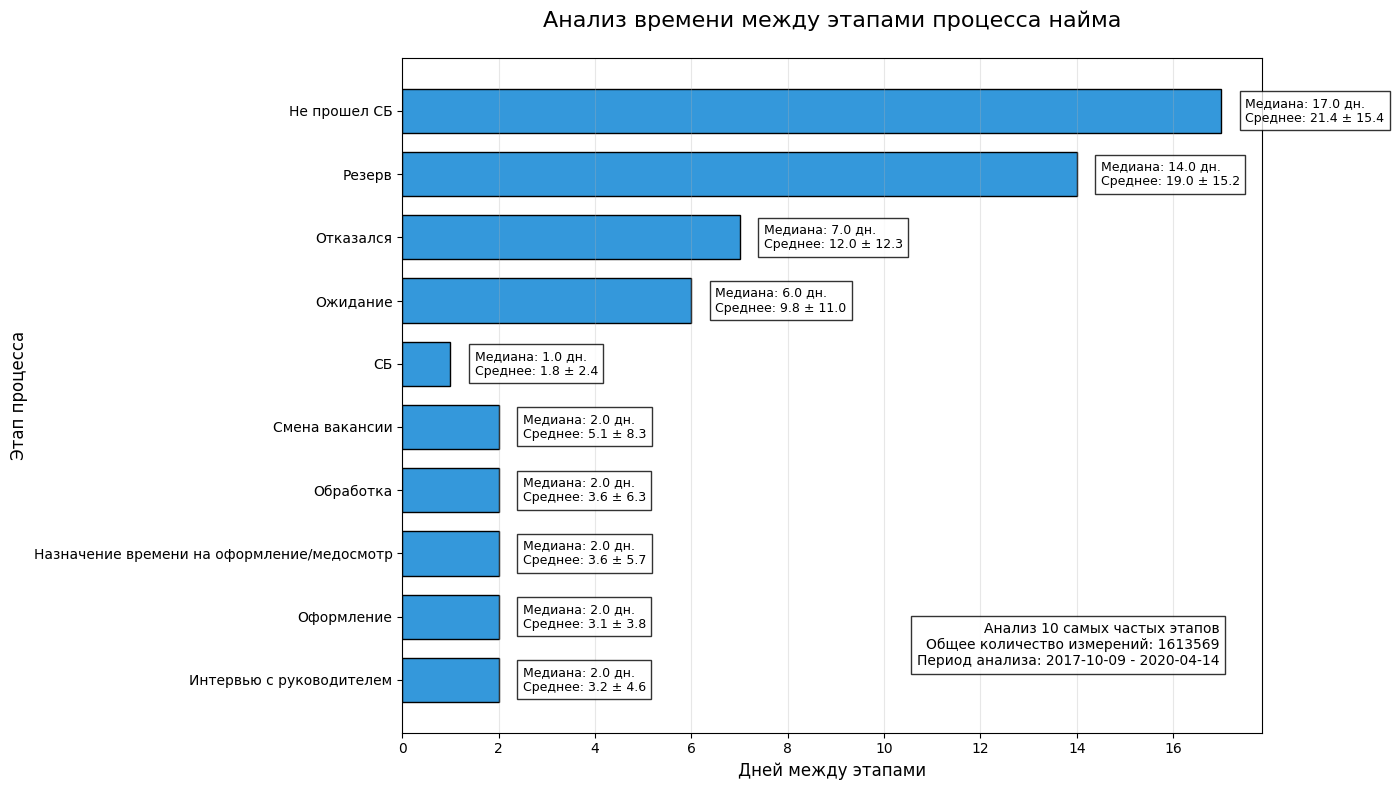

In [ ]:
def plot_time_intervals(df, top_n=10):
    df = df.sort_values(['id_applicant', 'action_date'])

    required_columns = ['id_applicant', 'action_date', 'stage_name']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Отсутствуют необходимые колонки в DataFrame")

    try:
        df['time_diff'] = df.groupby('id_applicant')['action_date'].diff().dt.days

        df_clean = df[(df['time_diff'] > 0) & (df['time_diff'] <= 60)].copy()

        stage_stats = df_clean.groupby('stage_name')['time_diff'].agg(
            ['median', 'mean', 'std', 'count']
        ).reset_index().nlargest(top_n, 'count')

        stage_stats.columns = ['stage_name', 'median', 'mean', 'std', 'count']

        plt.figure(figsize=(14, 8))

        plt.barh(
            stage_stats['stage_name'],
            stage_stats['median'],
            color='#3498db',
            edgecolor='black',
            height=0.7
        )

        for i, (_, row) in enumerate(stage_stats.iterrows()):
            plt.text(
                row['median'] + 0.5,
                i,
                f"Медиана: {row['median']:.1f} дн.\nСреднее: {row['mean']:.1f} ± {row['std']:.1f}",
                va='center',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8)
            )

        plt.title('Анализ времени между этапами процесса найма\n', fontsize=16)
        plt.xlabel('Дней между этапами', fontsize=12)
        plt.ylabel('Этап процесса', fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        plt.xlim(left=0)

        min_date = df['action_date'].min().date() if not df.empty else 'N/A'
        max_date = df['action_date'].max().date() if not df.empty else 'N/A'

        plt.annotate(
            f"Анализ {top_n} самых частых этапов\n"
            f"Общее количество измерений: {stage_stats['count'].sum()}\n"
            f"Период анализа: {min_date} - {max_date}",
            xy=(0.95, 0.1),
            xycoords='axes fraction',
            ha='right',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ошибка при построении графика: {str(e)}")
        raise

try:
    plot_time_intervals(df_without_nan)
except Exception as e:
    print(f"Не удалось выполнить анализ: {str(e)}")

Гипотеза 1


In [ ]:
if 'action_date' in df_without_nan.columns:
    processing = df_without_nan[df_without_nan['stage_name'] == 'Обработка']
    processing_time = processing.groupby('id_applicant')['action_date'].agg(['min', 'max'])
    processing_time['duration'] = (processing_time['max'] - processing_time['min']).dt.days
    average_duration = processing_time['duration'].median()
    print(f"Медианное время обработки: {average_duration} дней")
else:
    print("Ошибка: Столбец 'action_date' не найден в данных.")

Медианное время обработки: 0.0 дней


In [ ]:
rejected_mask = processing["result_name"].isin(["Не резерв", "Источник не Яндекс Цифра"])
rejection_rate = rejected_mask.sum() / len(processing)
print(f"Доля отклонений: {rejection_rate:.2%}")

Доля отклонений: 30.15%


In [ ]:
repeated_actions = processing.groupby("id_applicant").size()
repeated_candidates = repeated_actions[repeated_actions > 1].count()
print(f"Кандидатов с повторными проверками: {repeated_candidates}")

Кандидатов с повторными проверками: 741614


In [ ]:
auto_checks = processing["activity_name"].str.contains("Проверка формы", na=False).sum()
manual_checks = processing["activity_name"].str.contains("Провести первичную", na=False).sum()
print(f"Автоматические: {auto_checks}, Ручные: {manual_checks}, Соотношение: {auto_checks/manual_checks:.2f}")

Автоматические: 454280, Ручные: 1474694, Соотношение: 0.31


In [ ]:
def analyze_processing_stage(df):
    if 'action_date' not in df.columns:
        print("Ошибка: Отсутствует столбец 'action_date'")
        return

    try:
        processing = df[df['stage_name'] == 'Обработка'].copy()
        processing['action_date'] = pd.to_datetime(processing['action_date'])

        time_boundaries = processing.groupby('id_applicant', observed=True)['action_date'].agg(
            ['min', 'max']
        ).reset_index()

        time_boundaries.columns = ['id_applicant', 'first_action', 'last_action']

        time_boundaries['duration_hours'] = (
            (time_boundaries['last_action'] - time_boundaries['first_action']).dt.total_seconds() / 3600
        )

        valid_durations = time_boundaries[time_boundaries['duration_hours'] > 0]

        median_duration = valid_durations['duration_hours'].median()
        mean_duration = valid_durations['duration_hours'].mean()
        print(f"Медианное время обработки: {median_duration:.1f} часов")
        print(f"Среднее время обработки: {mean_duration:.1f} часов")

    except KeyError as e:
        print(f"Ошибка в структуре данных: {str(e)}")
        return

    try:
        rejection_reasons = processing['result_name'].value_counts(normalize=True)
        print("\nРаспределение причин отклонений:")
        print(rejection_reasons.get('Не резерв', 0))
        print(rejection_reasons.get('Источник не Яндекс Цифра', 0))

    except KeyError:
        print("\nОшибка: Отсутствует столбец 'result_name'")

    try:
        action_counts = processing.groupby('id_applicant', observed=True).size()
        repeated_candidates = action_counts[action_counts > 1].count()
        print(f"\nКандидатов с повторными проверками: {repeated_candidates}")

    except KeyError:
        print("\nОшибка: Невозможно проанализировать повторные действия")

    try:
        processing['is_auto_check'] = processing['activity_name'].str.contains('Проверка формы', na=False)
        processing['is_manual_check'] = processing['activity_name'].str.contains('Провести первичную', na=False)

        automation_stats = processing.groupby('id_applicant', observed=True).agg({
            'is_auto_check': 'sum',
            'is_manual_check': 'sum'
        })

        print("\nСоотношение автоматических/ручных операций:")
        print(f"Автоматические проверки: {automation_stats['is_auto_check'].sum()}")
        print(f"Ручные проверки: {automation_stats['is_manual_check'].sum()}")
        print(f"Соотношение: {automation_stats['is_auto_check'].sum()/automation_stats['is_manual_check'].sum():.2f}")

    except KeyError:
        print("\nОшибка: Невозможно проанализировать автоматизацию процессов")


In [ ]:
analyze_processing_stage(df_without_nan)

Медианное время обработки: 0.0 часов
Среднее время обработки: 70.4 часов

Распределение причин отклонений:
0.21448172370309582
0.08729085761341504

Кандидатов с повторными проверками: 741614

Соотношение автоматических/ручных операций:
Автоматические проверки: 454280
Ручные проверки: 1474694
Соотношение: 0.31


Гипотеза 2

In [ ]:
if 'action_date' in df_without_nan.columns:
    sb_steps = df_without_nan[df_without_nan["stage_name"] == "СБ"]
    sb_time = sb_steps.groupby("id_applicant")["action_date"].agg(lambda x: x.max() - x.min())
    print(f"Медиана времени проверки СБ: {sb_time.dt.days.median()} дней")
else:
    print("Столбец 'action_date' не найден.")

Медиана времени проверки СБ: 0.0 дней


In [ ]:
sb_repeats = sb_steps.groupby("id_applicant").size()
sb_repeats_rate = (sb_repeats > 1).sum() / len(sb_repeats)
print(f"Доля повторных проверок СБ: {sb_repeats_rate:.2%}")

Доля повторных проверок СБ: 99.13%


In [ ]:
converted = df_without_nan[df_without_nan["stage_name"] == "Оформление"]["id_applicant"].nunique()
conversion_rate = converted / sb_steps["id_applicant"].nunique()
print(f"Конверсия: {conversion_rate:.2%}")

Конверсия: 70.41%


In [ ]:
import pandas as pd

if 'action_date' in df_without_nan.columns:
    df_without_nan['action_date'] = pd.to_datetime(df_without_nan['action_date'], format='%Y-%m-%d %H:%M:%S.%f%z')

    prep_start = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['activity_name'] == 'Подготовить анкету кандидата')
    ]['action_date'].min()

    sb_end = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['activity_name'] == 'Узнать результаты СБ')
    ]['action_date'].max()

    sb_duration = (sb_end - prep_start).days
    print(f"Время проверки СБ: {sb_duration} дней (ранее: 21.2)\n")

    applicant_checks = df_without_nan[
        df_without_nan['stage_name'] == 'СБ'
    ].groupby('id_applicant')['id_log'].nunique()

    sb_repeats_rate = (applicant_checks > 1).mean()
    print(f"Доля повторных проверок СБ: {sb_repeats_rate:.2%}\n")

    sb_candidates = df_without_nan[
        df_without_nan['stage_name'] == 'СБ'
    ]['id_applicant'].unique()

    converted = df_without_nan[
        (df_without_nan['stage_name'] == 'Оформление') &
        (df_without_nan['id_applicant'].isin(sb_candidates))
    ]['id_applicant'].unique()

    baseline_conversion = 0.75
    conversion_rate = len(converted) / len(sb_candidates) if len(sb_candidates) > 0 else 0
    print(f"Конверсия: {conversion_rate:.2%} vs Эталон {baseline_conversion:.2%}\n")

    errors = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['result_name'] == 'Не резерв')
    ]
    print(f"Ошибки в анкетах: {len(errors)}")
    print(f"Доля ошибок: {len(errors) / len(sb_candidates):.2%}\n" if len(sb_candidates) > 0 else "Нет данных для расчета доли ошибок.\n")

    successful = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['id_applicant'].isin(converted))
    ].groupby('id_applicant')['action_date'].agg(lambda x: x.max() - x.min()).dt.days

    unsuccessful = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (~df_without_nan['id_applicant'].isin(converted))
    ].groupby('id_applicant')['action_date'].agg(lambda x: x.max() - x.min()).dt.days

    print("Сравнение времени проверки:")
    print(f"Успешные: {successful.median()} дней vs Неуспешные: {unsuccessful.median()} дней")

else:
    print("Столбец 'action_date' не найден.")


Время проверки СБ: 918 дней (ранее: 21.2)

Доля повторных проверок СБ: 99.13%

Конверсия: 68.73% vs Эталон 75.00%

Ошибки в анкетах: 186888
Доля ошибок: 43.39%

Сравнение времени проверки:
Успешные: 0.0 дней vs Неуспешные: 0.0 дней


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

if 'action_date' in df_without_nan.columns:
    df_without_nan['action_date'] = pd.to_datetime(df_without_nan['action_date'], format='%Y-%m-%d %H:%M:%S.%f%z')

    prep_times = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['activity_name'] == 'Подготовить анкету кандидата')
    ].groupby('id_applicant')['action_date'].min()

    result_times = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['activity_name'] == 'Узнать результаты СБ')
    ].groupby('id_applicant')['action_date'].max()

    sb_duration = (result_times - prep_times).dt.days
    print(f"Среднее время проверки СБ: {sb_duration.mean():.1f} дней\n")

    session_counts = df_without_nan[df_without_nan['stage_name'] == 'СБ'].groupby('id_applicant')['id_log'].nunique()
    sb_repeats_rate = (session_counts > 1).mean()
    print(f"Доля кандидатов с повторными проверками: {sb_repeats_rate:.2%}\n")

    converted_ids = df_without_nan[df_without_nan['stage_name'] == 'Оформление']['id_applicant'].unique()

    time_converted = sb_duration[sb_duration.index.isin(converted_ids)].dropna()
    time_non_converted = sb_duration[~sb_duration.index.isin(converted_ids)].dropna()

    if len(time_converted) > 0 and len(time_non_converted) > 0:
        t_stat, p_value = ttest_ind(time_converted, time_non_converted, nan_policy='omit')
        print(f"p-значение различий во времени: {p_value:.4f}")
    else:
        print("Недостаточно данных для проведения теста значимости.\n")

    total_checks = df_without_nan[df_without_nan['stage_name'] == 'СБ'].shape[0]
    error_count = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['result_name'] == 'Не резерв')
    ].shape[0]

    if total_checks > 0:
        error_rate = error_count / total_checks
        print(f"Доля ошибок в анкетах: {error_rate:.2%}")
    else:
        print("Нет данных для расчета доли ошибок.")
else:
    print("Столбец 'action_date' не найден.")


Среднее время проверки СБ: 2.7 дней

Доля кандидатов с повторными проверками: 99.13%

p-значение различий во времени: 0.0000
Доля ошибок в анкетах: 16.59%


In [ ]:
if 'action_date' in df_without_nan.columns:
    sb_data = df_without_nan[
        (df_without_nan['stage_name'] == 'СБ') &
        (df_without_nan['activity_name'].isin(['Подготовить анкету кандидата', 'Узнать результаты СБ']))
    ].copy()

    sb_data = sb_data.sort_values(['id_applicant', 'action_date'])
    sb_data = sb_data.drop_duplicates(['id_applicant', 'activity_name'], keep='first')

    prep_times = sb_data[sb_data['activity_name'] == 'Подготовить анкету кандидата'].set_index('id_applicant')['action_date']
    result_times = sb_data[sb_data['activity_name'] == 'Узнать результаты СБ'].set_index('id_applicant')['action_date']

    valid_ids = prep_times.index.intersection(result_times.index)
    prep_times = prep_times[valid_ids]
    result_times = result_times[valid_ids]

    sb_duration = (result_times - prep_times).dt.days
    sb_duration = sb_duration[sb_duration >= 0]

    print(f"Среднее время проверки СБ: {sb_duration.mean():.1f} дней")
    print(f"Медианное время проверки СБ: {sb_duration.median()} дней")

Среднее время проверки СБ: 0.4 дней
Медианное время проверки СБ: 0.0 дней


In [ ]:
sb_sessions = df_without_nan[df_without_nan['stage_name'] == 'СБ'].groupby(['id_applicant', 'id_log']).size()

applicant_checks = sb_sessions.groupby('id_applicant').count()
sb_repeats_rate = (applicant_checks > 1).mean()

print(f"Доля кандидатов с повторными проверками: {sb_repeats_rate:.2%}")

Доля кандидатов с повторными проверками: 99.13%


In [ ]:
first_checks = df_without_nan[
    (df_without_nan['stage_name'] == 'СБ') &
    (df_without_nan['activity_name'] == 'Подготовить анкету кандидата')
].groupby('id_applicant').first()

error_rate_first = (first_checks['result_name'] == 'Не резерв').mean()
print(f"Доля ошибок в первой проверке: {error_rate_first:.2%}")

Доля ошибок в первой проверке: 0.00%


Гипотеза 3

In [ ]:
missed_calls = df_without_nan[df_without_nan["result_name"] == "Недозвон"].copy()
missed_calls["hour"] = missed_calls["action_date"].dt.hour
peak_hour = missed_calls["hour"].mode()[0]
print(f"Пик недозвонов: {peak_hour}:00")

In [ ]:
call_attempts = processing_data[
    processing_data["activity_name"].str.contains("назначить время на оформление", case=False, na=False)
]

call_attempts_per_hour = call_attempts.groupby("hour").size()
missed_calls_per_hour = call_attempts[call_attempts["result_name"] == "Недозвон"].groupby("hour").size()

missed_ratio = (missed_calls_per_hour / call_attempts_per_hour).fillna(0)
print(f"Максимальное соотношение недозвонов: {missed_ratio.max():.2%}")

NameError: name 'processing_data' is not defined

In [ ]:
processing_data = processing_data.sort_values(["id_applicant", "action_date"])

processing_data["response_time"] = (
    processing_data.groupby("id_applicant")["action_date"]
    .diff()
    .dt.total_seconds() / 60
)

valid_processing_data = processing_data[processing_data["response_time"] >= 0]

mean_response_time = valid_processing_data["response_time"].mean()
print(f"Среднее время ответа: {mean_response_time:.1f} минут")

NameError: name 'processing_data' is not defined

In [ ]:
valid_processing_data = valid_processing_data.copy()

applicant_missed = (
    valid_processing_data[valid_processing_data["result_name"] == "Недозвон"]
    .groupby("id_applicant")
    .size()
)

applicants_2plus_missed = applicant_missed[applicant_missed >= 2].count()
print(f"Кандидатов с 2+ недозвонами: {applicants_2plus_missed}")

NameError: name 'valid_processing_data' is not defined

In [ ]:
valid_processing_data["30min_interval"] = valid_processing_data["action_date"].dt.floor("30min")
concurrent_calls = valid_processing_data.groupby("30min_interval").size()

missed_calls_30min = valid_processing_data[
    valid_processing_data["result_name"] == "Недозвон"
].groupby("30min_interval").size()

plt.figure(figsize=(12, 6))
plt.plot(concurrent_calls.index, concurrent_calls.values, label="Все вызовы")
plt.plot(missed_calls_30min.index, missed_calls_30min.values, label="Недозвоны", color="red")
plt.xticks(rotation=45)
plt.title("Загрузка операторов и недозвоны (исправленные данные)")
plt.xlabel("Время")
plt.ylabel("Количество")
plt.legend()
plt.show()

In [ ]:
print(f"Пропуски в action_date: {valid_processing_data['action_date'].isnull().sum()}")
print(f"Пропуски в result_name: {valid_processing_data['result_name'].isnull().sum()}")

action_counts = valid_processing_data.groupby(["id_applicant", "hour"]).size()
normal_applicants = action_counts[action_counts <= 10].index
valid_processing_data = valid_processing_data[valid_processing_data["id_applicant"].isin(normal_applicants)]

Гипотеза 4

In [ ]:
reserve_candidates = df_without_nan[df_without_nan['stage_name'] == 'Резерв']

reserve_candidates = reserve_candidates.sort_values(['id_applicant', 'action_date'])

reserve_time = (
    reserve_candidates.groupby('id_applicant')
    .apply(lambda x: x['action_date'].max() - x['action_date'].min())
    .dt.days
)

reserve_time_valid = reserve_time[reserve_time > 0]
print(f"Медиана времени в резерве: {reserve_time_valid.median()} дней")

Медиана времени в резерве: 26.0 дней


<ipython-input-14-9823b1eaee9f>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['action_date'].max() - x['action_date'].min())


In [ ]:
candidate_journeys = (
    df_without_nan.groupby('id_applicant')
    .apply(lambda x: x.sort_values('action_date')['stage_name'].tolist())
)

reserve_to_processing = [
    'Резерв' in journey and
    'Оформление' in journey and
    journey.index('Оформление') > journey.index('Резерв')
    for journey in candidate_journeys
]

reserve_conversion = sum(reserve_to_processing)/len(reserve_candidates['id_applicant'].unique())
print(f"Доля переходов из резерва: {reserve_conversion:.2%}")

<ipython-input-15-90ffb4fdabe1>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('action_date')['stage_name'].tolist())


Доля переходов из резерва: 19.19%


In [ ]:
reactivation_actions = reserve_candidates[
    reserve_candidates['activity_name'] == 'Вернуть в воронку'
].groupby('id_applicant').size()

print(f"Среднее количество реактиваций: {reactivation_actions.mean():.1f}")

Среднее количество реактиваций: nan


In [ ]:
full_journey = df_without_nan.groupby('id_applicant')['action_date']
total_tth = (full_journey.max() - full_journey.min()).dt.days

with_reserve = total_tth[reserve_time.index]
without_reserve = total_tth[~total_tth.index.isin(reserve_time.index)]

print(f"Медиана TTH с резервом: {with_reserve.median()} дней")
print(f"Медиана TTH без резерва: {without_reserve.median()} дней")

Медиана TTH с резервом: 34.0 дней
Медиана TTH без резерва: 3.0 дней
